`ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.spatial import distance
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Gmarket Sans'
plt.rcParams['axes.unicode_minus'] = False

import sys
sys.path.append('/Users/jun-seokoh/Desktop/TIL/data analysis')

from da_utils import profile, outliers, pattern

`ÌååÏùº ÏùΩÏñ¥Ïò§Í∏∞(apt 2020 ~ 2024)`

In [2]:
df_2024 = pd.read_csv('./apt_2024.csv', encoding='EUC KR')

df_2023 = pd.read_csv('./apt_2023.csv', encoding='EUC KR')
df_2022 = pd.read_csv('./apt_2022.csv', encoding='EUC KR')
df_2021 = pd.read_csv('./apt_2021.csv', encoding='EUC KR')
df_2020 = pd.read_csv('./apt_2020.csv', encoding='EUC KR')
interest_rate = pd.read_csv('./interest.csv', encoding='UTF-8')
display(interest_rate)
df_2024.info()


Î≥ÄÍ≤ΩÎÖÑÎèÑ     Î≥ÄÍ≤ΩÏõîÏùº  Í∏∞Ï§ÄÍ∏àÎ¶¨
0   2024  11Ïõî 28Ïùº  3.00
1   2024  10Ïõî 11Ïùº  3.25
2   2023  01Ïõî 13Ïùº  3.50
3   2022  11Ïõî 24Ïùº  3.25
4   2022  10Ïõî 12Ïùº  3.00
5   2022  08Ïõî 25Ïùº  2.50
6   2022  07Ïõî 13Ïùº  2.25
7   2022  05Ïõî 26Ïùº  1.75
8   2022  04Ïõî 14Ïùº  1.50
9   2022  01Ïõî 14Ïùº  1.25
10  2021  11Ïõî 25Ïùº  1.00
11  2021  08Ïõî 26Ïùº  0.75
12  2020  05Ïõî 28Ïùº  0.50
13  2020  03Ïõî 17Ïùº  0.75
14  2019  10Ïõî 16Ïùº  1.25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NO        57458 non-null  int64  
 1   ÏãúÍµ∞Íµ¨       57458 non-null  object 
 2   Î≤àÏßÄ        57458 non-null  object 
 3   Î≥∏Î≤à        57458 non-null  int64  
 4   Î∂ÄÎ≤à        57458 non-null  int64  
 5   Îã®ÏßÄÎ™Ö       57458 non-null  object 
 6   Ï†ÑÏö©Î©¥Ï†Å(„é°)   57458 non-null  float64
 7   Í≥ÑÏïΩÎÖÑÏõî      57458 non-null  int64  
 8   Í≥ÑÏïΩÏùº       57458 non-null  int64  
 9   Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)  57458 non-null  object 
 10  Îèô         57458 non-null  object 
 11  Ï∏µ         57458 non-null  int64  
 12  Îß§ÏàòÏûê       57458 non-null  object 
 13  Îß§ÎèÑÏûê       57458 non-null  object 
 14  Í±¥Ï∂ïÎÖÑÎèÑ      57458 non-null  int64  
 15  ÎèÑÎ°úÎ™Ö       57458 non-null  object 
 16  Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº   57458 non-null  object 
 17  Í±∞ÎûòÏú†Ìòï      57458 non-null  object 

`Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò ÏÉùÏÑ±`

In [3]:

def clean_data(df):
    # df Î≥µÏÇ¨
    dfc = df.copy()
    
    # Í≤∞Ï∏°Ïπò '-' -> Na
    obj_cols = dfc.select_dtypes(include=['object']).columns
    dfc[obj_cols] = dfc[obj_cols].replace('-', pd.NA)
    
    # 1) Ï§ëÎ≥µ Ï†úÍ±∞
    dfc.drop_duplicates(subset=['Îã®ÏßÄÎ™Ö', 'Í≥ÑÏïΩÎÖÑÏõî', 'Í≥ÑÏïΩÏùº','Ï†ÑÏö©Î©¥Ï†Å(„é°)','Ï∏µ','Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)'], inplace=True)

    # 2) Ìï¥Ï†ú Í±¥ Î∂ÑÎ¶¨ Î≥¥Í¥Ä ‚Üí df_cancel, Î≥∏Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï†úÍ±∞
    if 'Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº' in dfc.columns:
        df_cancel = dfc[dfc['Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº'].notna()].copy()
        dfc = dfc[dfc['Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº'].isna()].copy()
    else:
        df_cancel = pd.DataFrame(columns=dfc.columns)

    # 3) Í≥ÑÏïΩÎÖÑÏõî+Í≥ÑÏïΩÏùº ‚Üí Í≥ÑÏïΩÏùºÏûê(datetime), Í≥ÑÏïΩÏùº ÎìúÎ°≠
    # dfc['Í≥ÑÏïΩÎÖÑÏõî'] = pd.to_datetime(dfc['Í≥ÑÏïΩÎÖÑÏõî'].astype(str), format='%Y%m')
    ym = pd.to_datetime(dfc['Í≥ÑÏïΩÎÖÑÏõî'].astype(str), format='%Y%m', errors='coerce')
    day = dfc['Í≥ÑÏïΩÏùº'].astype('Int64')
    dfc['Í≥ÑÏïΩÏùºÏûê'] = ym + pd.to_timedelta(day - 1, unit='D')
    dfc.drop(columns=['Í≥ÑÏïΩÏùº'], inplace=True)

    # 4) ÏãúÍµ∞Íµ¨ ‚Üí Ïãú/Íµ¨/Îèô Î∂ÑÌï¥ ÌõÑ ÏõêÎ≥∏ ÎìúÎ°≠
    ext = dfc['ÏãúÍµ∞Íµ¨'].str.extract(r'^(?P<Ïãú>\S+)\s+(?P<Íµ¨>\S+)\s*(?P<Îèô>.*)$')
    dfc[['Ïãú','Íµ¨','Îèô']] = ext[['Ïãú','Íµ¨','Îèô']]
    dfc.drop(columns=['ÏãúÍµ∞Íµ¨'], inplace=True)

    # 5) Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê) ‚Üí int
    dfc['Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)'] = (
        dfc['Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)'].astype(str)
        .str.replace(',', '', regex=False)
        # .str.replace('\u00a0', '', regex=False)
        # .str.strip()
        # .replace({'': pd.NA})
        .astype('Int64')
    )
    
    # 6) ÌååÏÉù: ÌèâÎã®Í∞Ä(ÎßåÏõê) (Î©¥Ï†Å ÎåÄÎπÑ ÎπÑÍµê ÏßÄÌëú)
    dfc['ÌèâÎã®Í∞Ä(ÎßåÏõê)'] = (dfc['Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)'].astype(float) / (dfc['Ï†ÑÏö©Î©¥Ï†Å(„é°)'] / 3.3)).round(2)
    
    # 7) Î∂àÌïÑÏöî Ïª¨Îüº ÎìúÎ°≠ (ÌïÑÏöîÏãú ÏàòÏ†ï)
    drop_cols = ['NO','Î≤àÏßÄ','Î≥∏Î≤à','Î∂ÄÎ≤à','ÎèÑÎ°úÎ™Ö','Í±∞ÎûòÏú†Ìòï','Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ','Îì±Í∏∞ÏùºÏûê','Îß§ÏàòÏûê','Îß§ÎèÑÏûê','Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº']
    dfc.drop(columns=[c for c in drop_cols if c in dfc.columns], inplace=True, errors='ignore')

    # 8) Ïª¨Îüº Ï†ïÎ¶¨: ÏµúÏÜå Î∂ÑÏÑùÏÖã Ïö∞ÏÑ† Î∞∞Ïπò
    preferred = ['Í≥ÑÏïΩÏùºÏûê','Ïãú','Íµ¨','Îèô','Ï†ÑÏö©Î©¥Ï†Å(„é°)','Ï∏µ','Í±¥Ï∂ïÎÖÑÎèÑ','Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)','ÌèâÎãπÍ∞Ä(ÎßåÏõê)','Îã®ÏßÄÎ™Ö',]
    exist = [c for c in preferred if c in dfc.columns]
    others = [c for c in dfc.columns if c not in exist]
    dfc = dfc[exist + others].reset_index(drop=True)
    
    
    return dfc, df_cancel


`Ï†ÑÏ≤òÎ¶¨ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•`

In [4]:
df_2024_c, df_2024_canceled  = clean_data(df_2024)
df_2023_c, df_2023_canceled  = clean_data(df_2023)
df_2022_c, df_2022_canceled  = clean_data(df_2022)
df_2021_c, df_2021_canceled  = clean_data(df_2021)
df_2020_c, df_2020_canceled  = clean_data(df_2020)


# Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£åÎêú Ïó∞ÎèÑÎ≥Ñ ÌÖåÏù¥Î∏îÎì§
dfs = [df_2020_c, df_2021_c, df_2022_c, df_2023_c, df_2024_c]

# ÌïòÎÇòÎ°ú Ìï©ÏπòÍ∏∞
df_all = pd.concat(dfs, ignore_index=True)

# Ïó∞ÎèÑ Ïª¨Îüº Ï∂îÍ∞Ä
df_all['Ïó∞ÎèÑ'] = df_all['Í≥ÑÏïΩÏùºÏûê'].dt.year

df_all

Í≥ÑÏïΩÏùºÏûê      Ïãú     Íµ¨      Îèô  Ï†ÑÏö©Î©¥Ï†Å(„é°)   Ï∏µ  Í±¥Ï∂ïÎÖÑÎèÑ  Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)  \
0      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÑ±Î∂ÅÍµ¨    ÎèàÏïîÎèô   84.980   2  2013     82000   
1      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Ïö©ÏÇ∞Íµ¨    ÌïúÎÇ®Îèô  240.305   2  2011    710000   
2      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÑ±ÎèôÍµ¨  Í∏àÌò∏Îèô4Í∞Ä   84.880   4  2018    180000   
3      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú  ÎèôÎåÄÎ¨∏Íµ¨    Ï†úÍ∏∞Îèô  104.220   8  1978     59500   
4      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Ïö©ÏÇ∞Íµ¨    ÎèÑÏõêÎèô   84.920  10  2001    135000   
...           ...    ...   ...    ...      ...  ..   ...       ...   
219316 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Í∞ïÎèôÍµ¨    ÏÉÅÏùºÎèô   59.980  10  2020    117500   
219317 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÜ°ÌååÍµ¨    Í∞ÄÎùΩÎèô   84.885   5  2007    149000   
219318 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÜ°ÌååÍµ¨    Í∞ÄÎùΩÎèô   59.940  11  2005    100000   
219319 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Íµ¨Î°úÍµ¨    Í∞úÎ¥âÎèô   84.960  11  2000     58000   
219320 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏùÄÌèâÍµ¨    ÏßÑÍ¥ÄÎèô   84.720  13  2009     97000   

                                Îã®ÏßÄÎ™Ö    Í≥ÑÏïΩÎÖÑÏõî  ÌèâÎã®Í∞Ä(ÎßåÏõê)    Ïó∞ÎèÑ  
0                           ÎèàÏïîÎèôÌï¥ÌîºÌä∏Î¶¨  202012  3184.28  2020  
1                              ÌïúÎÇ®ÎçîÌûê  202012  9750.11  2020  
2                        ÌûêÏä§ÌÖåÏù¥Ìä∏ÏÑúÏö∏Ïà≤Î¶¨Î≤Ñ  202012  6998.11  2020  
3                                Í≥µÏÑ±  202012  1884.00  2020  
4                             ÏÇºÏÑ±ÎûòÎØ∏Ïïà  202012  5246.11  2020  
...                             ...     ...      ...   ...  
219316                       Í≥†ÎçïÏïÑÎ•¥ÌÖåÏò®  202401  6464.65  2024  
219317                     ÎûòÎØ∏ÏïàÌååÌÅ¨Ìå∞Î¶¨Ïä§  202401  5792.54  2024  
219318          Í∞ÄÎùΩ3Ï∞®ÏåçÏö©Ïä§ÏúóÎã∑Ìôà101Îèô,102Îèô  202401  5505.51  2024  
219319                           ÌïúÏßÑ  202401  2252.82  2024  
219320  Î∞ïÏÑùÍ≥†Í∞ú1Îã®ÏßÄÌûêÏä§ÌÖåÏù¥Ìä∏(116~131Îèô)BL2-1  202401  3778.33  2024  

[219321 rows x 12 columns]

`Í≤∞Ï∏°Í∞í Í≤ÄÏ¶ù`

In [5]:
profile.get_data_profile(df_all)

# pattern.analyze_missing_patterns(df_2024_c)

Ï¢ÖÌï© Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Î¶¨Ìè¨Ìä∏

1. Í∏∞Î≥∏Ï†ïÎ≥¥
- Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: 219321Ìñâ x 12Ïó¥
- Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: 79.32mb
- ÏàòÏπòÌòï Î≥ÄÏàò: 7Í∞ú
- Î≤îÏ£ºÌòï Î≥ÄÏàò: 4Í∞ú

2. Í≤∞Ï∏°Í∞í Î∂ÑÏÑù
Í≤∞Ï∏°Í∞í ÏóÜÏùå. ÏôÑÏ†Ñ

3. ÏàòÏπòÌòï Î≥ÄÏàò ÌíàÏßà Î∂ÑÏÑù


Î≥ÄÏàòÎ™Ö          ÌèâÍ∑†       ÌëúÏ§ÄÌé∏Ï∞®         ÏµúÏÜüÍ∞í         ÏµúÎåìÍ∞í     ÏôúÎèÑ      Ï≤®ÎèÑ  \
0   Ï†ÑÏö©Î©¥Ï†Å(„é°)      75.158     30.515      10.156      317.36  1.176   3.824   
1         Ï∏µ       9.416      6.329      -3.000       68.00  1.223   3.081   
2      Í±¥Ï∂ïÎÖÑÎèÑ    2002.037     10.608    1961.000     2024.00 -0.139  -0.372   
3  Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)  100879.251  75909.569    6000.000  2500000.00  3.398  29.681   
4      Í≥ÑÏïΩÎÖÑÏõî  202178.919    164.401  202001.000   202412.00  0.285  -1.595   
5   ÌèâÎã®Í∞Ä(ÎßåÏõê)    4354.816   2254.357     510.710    30115.82  1.746   4.507   
6        Ïó∞ÎèÑ    2021.727      1.642    2020.000     2024.00  0.282  -1.595   

   Ïù¥ÏÉÅÍ∞íÎπÑÏú®(%)  Ïú†ÏùºÍ∞íÎπÑÏú®(%)  
0     9.585     5.155  
1     1.833     0.032  
2     0.389     0.028  
3     6.039     2.101  
4     0.000     0.027  
5     5.033    51.571  
6     0.000     0.002


4. Î∂ÑÌè¨ Ïù¥ÏÉÅ Í∞êÏßÄ

- Í∑πÏã¨Ìïú ÏôúÎèÑ(|skewness| > 2)
--Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê): ÏôúÎèÑ =  3.398000

- ÎÜíÏùÄ Ïù¥ÏÉÅÍ∞í ÎπÑÏú®(>5%)
['Ï†ÑÏö©Î©¥Ï†Å(„é°)', 'Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)', 'ÌèâÎã®Í∞Ä(ÎßåÏõê)']
--Ï†ÑÏö©Î©¥Ï†Å(„é°): Ïù¥ÏÉÅÍ∞í = 9.6%
--Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê): Ïù¥ÏÉÅÍ∞í = 6.0%
--ÌèâÎã®Í∞Ä(ÎßåÏõê): Ïù¥ÏÉÅÍ∞í = 5.0%


Î≥ÄÏàòÎ™Ö          ÌèâÍ∑†       ÌëúÏ§ÄÌé∏Ï∞®         ÏµúÏÜüÍ∞í         ÏµúÎåìÍ∞í     ÏôúÎèÑ      Ï≤®ÎèÑ  \
0   Ï†ÑÏö©Î©¥Ï†Å(„é°)      75.158     30.515      10.156      317.36  1.176   3.824   
1         Ï∏µ       9.416      6.329      -3.000       68.00  1.223   3.081   
2      Í±¥Ï∂ïÎÖÑÎèÑ    2002.037     10.608    1961.000     2024.00 -0.139  -0.372   
3  Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)  100879.251  75909.569    6000.000  2500000.00  3.398  29.681   
4      Í≥ÑÏïΩÎÖÑÏõî  202178.919    164.401  202001.000   202412.00  0.285  -1.595   
5   ÌèâÎã®Í∞Ä(ÎßåÏõê)    4354.816   2254.357     510.710    30115.82  1.746   4.507   
6        Ïó∞ÎèÑ    2021.727      1.642    2020.000     2024.00  0.282  -1.595   

   Ïù¥ÏÉÅÍ∞íÎπÑÏú®(%)  Ïú†ÏùºÍ∞íÎπÑÏú®(%)  
0     9.585     5.155  
1     1.833     0.032  
2     0.389     0.028  
3     6.039     2.101  
4     0.000     0.027  
5     5.033    51.571  
6     0.000     0.002

In [6]:
# _, final_ol_2024 = outliers.outlier_detection(df_2024_c)
# _, final_ol_2023 = outliers.outlier_detection(df_2023_c)
# _, final_ol_2022 = outliers.outlier_detection(df_2022_c)
# _, final_ol_2021 = outliers.outlier_detection(df_2021_c)
# _, final_ol_2020 = outliers.outlier_detection(df_2020_c)
_, apt_outliers = outliers.outlier_detection(df_all)

=== Ï¢ÖÌï© Ïù¥ÏÉÅÍ∞í ÌÉêÏßÄ ÏãúÏä§ÌÖú ===
1. ÏùºÎ≥ÄÎüâ Ïù¥ÏÉÅÍ∞í ÌÉêÏßÄ (IQR Î∞©Î≤ï)
  Ï†ÑÏö©Î©¥Ï†Å(„é°): 21022Í∞ú (9.6%)
  Ï∏µ: 4021Í∞ú (1.8%)
  Í±¥Ï∂ïÎÖÑÎèÑ: 853Í∞ú (0.4%)
  Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê): 13244Í∞ú (6.0%)
  ÌèâÎã®Í∞Ä(ÎßåÏõê): 11038Í∞ú (5.0%)

2. Îã§Î≥ÄÎüâ Ïù¥ÏÉÅÍ∞í ÌÉêÏßÄ (ÎßàÌï†ÎùºÎÖ∏ÎπÑÏä§ Í±∞Î¶¨)
 ÏûÑÍ≥ÑÍ∞í(Í±∞Î¶¨): 4.93
 Îã§Î≥ÄÎüâ Ïù¥ÏÉÅÍ∞í: 4982Í∞ú (2.3%)

3. Îã§Î≥ÄÎüâ Ïù¥ÏÉÅÍ∞í ÌÉêÏßÄ(Isolation Forest)
  Isolation Forest Ïù¥ÏÉÅÍ∞í: 21932Í∞ú (10.0%)

 == ÏµúÏ¢Ö Ïù¥ÏÉÅÍ∞í: 19767Í∞ú (9.0%)


In [7]:
df_all[apt_outliers].groupby('Íµ¨').size().sort_values(ascending=False)
# Ïù¥ÏÉÅÏπòÍ∞Ä Ïú†ÎèÖ ÎßéÏù¥ Î∂ÑÌè¨Îêú ÏßÄÏó≠Ïù¥ Ïù∏Í∏∞Íµ¨Îùº, Î≥ÑÎèÑÏùò Ï†úÍ±∞ ÏûëÏóÖ ÏàòÌñâÌïòÏßÄ ÏïäÏùå.

bins = [0, 60, 85, float('inf')]
labels = ['ÏÜåÌòï','Ï§ëÌòï','ÎåÄÌòï']
df_all['Í∑úÎ™®Íµ¨Î∂Ñ'] = pd.cut(df_all['Ï†ÑÏö©Î©¥Ï†Å(„é°)'], bins=bins, labels=labels, right=True, include_lowest=True)

df_all[apt_outliers].groupby('Í∑úÎ™®Íµ¨Î∂Ñ').size().sort_values(ascending=False)
# Ïó≠Ïãú Ïó¨Í∏∞ÎèÑ ÎåÄÌòïÏóê ÎßéÏù¥ Î∂ÑÌè¨Îê®.

# Í≥ÑÏïΩÎÖÑÏõîÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôò
df_all['Í≥ÑÏïΩÎÖÑÏõî'] = pd.to_datetime(df_all['Í≥ÑÏïΩÎÖÑÏõî'].astype(str), format='%Y%m')

df_all

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/1019133397.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_all[apt_outliers].groupby('Í∑úÎ™®Íµ¨Î∂Ñ').size().sort_values(ascending=False)


Í≥ÑÏïΩÏùºÏûê      Ïãú     Íµ¨      Îèô  Ï†ÑÏö©Î©¥Ï†Å(„é°)   Ï∏µ  Í±¥Ï∂ïÎÖÑÎèÑ  Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)  \
0      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÑ±Î∂ÅÍµ¨    ÎèàÏïîÎèô   84.980   2  2013     82000   
1      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Ïö©ÏÇ∞Íµ¨    ÌïúÎÇ®Îèô  240.305   2  2011    710000   
2      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÑ±ÎèôÍµ¨  Í∏àÌò∏Îèô4Í∞Ä   84.880   4  2018    180000   
3      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú  ÎèôÎåÄÎ¨∏Íµ¨    Ï†úÍ∏∞Îèô  104.220   8  1978     59500   
4      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Ïö©ÏÇ∞Íµ¨    ÎèÑÏõêÎèô   84.920  10  2001    135000   
...           ...    ...   ...    ...      ...  ..   ...       ...   
219316 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Í∞ïÎèôÍµ¨    ÏÉÅÏùºÎèô   59.980  10  2020    117500   
219317 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÜ°ÌååÍµ¨    Í∞ÄÎùΩÎèô   84.885   5  2007    149000   
219318 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÜ°ÌååÍµ¨    Í∞ÄÎùΩÎèô   59.940  11  2005    100000   
219319 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Íµ¨Î°úÍµ¨    Í∞úÎ¥âÎèô   84.960  11  2000     58000   
219320 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏùÄÌèâÍµ¨    ÏßÑÍ¥ÄÎèô   84.720  13  2009     97000   

                                Îã®ÏßÄÎ™Ö       Í≥ÑÏïΩÎÖÑÏõî  ÌèâÎã®Í∞Ä(ÎßåÏõê)    Ïó∞ÎèÑ Í∑úÎ™®Íµ¨Î∂Ñ  
0                           ÎèàÏïîÎèôÌï¥ÌîºÌä∏Î¶¨ 2020-12-01  3184.28  2020   Ï§ëÌòï  
1                              ÌïúÎÇ®ÎçîÌûê 2020-12-01  9750.11  2020   ÎåÄÌòï  
2                        ÌûêÏä§ÌÖåÏù¥Ìä∏ÏÑúÏö∏Ïà≤Î¶¨Î≤Ñ 2020-12-01  6998.11  2020   Ï§ëÌòï  
3                                Í≥µÏÑ± 2020-12-01  1884.00  2020   ÎåÄÌòï  
4                             ÏÇºÏÑ±ÎûòÎØ∏Ïïà 2020-12-01  5246.11  2020   Ï§ëÌòï  
...                             ...        ...      ...   ...  ...  
219316                       Í≥†ÎçïÏïÑÎ•¥ÌÖåÏò® 2024-01-01  6464.65  2024   ÏÜåÌòï  
219317                     ÎûòÎØ∏ÏïàÌååÌÅ¨Ìå∞Î¶¨Ïä§ 2024-01-01  5792.54  2024   Ï§ëÌòï  
219318          Í∞ÄÎùΩ3Ï∞®ÏåçÏö©Ïä§ÏúóÎã∑Ìôà101Îèô,102Îèô 2024-01-01  5505.51  2024   ÏÜåÌòï  
219319                           ÌïúÏßÑ 2024-01-01  2252.82  2024   Ï§ëÌòï  
219320  Î∞ïÏÑùÍ≥†Í∞ú1Îã®ÏßÄÌûêÏä§ÌÖåÏù¥Ìä∏(116~131Îèô)BL2-1 2024-01-01  3778.33  2024   Ï§ëÌòï  

[219321 rows x 13 columns]

In [8]:
df_all

Í≥ÑÏïΩÏùºÏûê      Ïãú     Íµ¨      Îèô  Ï†ÑÏö©Î©¥Ï†Å(„é°)   Ï∏µ  Í±¥Ï∂ïÎÖÑÎèÑ  Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)  \
0      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÑ±Î∂ÅÍµ¨    ÎèàÏïîÎèô   84.980   2  2013     82000   
1      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Ïö©ÏÇ∞Íµ¨    ÌïúÎÇ®Îèô  240.305   2  2011    710000   
2      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÑ±ÎèôÍµ¨  Í∏àÌò∏Îèô4Í∞Ä   84.880   4  2018    180000   
3      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú  ÎèôÎåÄÎ¨∏Íµ¨    Ï†úÍ∏∞Îèô  104.220   8  1978     59500   
4      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Ïö©ÏÇ∞Íµ¨    ÎèÑÏõêÎèô   84.920  10  2001    135000   
...           ...    ...   ...    ...      ...  ..   ...       ...   
219316 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Í∞ïÎèôÍµ¨    ÏÉÅÏùºÎèô   59.980  10  2020    117500   
219317 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÜ°ÌååÍµ¨    Í∞ÄÎùΩÎèô   84.885   5  2007    149000   
219318 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÜ°ÌååÍµ¨    Í∞ÄÎùΩÎèô   59.940  11  2005    100000   
219319 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Íµ¨Î°úÍµ¨    Í∞úÎ¥âÎèô   84.960  11  2000     58000   
219320 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏùÄÌèâÍµ¨    ÏßÑÍ¥ÄÎèô   84.720  13  2009     97000   

                                Îã®ÏßÄÎ™Ö       Í≥ÑÏïΩÎÖÑÏõî  ÌèâÎã®Í∞Ä(ÎßåÏõê)    Ïó∞ÎèÑ Í∑úÎ™®Íµ¨Î∂Ñ  
0                           ÎèàÏïîÎèôÌï¥ÌîºÌä∏Î¶¨ 2020-12-01  3184.28  2020   Ï§ëÌòï  
1                              ÌïúÎÇ®ÎçîÌûê 2020-12-01  9750.11  2020   ÎåÄÌòï  
2                        ÌûêÏä§ÌÖåÏù¥Ìä∏ÏÑúÏö∏Ïà≤Î¶¨Î≤Ñ 2020-12-01  6998.11  2020   Ï§ëÌòï  
3                                Í≥µÏÑ± 2020-12-01  1884.00  2020   ÎåÄÌòï  
4                             ÏÇºÏÑ±ÎûòÎØ∏Ïïà 2020-12-01  5246.11  2020   Ï§ëÌòï  
...                             ...        ...      ...   ...  ...  
219316                       Í≥†ÎçïÏïÑÎ•¥ÌÖåÏò® 2024-01-01  6464.65  2024   ÏÜåÌòï  
219317                     ÎûòÎØ∏ÏïàÌååÌÅ¨Ìå∞Î¶¨Ïä§ 2024-01-01  5792.54  2024   Ï§ëÌòï  
219318          Í∞ÄÎùΩ3Ï∞®ÏåçÏö©Ïä§ÏúóÎã∑Ìôà101Îèô,102Îèô 2024-01-01  5505.51  2024   ÏÜåÌòï  
219319                           ÌïúÏßÑ 2024-01-01  2252.82  2024   Ï§ëÌòï  
219320  Î∞ïÏÑùÍ≥†Í∞ú1Îã®ÏßÄÌûêÏä§ÌÖåÏù¥Ìä∏(116~131Îèô)BL2-1 2024-01-01  3778.33  2024   Ï§ëÌòï  

[219321 rows x 13 columns]

### Ï†ÑÏ≤¥ Ïù¥ÏÉÅÏπòÏùò Íµ¨Îã®ÏúÑ Î∂ÑÌè¨

`ÌÖåÏù¥Î∏î Ìï©ÏπòÍ∏∞`

#### ÌèâÎã®Í∞Ä Í∏∞Ï§Ä ÏÉÅÏúÑ ÏßÄÏó≠ ÏÑ†Î≥Ñ

> ÌèâÎã®Í∞Ä Í∏∞Ï§Ä ÏÉÅÏúÑ 66%Î•º Íæ∏Ï§ÄÌûà Îì§Ïñ¥Ïò® ÏßÄÏó≠ ÏÑ†Î∞ú

- Í∞ïÎÇ®
- ÏÑúÏ¥à
- Ïö©ÏÇ∞
- ÏÜ°Ìåå
- ÏÑ±Îèô
- ÎßàÌè¨

In [9]:
from scipy.stats import norm

# Ïó∞ÎèÑ-Íµ¨Î≥Ñ Ï§ëÏúÑÍ∞í
g = (
    df_all.groupby(['Ïó∞ÎèÑ','Íµ¨'])['ÌèâÎã®Í∞Ä(ÎßåÏõê)']
        .median().reset_index(name='Ï§ëÏúÑÍ∞í')
)

# ÏàúÏúÑ(ÎÇ¥Î¶ºÏ∞®Ïàú), Î∞±Î∂ÑÏúÑ ÌçºÏÑºÌã∞ÏßÄ(ÏÉÅÏúÑ=100%)
g['ÏàúÏúÑ'] = g.groupby('Ïó∞ÎèÑ')['Ï§ëÏúÑÍ∞í'] \
                .rank(method='dense', ascending=False).astype(int)

g['ÏÉÅÏúÑ(%)'] = (
    g.groupby('Ïó∞ÎèÑ')['Ï§ëÏúÑÍ∞í']
     .transform(lambda x: norm.cdf((x - x.mean()) / x.std()) * 100)
).round(1)

# Ïó∞ÎèÑÎ≥Ñ (Íµ¨, Ï§ëÏúÑÍ∞í, ÌçºÏÑºÌã∞ÏßÄ) ÌëúÎ•º ÎßåÎì§Í≥† Ïù∏Îç±Ïä§Î•º ÏàúÏúÑÎ°ú
per_year = []
for y, sub in g.groupby('Ïó∞ÎèÑ', sort=True):
    t = (sub[['ÏàúÏúÑ','Íµ¨','Ï§ëÏúÑÍ∞í','ÏÉÅÏúÑ(%)']]
            .sort_values(['ÏàúÏúÑ','Ï§ëÏúÑÍ∞í'], ascending=[True, False])
            .set_index('ÏàúÏúÑ'))
    t.columns = pd.MultiIndex.from_product([[y], t.columns])
    per_year.append(t)

out = pd.concat(per_year, axis=1)
out.index.name = 'ÏàúÏúÑ'

out

2020                  2021                  2022                  2023  \
       Íµ¨       Ï§ëÏúÑÍ∞í ÏÉÅÏúÑ(%)     Íµ¨       Ï§ëÏúÑÍ∞í ÏÉÅÏúÑ(%)     Íµ¨       Ï§ëÏúÑÍ∞í ÏÉÅÏúÑ(%)     Íµ¨   
ÏàúÏúÑ                                                                           
1    Í∞ïÎÇ®Íµ¨  7181.105  99.8   Í∞ïÎÇ®Íµ¨  7860.290  99.5   Í∞ïÎÇ®Íµ¨  7936.155  99.7   Í∞ïÎÇ®Íµ¨   
2    ÏÑúÏ¥àÍµ¨  5820.100  96.4   ÏÑúÏ¥àÍµ¨  6811.750  96.5   ÏÑúÏ¥àÍµ¨  6508.270  95.3   ÏÑúÏ¥àÍµ¨   
3    Ïö©ÏÇ∞Íµ¨  5093.070  88.6   ÏÜ°ÌååÍµ¨  6284.250  92.2   ÏÜ°ÌååÍµ¨  6482.610  95.2   Ïö©ÏÇ∞Íµ¨   
4    ÏÜ°ÌååÍµ¨  5048.470  87.9   Ïö©ÏÇ∞Íµ¨  6110.230  90.1   Ïö©ÏÇ∞Íµ¨  6191.370  92.6   ÏÜ°ÌååÍµ¨   
5    ÏÑ±ÎèôÍµ¨  4678.120  80.7   ÏÑ±ÎèôÍµ¨  5785.000  85.1   ÏÑ±ÎèôÍµ¨  5777.890  87.2   ÏÑ±ÎèôÍµ¨   
6    Í¥ëÏßÑÍµ¨  4375.055  73.3   Í¥ëÏßÑÍµ¨  5246.730  73.7   ÎßàÌè¨Íµ¨  4936.400  69.6   ÎßàÌè¨Íµ¨   
7    ÎßàÌè¨Íµ¨  4343.890  72.4   ÎßàÌè¨Íµ¨  5127.230  70.7   Í¥ëÏßÑÍµ¨  4703.010  63.3   Í¥ëÏßÑÍµ¨   
8    ÎèôÏûëÍµ¨  3905.000  59.4   ÎèôÏûëÍµ¨  4775.405  61.0   ÎèôÏûëÍµ¨  4481.055  57.0   ÏñëÏ≤úÍµ¨   
9   ÏòÅÎì±Ìè¨Íµ¨  3743.740  54.2   Í∞ïÎèôÍµ¨  4708.895  59.0   Í∞ïÎèôÍµ¨  4260.560  50.5   Í∞ïÎèôÍµ¨   
10   Í∞ïÎèôÍµ¨  3679.050  52.1  ÏòÅÎì±Ìè¨Íµ¨  4466.910  51.8  ÏòÅÎì±Ìè¨Íµ¨  3945.480  41.2   ÎèôÏûëÍµ¨   
11    Ï§ëÍµ¨  3648.150  51.1    Ï§ëÍµ¨  4340.805  48.0  ÏÑúÎåÄÎ¨∏Íµ¨  3872.970  39.1  ÏòÅÎì±Ìè¨Íµ¨   
12   ÏñëÏ≤úÍµ¨  3321.230  40.6   ÏñëÏ≤úÍµ¨  4076.950  40.2   ÏñëÏ≤úÍµ¨  3859.650  38.8    Ï§ëÍµ¨   
13  ÏÑúÎåÄÎ¨∏Íµ¨  3295.010  39.8  ÏÑúÎåÄÎ¨∏Íµ¨  4064.925  39.8    Ï§ëÍµ¨  3813.840  37.5   Ï¢ÖÎ°úÍµ¨   
14   Ï¢ÖÎ°úÍµ¨  3146.560  35.2   Í∞ïÏÑúÍµ¨  3867.190  34.2   ÎÖ∏ÏõêÍµ¨  3743.260  35.5  ÏÑúÎåÄÎ¨∏Íµ¨   
15   Í∞ïÏÑúÍµ¨  3125.280  34.5   Ï¢ÖÎ°úÍµ¨  3794.700  32.2   ÏÑ±Î∂ÅÍµ¨  3686.230  33.9   Í∞ïÏÑúÍµ¨   
16  ÎèôÎåÄÎ¨∏Íµ¨  3101.770  33.8  ÎèôÎåÄÎ¨∏Íµ¨  3773.240  31.6  ÎèôÎåÄÎ¨∏Íµ¨  3566.450  30.8  ÎèôÎåÄÎ¨∏Íµ¨   
17   ÏÑ±Î∂ÅÍµ¨  2912.790  28.4   ÏÑ±Î∂ÅÍµ¨  3644.005  28.3   Ï¢ÖÎ°úÍµ¨  3508.335  29.3   ÏùÄÌèâÍµ¨   
18   Í¥ÄÏïÖÍµ¨  2844.995  26.5   ÎÖ∏ÏõêÍµ¨  3618.000  27.6   Í¥ÄÏïÖÍµ¨  3379.240  26.1   ÏÑ±Î∂ÅÍµ¨   
19   ÏùÄÌèâÍµ¨  2688.930  22.5   Í¥ÄÏïÖÍµ¨  3571.920  26.4   ÏùÄÌèâÍµ¨  3304.010  24.3   Í¥ÄÏïÖÍµ¨   
20   ÎÖ∏ÏõêÍµ¨  2685.350  22.5   ÏùÄÌèâÍµ¨  3367.350  21.7   Í∞ïÏÑúÍµ¨  3290.095  24.0   ÎÖ∏ÏõêÍµ¨   
21   Íµ¨Î°úÍµ¨  2461.970  17.4   Ï§ëÎûëÍµ¨  3223.870  18.6   Í∏àÏ≤úÍµ¨  3184.770  21.6   Íµ¨Î°úÍµ¨   
22   Ï§ëÎûëÍµ¨  2453.290  17.2   Íµ¨Î°úÍµ¨  3069.230  15.7   Ï§ëÎûëÍµ¨  3125.660  20.3   Ï§ëÎûëÍµ¨   
23   Í∞ïÎ∂ÅÍµ¨  2440.245  16.9   Í∞ïÎ∂ÅÍµ¨  3038.780  15.1   Í∞ïÎ∂ÅÍµ¨  3058.260  18.9   Í∞ïÎ∂ÅÍµ¨   
24   Í∏àÏ≤úÍµ¨  2252.560  13.4   Í∏àÏ≤úÍµ¨  2780.590  11.0   ÎèÑÎ¥âÍµ¨  2836.120  14.8   Í∏àÏ≤úÍµ¨   
25   ÎèÑÎ¥âÍµ¨  2094.890  10.8   ÎèÑÎ¥âÍµ¨  2758.420  10.7   Íµ¨Î°úÍµ¨  2655.980  11.9   ÎèÑÎ¥âÍµ¨   

                    2024                  
         Ï§ëÏúÑÍ∞í ÏÉÅÏúÑ(%)     Íµ¨       Ï§ëÏúÑÍ∞í ÏÉÅÏúÑ(%)  
ÏàúÏúÑ                                        
1   8552.240  99.6   Í∞ïÎÇ®Íµ¨  9109.150  99.5  
2   7628.750  98.2   ÏÑúÏ¥àÍµ¨  8775.630  99.1  
3   6610.890  92.6   Ïö©ÏÇ∞Íµ¨  7139.200  92.5  
4   6249.665  88.8   ÏÜ°ÌååÍµ¨  6344.555  83.9  
5   5340.340  73.7   ÏÑ±ÎèôÍµ¨  5831.760  75.7  
6   5171.290  70.1   ÎßàÌè¨Íµ¨  5535.610  70.2  
7   4952.090  65.0   Í¥ëÏßÑÍµ¨  5267.890  64.7  
8   4650.640  57.7   Í∞ïÎèôÍµ¨  4814.060  54.8  
9   4647.890  57.6   ÎèôÏûëÍµ¨  4798.195  54.4  
10  4411.305  51.6    Ï§ëÍµ¨  4682.150  51.8  
11  4388.750  51.0  ÏòÅÎì±Ìè¨Íµ¨  4648.760  51.1  
12  4235.800  47.1   ÏñëÏ≤úÍµ¨  4620.620  50.4  
13  3946.375  39.8   Ï¢ÖÎ°úÍµ¨  4352.570  44.4  
14  3747.895  35.0  ÏÑúÎåÄÎ¨∏Íµ¨  4184.730  40.6  
15  3649.590  32.7   Í∞ïÏÑúÍµ¨  3769.855  31.8  
16  3573.360  31.0  ÎèôÎåÄÎ¨∏Íµ¨  3682.800  30.1  
17  3514.055  29.6   ÏùÄÌèâÍµ¨  3614.670  28.8  
18  3335.540  25.8   ÏÑ±Î∂ÅÍµ¨  3429.480  25.3  
19  3242.150  23.9   Í¥ÄÏïÖÍµ¨  3328.570  23.5  
20  3176.670  22.6   ÎÖ∏ÏõêÍµ¨  3137.600  20.3  
21  2961.340  18.7   Í

Ïù¥ÌõÑ Ïù∏Í∏∞Íµ¨/ÎπÑÏù∏Í∏∞Íµ¨ Íµ¨Î∂Ñ Ïª¨Îüº Ï∂îÍ∞Ä

In [10]:
valid_sets = []
for year in g['Ïó∞ÎèÑ'].unique():
    valid = g.loc[(g['Ïó∞ÎèÑ'] == year) & (g['ÏÉÅÏúÑ(%)'] >= 66), 'Íµ¨']
    valid_sets.append(set(valid))

# Î™®Îì† Ïó∞ÎèÑÏóêÏÑú Í≥µÌÜµÏúºÎ°ú ÎßåÏ°±ÌïòÎäî Íµ¨
consistent_top = set.intersection(*valid_sets)
print(consistent_top)

df_all['Ïù∏Í∏∞Íµ¨'] = df_all['Íµ¨'].apply(lambda x: 'Ïù∏Í∏∞Íµ¨' if x in consistent_top else 'ÎπÑÏù∏Í∏∞Íµ¨')

df_all



{'ÏÑúÏ¥àÍµ¨', 'ÎßàÌè¨Íµ¨', 'ÏÜ°ÌååÍµ¨', 'Ïö©ÏÇ∞Íµ¨', 'ÏÑ±ÎèôÍµ¨', 'Í∞ïÎÇ®Íµ¨'}


Í≥ÑÏïΩÏùºÏûê      Ïãú     Íµ¨      Îèô  Ï†ÑÏö©Î©¥Ï†Å(„é°)   Ï∏µ  Í±¥Ï∂ïÎÖÑÎèÑ  Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)  \
0      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÑ±Î∂ÅÍµ¨    ÎèàÏïîÎèô   84.980   2  2013     82000   
1      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Ïö©ÏÇ∞Íµ¨    ÌïúÎÇ®Îèô  240.305   2  2011    710000   
2      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÑ±ÎèôÍµ¨  Í∏àÌò∏Îèô4Í∞Ä   84.880   4  2018    180000   
3      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú  ÎèôÎåÄÎ¨∏Íµ¨    Ï†úÍ∏∞Îèô  104.220   8  1978     59500   
4      2020-12-31  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Ïö©ÏÇ∞Íµ¨    ÎèÑÏõêÎèô   84.920  10  2001    135000   
...           ...    ...   ...    ...      ...  ..   ...       ...   
219316 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Í∞ïÎèôÍµ¨    ÏÉÅÏùºÎèô   59.980  10  2020    117500   
219317 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÜ°ÌååÍµ¨    Í∞ÄÎùΩÎèô   84.885   5  2007    149000   
219318 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÜ°ÌååÍµ¨    Í∞ÄÎùΩÎèô   59.940  11  2005    100000   
219319 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Íµ¨Î°úÍµ¨    Í∞úÎ¥âÎèô   84.960  11  2000     58000   
219320 2024-01-01  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏùÄÌèâÍµ¨    ÏßÑÍ¥ÄÎèô   84.720  13  2009     97000   

                                Îã®ÏßÄÎ™Ö       Í≥ÑÏïΩÎÖÑÏõî  ÌèâÎã®Í∞Ä(ÎßåÏõê)    Ïó∞ÎèÑ Í∑úÎ™®Íµ¨Î∂Ñ   Ïù∏Í∏∞Íµ¨  
0                           ÎèàÏïîÎèôÌï¥ÌîºÌä∏Î¶¨ 2020-12-01  3184.28  2020   Ï§ëÌòï  ÎπÑÏù∏Í∏∞Íµ¨  
1                              ÌïúÎÇ®ÎçîÌûê 2020-12-01  9750.11  2020   ÎåÄÌòï   Ïù∏Í∏∞Íµ¨  
2                        ÌûêÏä§ÌÖåÏù¥Ìä∏ÏÑúÏö∏Ïà≤Î¶¨Î≤Ñ 2020-12-01  6998.11  2020   Ï§ëÌòï   Ïù∏Í∏∞Íµ¨  
3                                Í≥µÏÑ± 2020-12-01  1884.00  2020   ÎåÄÌòï  ÎπÑÏù∏Í∏∞Íµ¨  
4                             ÏÇºÏÑ±ÎûòÎØ∏Ïïà 2020-12-01  5246.11  2020   Ï§ëÌòï   Ïù∏Í∏∞Íµ¨  
...                             ...        ...      ...   ...  ...   ...  
219316                       Í≥†ÎçïÏïÑÎ•¥ÌÖåÏò® 2024-01-01  6464.65  2024   ÏÜåÌòï  ÎπÑÏù∏Í∏∞Íµ¨  
219317                     ÎûòÎØ∏ÏïàÌååÌÅ¨Ìå∞Î¶¨Ïä§ 2024-01-01  5792.54  2024   Ï§ëÌòï   Ïù∏Í∏∞Íµ¨  
219318          Í∞ÄÎùΩ3Ï∞®ÏåçÏö©Ïä§ÏúóÎã∑Ìôà101Îèô,102Îèô 2024-01-01  5505.51  2024   ÏÜåÌòï   Ïù∏Í∏∞Íµ¨  
219319                           ÌïúÏßÑ 2024-01-01  2252.82  2024   Ï§ëÌòï  ÎπÑÏù∏Í∏∞Íµ¨  
219320  Î∞ïÏÑùÍ≥†Í∞ú1Îã®ÏßÄÌûêÏä§ÌÖåÏù¥Ìä∏(116~131Îèô)BL2-1 2024-01-01  3778.33  2024   Ï§ëÌòï  ÎπÑÏù∏Í∏∞Íµ¨  

[219321 rows x 14 columns]

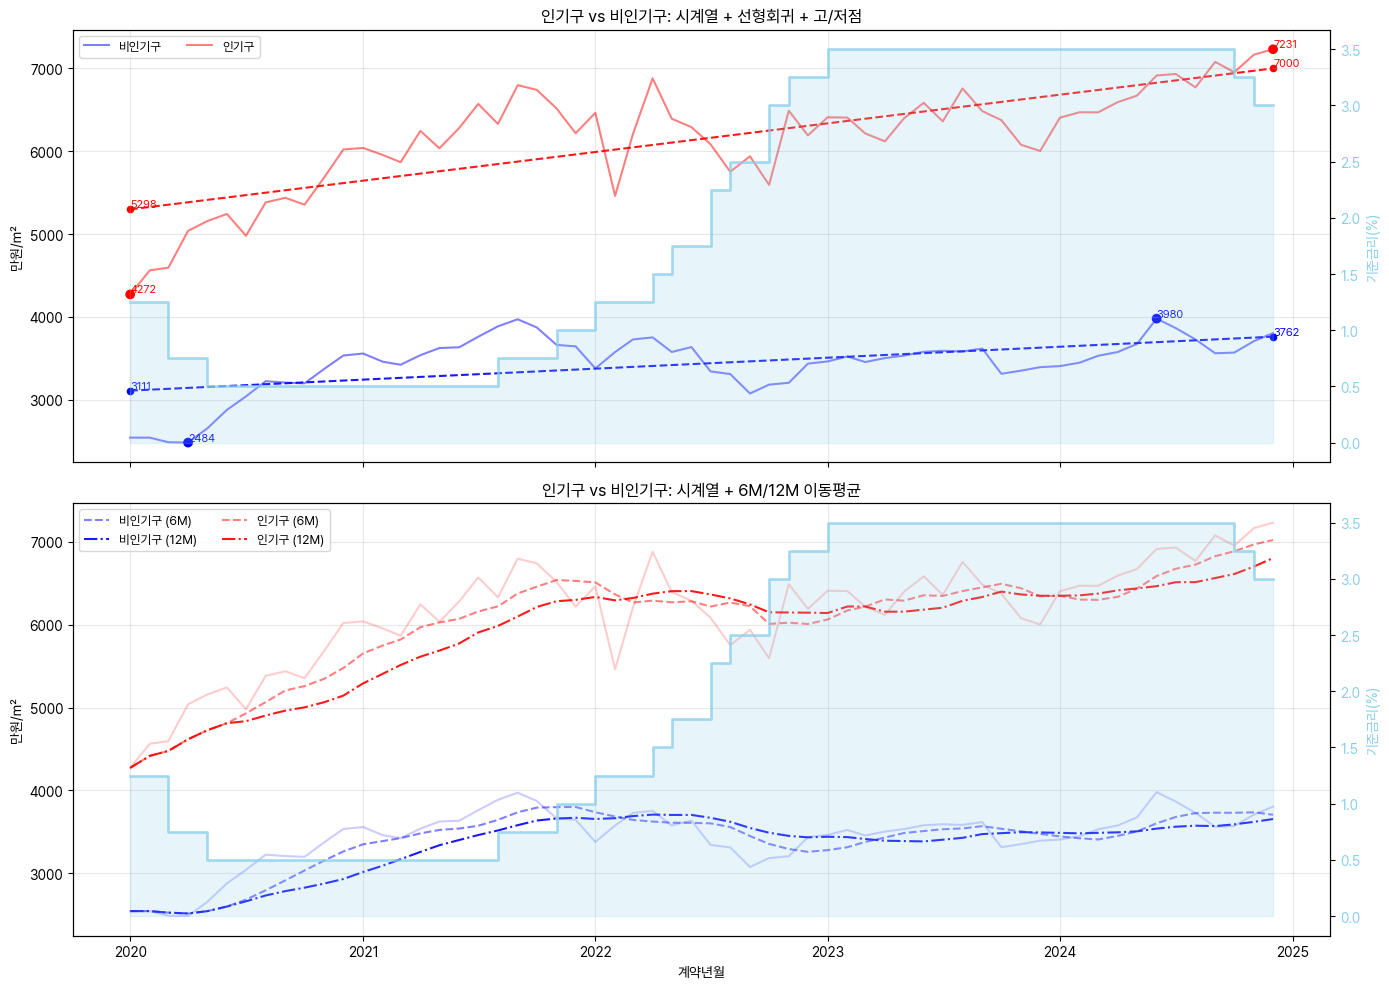

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re

# Í∏∞Ï§Ä Í∏àÎ¶¨ Ìè¨Ìï®
def _parse_kor_mday(s: str):
    m = re.search(r'(\d+)Ïõî\s*(\d+)Ïùº', s)
    return int(m.group(1)), int(m.group(2))

def _rate_series_monthly(rate_csv_path, start_ts, end_ts, align_index):
    r = pd.read_csv(rate_csv_path, dtype={'Î≥ÄÍ≤ΩÎÖÑÎèÑ':int, 'Î≥ÄÍ≤ΩÏõîÏùº':str, 'Í∏∞Ï§ÄÍ∏àÎ¶¨':float})
    r['Ïõî'], r['Ïùº'] = zip(*r['Î≥ÄÍ≤ΩÏõîÏùº'].map(_parse_kor_mday))
    r['Î≥ÄÍ≤ΩÏùº'] = pd.to_datetime(dict(year=r['Î≥ÄÍ≤ΩÎÖÑÎèÑ'], month=r['Ïõî'], day=r['Ïùº']))
    r = r[['Î≥ÄÍ≤ΩÏùº','Í∏∞Ï§ÄÍ∏àÎ¶¨']].sort_values('Î≥ÄÍ≤ΩÏùº')
    idx_end = (pd.date_range(start=start_ts, end=end_ts, freq='MS') + pd.offsets.MonthEnd(0))
    rate = pd.merge_asof(
        pd.DataFrame({'ÏõîÎßê': idx_end}),
        r.rename(columns={'Î≥ÄÍ≤ΩÏùº':'ÏõîÎßê'}).sort_values('ÏõîÎßê'),
        on='ÏõîÎßê', direction='backward'
    )['Í∏∞Ï§ÄÍ∏àÎ¶¨']
    return pd.Series(rate.values, index=align_index)


# Ïõî√óÏù∏Í∏∞Íµ¨(0/1 or 'Ïù∏Í∏∞Íµ¨'/'ÎπÑÏù∏Í∏∞Íµ¨') Ï§ëÏúÑÍ∞í
ts = (
    df_all.groupby(['Í≥ÑÏïΩÎÖÑÏõî','Ïù∏Í∏∞Íµ¨'])['ÌèâÎã®Í∞Ä(ÎßåÏõê)']
          .median().reset_index()
).sort_values('Í≥ÑÏïΩÎÖÑÏõî')

# ÏÉâÏÉÅ Îß§Ìïë
color_map = {1: 'red', 0: 'blue', 'Ïù∏Í∏∞Íµ¨': 'red', 'ÎπÑÏù∏Í∏∞Íµ¨': 'blue'}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

for gval in ts['Ïù∏Í∏∞Íµ¨'].unique():
    sub = ts[ts['Ïù∏Í∏∞Íµ¨'] == gval].copy()
    x_dates = sub['Í≥ÑÏïΩÎÖÑÏõî']
    y = sub['ÌèâÎã®Í∞Ä(ÎßåÏõê)'].values
    label = "Ïù∏Í∏∞Íµ¨" if (gval==1 or gval=="Ïù∏Í∏∞Íµ¨") else "ÎπÑÏù∏Í∏∞Íµ¨"
    base_color = color_map[gval]

    # 1) ÏãúÍ≥ÑÏó¥ + ÏÑ†ÌòïÌöåÍ∑Ä + Í≥†/Ï†ÄÏ†ê ÎùºÎ≤®
    ax1.plot(x_dates, y, color=base_color, alpha=0.5, label=label,)
    # Í≥†Ï†ÄÏ†ê
    i_max = sub['ÌèâÎã®Í∞Ä(ÎßåÏõê)'].idxmax(); x_max = sub.loc[i_max,'Í≥ÑÏïΩÎÖÑÏõî']; y_max = sub.loc[i_max,'ÌèâÎã®Í∞Ä(ÎßåÏõê)']
    i_min = sub['ÌèâÎã®Í∞Ä(ÎßåÏõê)'].idxmin(); x_min = sub.loc[i_min,'Í≥ÑÏïΩÎÖÑÏõî']; y_min = sub.loc[i_min,'ÌèâÎã®Í∞Ä(ÎßåÏõê)']
    ax1.scatter([x_max, x_min], [y_max, y_min], c=[base_color, base_color], marker='o')
    ax1.text(x_max, y_max, f"{y_max:.0f}", color=base_color, fontsize=8, va='bottom')
    ax1.text(x_min, y_min, f"{y_min:.0f}", color=base_color, fontsize=8, va='bottom')
    # ÏÑ†ÌòïÌöåÍ∑Ä Ï∂îÏÑ∏ÏÑ†
    x_num = mdates.date2num(x_dates)
    coeffs = np.polyfit(x_num, y, 1)
    trend = np.polyval(coeffs, x_num)
    ax1.plot(x_dates, trend, linestyle='--', color=base_color, alpha=0.9)
    # Ï∂îÏÑ∏ÏÑ† ÏãúÏûë/ÎÅù ÎùºÎ≤®
    ax1.scatter([x_dates.iloc[0], x_dates.iloc[-1]], [trend[0], trend[-1]], color=base_color, s=20)
    ax1.text(x_dates.iloc[0], trend[0], f"{trend[0]:.0f}", color=base_color, fontsize=8, va='bottom')
    ax1.text(x_dates.iloc[-1], trend[-1], f"{trend[-1]:.0f}", color=base_color, fontsize=8, va='bottom')

    # 2) ÏãúÍ≥ÑÏó¥ + 6M¬∑12M Ïù¥ÎèôÌèâÍ∑†
    ax2.plot(x_dates, y, color=base_color, alpha=0.2)
    roll6  = sub['ÌèâÎã®Í∞Ä(ÎßåÏõê)'].rolling(6,  min_periods=1).mean()
    roll12 = sub['ÌèâÎã®Í∞Ä(ÎßåÏõê)'].rolling(12, min_periods=1).mean()
    ax2.plot(x_dates, roll6,  linestyle='--',  linewidth=1.5, alpha=0.5, color=base_color, label=f"{label} (6M)")
    ax2.plot(x_dates, roll12, linestyle='-.', linewidth=1.5, alpha=0.9, color=base_color, label=f"{label} (12M)")

# ÏÑúÏãù
ax1.set_title("Ïù∏Í∏∞Íµ¨ vs ÎπÑÏù∏Í∏∞Íµ¨: ÏãúÍ≥ÑÏó¥ + ÏÑ†ÌòïÌöåÍ∑Ä + Í≥†/Ï†ÄÏ†ê")
ax1.set_ylabel("ÎßåÏõê/„é°")
ax1.grid(True, alpha=0.3)
ax1.legend(ncol=2, fontsize=9)

ax2.set_title("Ïù∏Í∏∞Íµ¨ vs ÎπÑÏù∏Í∏∞Íµ¨: ÏãúÍ≥ÑÏó¥ + 6M/12M Ïù¥ÎèôÌèâÍ∑†")
ax2.set_xlabel("Í≥ÑÏïΩÎÖÑÏõî"); ax2.set_ylabel("ÎßåÏõê/„é°")
ax2.grid(True, alpha=0.3)
ax2.legend(ncol=2, fontsize=9)

# === Í∏∞Ï§ÄÍ∏àÎ¶¨ ÏãúÎ¶¨Ï¶à ÏÉùÏÑ± ===
start_ts = ts['Í≥ÑÏïΩÎÖÑÏõî'].min()
end_ts   = ts['Í≥ÑÏïΩÎÖÑÏõî'].max()
align_index = ts['Í≥ÑÏïΩÎÖÑÏõî'].drop_duplicates().sort_values()

rate_series = _rate_series_monthly('./interest.csv', start_ts, end_ts, align_index)

# === Î≥¥Ï°∞ yÏ∂ï (Í≥µÌÜµ) ÏÉùÏÑ± ===
for ax in [ax1, ax2]:
    ax_rate = ax.twinx()
    ax_rate.step(rate_series.index, rate_series, where='post', color='skyblue', linewidth=2, alpha=0.7)
    ax_rate.fill_between(rate_series.index, 0, rate_series, step='post', color='skyblue', alpha=0.2)

    # yÏ∂ï Î†àÏù¥Î∏î
    ax_rate.set_ylabel("Í∏∞Ï§ÄÍ∏àÎ¶¨(%)", color='skyblue')
    ax_rate.tick_params(axis='y', labelcolor='skyblue')
    

plt.tight_layout()
plt.show()

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/1354606200.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gg = g.groupby('Ïù∏Í∏∞Íµ¨', group_keys=False).apply(add_metrics)


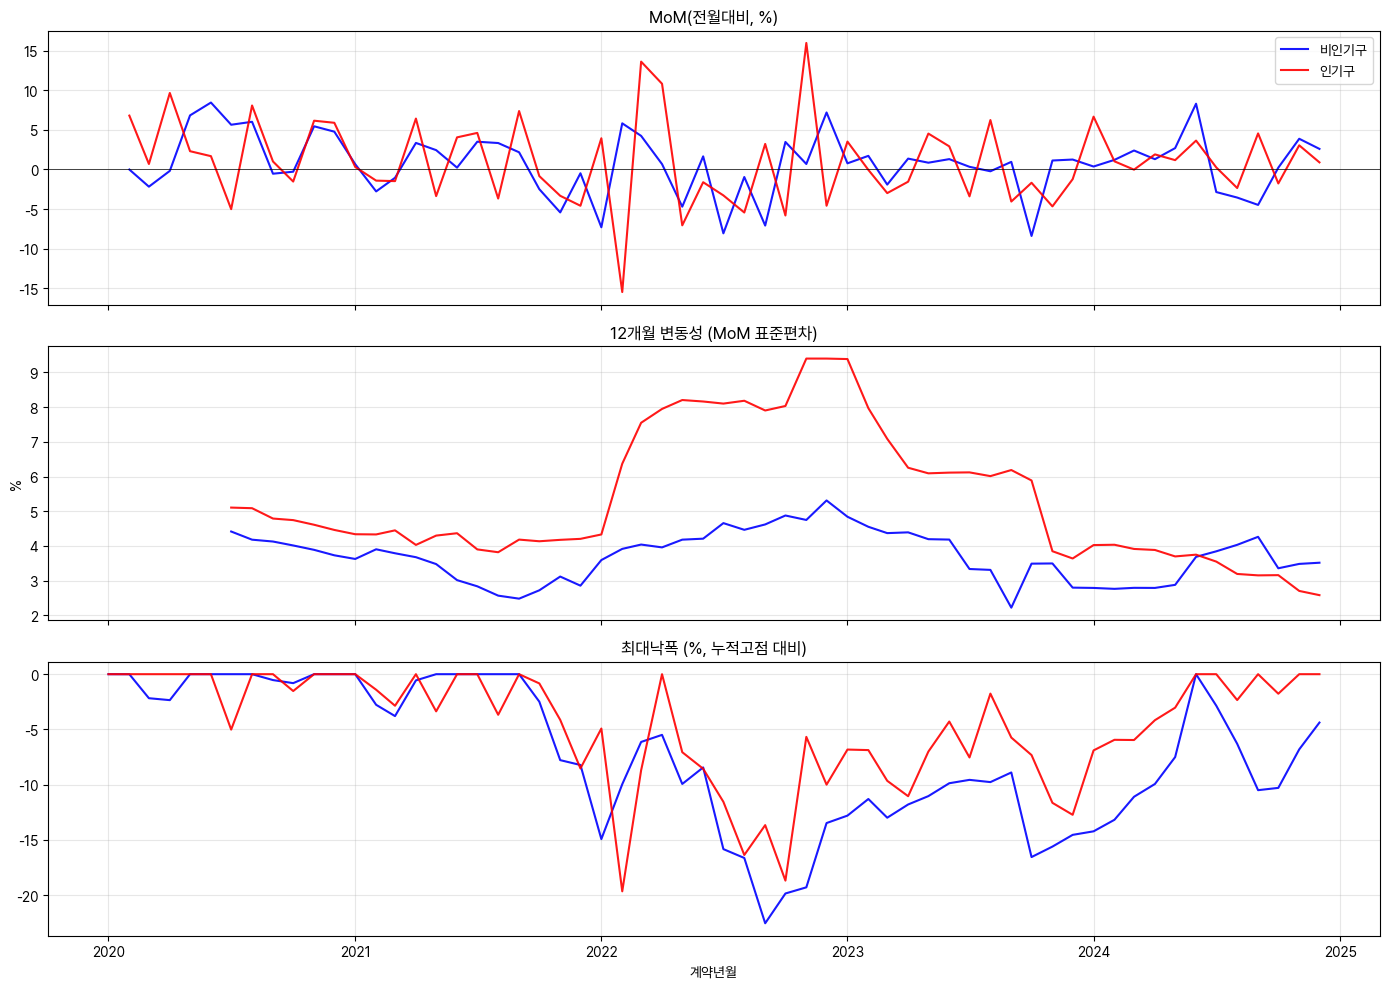

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Ïõî√óÏù∏Í∏∞Íµ¨ Ï§ëÏúÑÍ∞í
g = (df_all.groupby(['Í≥ÑÏïΩÎÖÑÏõî','Ïù∏Í∏∞Íµ¨'])['ÌèâÎã®Í∞Ä(ÎßåÏõê)']
              .median().reset_index()).sort_values('Í≥ÑÏïΩÎÖÑÏõî')

# ÏßëÎã®Î≥Ñ Í≥ÑÏÇ∞ Ìï®Ïàò
def add_metrics(sub):
    sub = sub.sort_values('Í≥ÑÏïΩÎÖÑÏõî').copy()
    sub['MoM'] = sub['ÌèâÎã®Í∞Ä(ÎßåÏõê)'].pct_change() * 100
    sub['YoY'] = sub['ÌèâÎã®Í∞Ä(ÎßåÏõê)'].pct_change(12) * 100
    sub['Vol12M'] = sub['MoM'].rolling(12, min_periods=6).std()      # % Í∏∞Ï§Ä ÌëúÏ§ÄÌé∏Ï∞®
    peak = sub['ÌèâÎã®Í∞Ä(ÎßåÏõê)'].cummax()
    sub['Drawdown'] = sub['ÌèâÎã®Í∞Ä(ÎßåÏõê)']/peak - 1                    # -0.XX (ÎπÑÏú®)
    return sub

gg = g.groupby('Ïù∏Í∏∞Íµ¨', group_keys=False).apply(add_metrics)

# ÏÉâÏÉÅ Í≥†Ï†ï
cmap = {1:'red', 0:'blue', 'Ïù∏Í∏∞Íµ¨':'red', 'ÎπÑÏù∏Í∏∞Íµ¨':'blue'}

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1) MoM (%)
for k, sub in gg.groupby('Ïù∏Í∏∞Íµ¨'):
    axes[0].plot(sub['Í≥ÑÏïΩÎÖÑÏõî'], sub['MoM'], color=cmap.get(k,'gray'), label=('Ïù∏Í∏∞Íµ¨' if k in [1,'Ïù∏Í∏∞Íµ¨'] else 'ÎπÑÏù∏Í∏∞Íµ¨'), alpha=0.9)
axes[0].axhline(0, color='k', lw=0.5); axes[0].set_title('MoM(Ï†ÑÏõîÎåÄÎπÑ, %)'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

# 2) Î≥ÄÎèôÏÑ±: 12M Rolling std of MoM
for k, sub in gg.groupby('Ïù∏Í∏∞Íµ¨'):
    axes[1].plot(sub['Í≥ÑÏïΩÎÖÑÏõî'], sub['Vol12M'], color=cmap.get(k,'gray'), alpha=0.9)
axes[1].set_title('12Í∞úÏõî Î≥ÄÎèôÏÑ± (MoM ÌëúÏ§ÄÌé∏Ï∞®)'); axes[1].set_ylabel('%'); axes[1].grid(True, alpha=0.3)

# 3) ÏµúÎåÄÎÇôÌè≠ (ÎàÑÏ†ÅÍ≥†Ï†ê ÎåÄÎπÑ)
for k, sub in gg.groupby('Ïù∏Í∏∞Íµ¨'):
    axes[2].plot(sub['Í≥ÑÏïΩÎÖÑÏõî'], sub['Drawdown']*100, color=cmap.get(k,'gray'), alpha=0.9)
axes[2].set_title('ÏµúÎåÄÎÇôÌè≠ (%, ÎàÑÏ†ÅÍ≥†Ï†ê ÎåÄÎπÑ)'); axes[2].set_xlabel('Í≥ÑÏïΩÎÖÑÏõî'); axes[2].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

In [13]:
monthly_apt_price_comp  = df_all.groupby(['Í≥ÑÏïΩÎÖÑÏõî','Ïù∏Í∏∞Íµ¨']).agg(
    ÌèâÎã®Í∞Ä=('ÌèâÎã®Í∞Ä(ÎßåÏõê)', 'median'),
    Í±∞ÎûòÎüâ=('ÌèâÎã®Í∞Ä(ÎßåÏõê)', 'size')  # sizeÎäî Ìï¥Îãπ Í∑∏Î£π row Ïàò Ïπ¥Ïö¥Ìä∏
).reset_index()

popular_mask = monthly_apt_price_comp['Ïù∏Í∏∞Íµ¨']=='Ïù∏Í∏∞Íµ¨'

monthly_apt = df_all.groupby(['Í≥ÑÏïΩÎÖÑÏõî','Íµ¨']).agg(
    ÌèâÎã®Í∞Ä=('ÌèâÎã®Í∞Ä(ÎßåÏõê)', 'median'),
    Í±∞ÎûòÎüâ=('ÌèâÎã®Í∞Ä(ÎßåÏõê)', 'size')  # sizeÎäî Ìï¥Îãπ Í∑∏Î£π row Ïàò Ïπ¥Ïö¥Ìä∏
).reset_index()

display(monthly_apt_price_comp.head())

Í≥ÑÏïΩÎÖÑÏõî   Ïù∏Í∏∞Íµ¨      ÌèâÎã®Í∞Ä   Í±∞ÎûòÎüâ
0 2020-01-01  ÎπÑÏù∏Í∏∞Íµ¨  2543.66  5524
1 2020-01-01   Ïù∏Í∏∞Íµ¨  4272.22   959
2 2020-02-01  ÎπÑÏù∏Í∏∞Íµ¨  2543.54  6912
3 2020-02-01   Ïù∏Í∏∞Íµ¨  4563.38  1339
4 2020-03-01  ÎπÑÏù∏Í∏∞Íµ¨  2488.31  3617

In [14]:
# --- ÏßÄÌëú Í≥ÑÏÇ∞ Ìï®Ïàò ---
def calc_metrics(df: pd.DataFrame) -> dict:
    df = df.sort_values("Í≥ÑÏïΩÎÖÑÏõî").copy()

    # CAGR
    start_val, end_val = df["ÌèâÎã®Í∞Ä"].iloc[0], df["ÌèâÎã®Í∞Ä"].iloc[-1]
    n_years = (df["Í≥ÑÏïΩÎÖÑÏõî"].iloc[-1].year - df["Í≥ÑÏïΩÎÖÑÏõî"].iloc[0].year) + \
              (df["Í≥ÑÏïΩÎÖÑÏõî"].iloc[-1].month - df["Í≥ÑÏïΩÎÖÑÏõî"].iloc[0].month)/12
    cagr = (end_val/start_val)**(1/n_years) - 1 if start_val > 0 else np.nan

    # ÏµúÍ∑º 12M YoY ÌèâÍ∑†
    df["YoY"] = df["ÌèâÎã®Í∞Ä"].pct_change(12) * 100
    yoy_mean = df["YoY"].tail(12).mean()

    # Î≥ÄÎèôÏÑ± (Ï†ÑÏ≤¥ Í∏∞Í∞Ñ, ÏõîÍ∞Ñ ÏàòÏùµÎ•† ÌëúÏ§ÄÌé∏Ï∞® √ó ‚àö12)
    df["MoM"] = df["ÌèâÎã®Í∞Ä"].pct_change()
    volatility = df["MoM"].std() * np.sqrt(12) * 100

    # ÏµúÎåÄÎÇôÌè≠ (Drawdown)
    peak = df["ÌèâÎã®Í∞Ä"].cummax()
    drawdown = (df["ÌèâÎã®Í∞Ä"]/peak - 1).min() * 100

    # Í±∞ÎûòÎüâ Ï¶ùÍ∞êÎ•† ÌèâÍ∑† (YoY)
    df["Í±∞ÎûòÎüâÏ¶ùÍ∞êÎ•†"] = df["Í±∞ÎûòÎüâ"].pct_change(12) * 100
    vol_change_mean = df["Í±∞ÎûòÎüâÏ¶ùÍ∞êÎ•†"].mean()

    # ÏàòÏùµ/ÏúÑÌóò ÎπÑÏú® = CAGR / Î≥ÄÎèôÏÑ±
    sharpe_like = (cagr*100) / volatility if volatility > 0 else np.nan

    return {
        "CAGR(%)": round(cagr*100, 2),
        "ÏµúÍ∑º12M YoY ÌèâÍ∑†(%)": round(yoy_mean, 2),
        "Î≥ÄÎèôÏÑ±(Ïó∞Ïú®,%p)": round(volatility, 2),
        "ÏµúÎåÄÎÇôÌè≠(%)": round(drawdown, 2),
        "ÌèâÍ∑† Í±∞ÎûòÎüâ Ï¶ùÍ∞êÎ•†(%)": round(vol_change_mean, 2),
        "ÏàòÏùµ/ÏúÑÌóò ÎπÑÏú®": round(sharpe_like, 2)
    }

# --- ÏßëÍ≥Ñ Ïã§Ìñâ ---
result = []
for g, sub in monthly_apt_price_comp.groupby("Ïù∏Í∏∞Íµ¨"):
    result.append({"Íµ¨Î∂Ñ": g, **calc_metrics(sub)})

summary_table = pd.DataFrame(result).set_index("Íµ¨Î∂Ñ")
summary_table

CAGR(%)  ÏµúÍ∑º12M YoY ÌèâÍ∑†(%)  Î≥ÄÎèôÏÑ±(Ïó∞Ïú®,%p)  ÏµúÎåÄÎÇôÌè≠(%)  ÌèâÍ∑† Í±∞ÎûòÎüâ Ï¶ùÍ∞êÎ•†(%)  ÏàòÏùµ/ÏúÑÌóò ÎπÑÏú®
Íµ¨Î∂Ñ                                                                          
ÎπÑÏù∏Í∏∞Íµ¨     8.54             4.69       13.25   -22.55          42.18      0.64
Ïù∏Í∏∞Íµ¨     11.30             7.31       18.60   -19.66          64.22      0.61

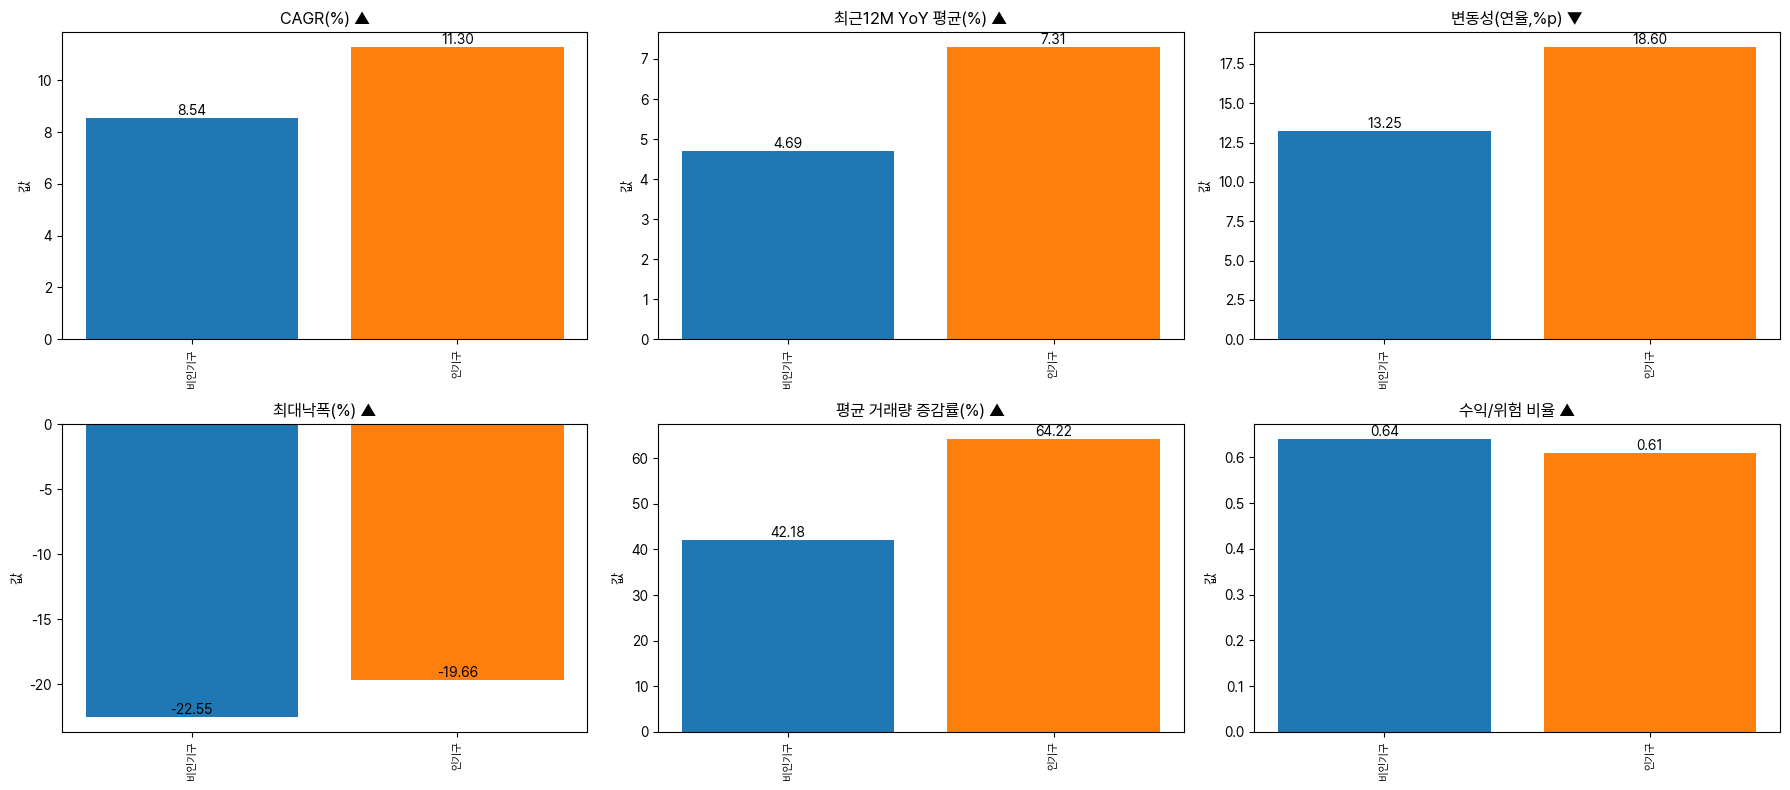

In [15]:
# Î†àÏù¥Î∏îÎ™Ö + Î∞©Ìñ• ÌëúÏãú
labels = {
    "CAGR(%)": "CAGR(%) ‚ñ≤",
    "ÏµúÍ∑º12M YoY ÌèâÍ∑†(%)": "ÏµúÍ∑º12M YoY ÌèâÍ∑†(%) ‚ñ≤",
    "Î≥ÄÎèôÏÑ±(Ïó∞Ïú®,%p)": "Î≥ÄÎèôÏÑ±(Ïó∞Ïú®,%p) ‚ñº",
    "ÏµúÎåÄÎÇôÌè≠(%)": "ÏµúÎåÄÎÇôÌè≠(%) ‚ñ≤",
    "ÌèâÍ∑† Í±∞ÎûòÎüâ Ï¶ùÍ∞êÎ•†(%)": "ÌèâÍ∑† Í±∞ÎûòÎüâ Ï¶ùÍ∞êÎ•†(%) ‚ñ≤",
    "ÏàòÏùµ/ÏúÑÌóò ÎπÑÏú®": "ÏàòÏùµ/ÏúÑÌóò ÎπÑÏú® ‚ñ≤"
}

# ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate([c for c in summary_table.columns if c != "ÏãúÏû•Îß§Î†•ÎèÑ"]):
    ax = axes[i]
    values = summary_table[col].copy()

    # Í±∞ÎûòÎüâ Ï¶ùÍ∞êÎ•†ÏùÄ Í∑∏ÎûòÌîÑÎäî ÏñëÏàòÌôî
    if col == "ÌèâÍ∑† Í±∞ÎûòÎüâ Ï¶ùÍ∞êÎ•†(%)":
        plot_vals = values.abs()
    else:
        plot_vals = values

    bars = ax.bar(summary_table.index, plot_vals, color=["#1f77b4", "#ff7f0e"])
    
    # Í∞Å Í∞í ÌëúÏãú (ÏõêÎûò Í∞í Ïú†ÏßÄ)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, 
                bar.get_height(), 
                f"{val:.2f}", 
                ha='center', va='bottom')

    ax.set_title(labels[col])
    ax.set_ylabel("Í∞í")
    ax.set_xticklabels(summary_table.index, rotation=90, fontsize=8)
    

plt.tight_layout()
plt.show()

In [16]:
def market_attractiveness(df: pd.DataFrame, mode="investor") -> pd.Series:
    df = df.copy()

    # 0~1 Ïä§ÏºÄÏùºÌôî
    df["CAGR_norm"] = df["CAGR(%)"] / 100
    df["YoY_norm"] = df["ÏµúÍ∑º12M YoY ÌèâÍ∑†(%)"] / 100
    df["Í±∞ÎûòÎüâ_norm"] = df["ÌèâÍ∑† Í±∞ÎûòÎüâ Ï¶ùÍ∞êÎ•†(%)"] / 100
    df["Sharpe_norm"] = df["ÏàòÏùµ/ÏúÑÌóò ÎπÑÏú®"] / df["ÏàòÏùµ/ÏúÑÌóò ÎπÑÏú®"].max()
    df["Drawdown_norm"] = abs(df["ÏµúÎåÄÎÇôÌè≠(%)"]) / 100
    df["Volatility_norm"] = df["Î≥ÄÎèôÏÑ±(Ïó∞Ïú®,%p)"] / 100

    if mode == "investor":
        weights = {
            "CAGR_norm": 0.3,
            "YoY_norm": 0.2,
            "Í±∞ÎûòÎüâ_norm": 0.1,
            "Sharpe_norm": 0.25,
            "Drawdown_norm": -0.1,
            "Volatility_norm": -0.05,
        }
    elif mode == "policy":
        weights = {
            "CAGR_norm": 0.15,
            "YoY_norm": 0.1,
            "Í±∞ÎûòÎüâ_norm": 0.25,
            "Sharpe_norm": 0.1,
            "Drawdown_norm": -0.2,
            "Volatility_norm": -0.2,
        }
    else:
        raise ValueError("mode must be 'investor' or 'policy'")

    score = sum(df[k] * v for k, v in weights.items())
    return score.round(3)

# ÏÇ¨Ïö© ÏòàÏãú
summary_table["Îß§Î†•ÎèÑ(Ìà¨ÏûêÏûê)"] = market_attractiveness(summary_table, mode="investor")
summary_table["Îß§Î†•ÎèÑ(Ï†ïÏ±ÖÏûê)"] = market_attractiveness(summary_table, mode="policy")
summary_table

CAGR(%)  ÏµúÍ∑º12M YoY ÌèâÍ∑†(%)  Î≥ÄÎèôÏÑ±(Ïó∞Ïú®,%p)  ÏµúÎåÄÎÇôÌè≠(%)  ÌèâÍ∑† Í±∞ÎûòÎüâ Ï¶ùÍ∞êÎ•†(%)  ÏàòÏùµ/ÏúÑÌóò ÎπÑÏú®  \
Íµ¨Î∂Ñ                                                                             
ÎπÑÏù∏Í∏∞Íµ¨     8.54             4.69       13.25   -22.55          42.18      0.64   
Ïù∏Í∏∞Íµ¨     11.30             7.31       18.60   -19.66          64.22      0.61   

      Îß§Î†•ÎèÑ(Ìà¨ÏûêÏûê)  Îß§Î†•ÎèÑ(Ï†ïÏ±ÖÏûê)  
Íµ¨Î∂Ñ                        
ÎπÑÏù∏Í∏∞Íµ¨     0.298     0.151  
Ïù∏Í∏∞Íµ¨      0.322     0.204

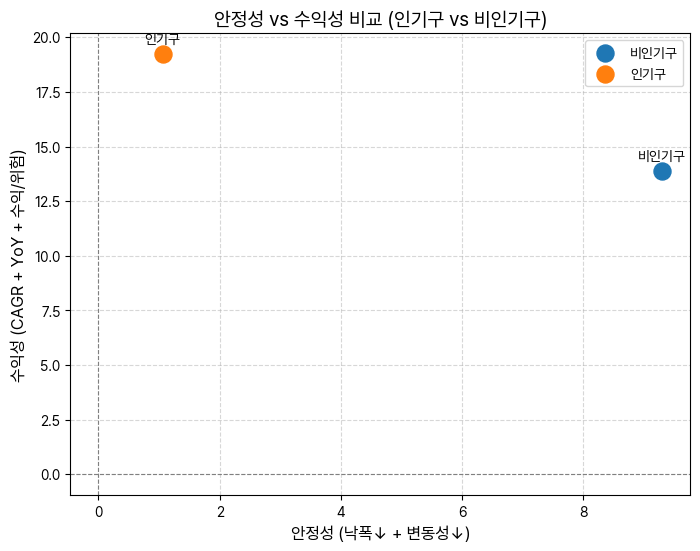

In [17]:
import matplotlib.pyplot as plt

# --- ÏïàÏ†ïÏÑ±, ÏàòÏùµÏÑ± ÏßÄÌëú Ìï©ÏÇ∞ ---
summary_comp = summary_table.copy()

summary_comp["ÏïàÏ†ïÏÑ±"] = (-summary_comp["ÏµúÎåÄÎÇôÌè≠(%)"]) + (-summary_comp["Î≥ÄÎèôÏÑ±(Ïó∞Ïú®,%p)"])
summary_comp["ÏàòÏùµÏÑ±"] = summary_comp["CAGR(%)"] + summary_comp["ÏµúÍ∑º12M YoY ÌèâÍ∑†(%)"] + summary_comp["ÏàòÏùµ/ÏúÑÌóò ÎπÑÏú®"]

# --- Ïä§Ï∫êÌÑ∞ ÏãúÍ∞ÅÌôî ---
plt.figure(figsize=(8,6))
for idx, row in summary_comp.iterrows():
    plt.scatter(row["ÏïàÏ†ïÏÑ±"], row["ÏàòÏùµÏÑ±"], label=idx, s=150)
    plt.text(row["ÏïàÏ†ïÏÑ±"], row["ÏàòÏùµÏÑ±"]+0.5, idx, ha='center')

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

plt.title("ÏïàÏ†ïÏÑ± vs ÏàòÏùµÏÑ± ÎπÑÍµê (Ïù∏Í∏∞Íµ¨ vs ÎπÑÏù∏Í∏∞Íµ¨)", fontsize=14)
plt.xlabel("ÏïàÏ†ïÏÑ± (ÎÇôÌè≠‚Üì + Î≥ÄÎèôÏÑ±‚Üì)", fontsize=12)
plt.ylabel("ÏàòÏùµÏÑ± (CAGR + YoY + ÏàòÏùµ/ÏúÑÌóò)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### `2022ÎÖÑ Í∏âÍ≤©Ìïú Î∂ÄÎèôÏÇ∞ Í∞ÄÍ≤© Î≥ÄÌôî`

ÏöîÏïΩ:
2022ÎÖÑ ÏÉÅÎ∞òÍ∏∞ ÏÑúÏö∏¬∑ÏàòÎèÑÍ∂å ÏïÑÌååÌä∏ ÌèâÎã®Í∞Ä ÏÉÅÏäπ Ï∂îÏÑ∏Í∞Ä ÏùºÏãú ÏÜåÌè≠ ÌõÑÌá¥Ìïú Ï£ºÎêú ÏõêÏù∏ÏùÄ ‚ÄúÌïúÍµ≠ÏùÄÌñâÏùò Í≥µÍ≤©Ï†Å Í∏∞Ï§ÄÍ∏àÎ¶¨ Ïù∏ÏÉÅ‚ÄùÍ≥º ‚ÄúDSR/LTV ÎåÄÏ∂ú Í∑úÏ†ú Í∞ïÌôî‚ÄùÍ∞Ä Ïã§ÏàòÏöî¬∑Ìà¨Ïûê ÏàòÏöîÎ•º Îπ†Î•¥Í≤å ÏúÑÏ∂ïÏãúÏº∞Í∏∞ ÎïåÎ¨∏ÏûÖÎãàÎã§. Ïó¨Í∏∞Ïóê ‚ÄúÍ≥µÍ∏âÎ∂ÄÏ°± Ïö∞Î†§ ÏôÑÌôî Ï°∞Ïπò‚Äù Îì±Ïù¥ Î≥µÌï© ÏûëÏö©ÌïòÎ©¥ÏÑú Îß§Ïàò Í¥ÄÎßùÏÑ∏Í∞Ä Ïã¨ÌôîÎêòÏóàÏäµÎãàÎã§.

---

1. ÌïúÍµ≠ÏùÄÌñâ Í∏∞Ï§ÄÍ∏àÎ¶¨Ïùò Í∏âÍ≤©Ìïú Ïù∏ÏÉÅ
	- 2022ÎÖÑ 1Ïõî(1.25 %)‚Üí4Ïõî(1.50 %)‚Üí5Ïõî(1.75 %)‚Üí7Ïõî(2.25 %)‚Üí8Ïõî(2.50 %)ÍπåÏßÄ Îã§ÏÑØ Ï∞®Î°Ä Ïù∏ÏÉÅÌïòÎ©∞ 2011ÎÖÑ Ïù¥ÌõÑ ÏµúÍ≥† ÏàòÏ§ÄÏúºÎ°ú Ïò¨Î†∏Îã§  Ôøº.
	- Ï∞®ÏûÖ ÎπÑÏö© Í∏âÎì±ÏúºÎ°ú Ï£ºÌÉùÎã¥Î≥¥ÎåÄÏ∂ú Í∏àÎ¶¨Í∞Ä ÌÅ¨Í≤å ÏÉÅÏäπÌïòÏûê Îß§Ïàò Ïã¨Î¶¨Í∞Ä Ï¶âÍ∞Å ÏúÑÏ∂ïÎêêÎã§  Ôøº.

2. ÎåÄÏ∂ú Í∑úÏ†ú Í∞ïÌôî (DSR¬∑LTV)
	- 2022ÎÖÑ 1ÏõîÎ∂ÄÌÑ∞ DSR(Ï¥ùÎ∂ÄÏ±ÑÏõêÎ¶¨Í∏àÏÉÅÌôòÎπÑÏú®) Ï†ÅÏö© ÎåÄÏÉÅÏùò Ï¥ùÎåÄÏ∂úÏï° Í∏∞Ï§ÄÏù¥ 2Ïñµ‚Üí7Ïõî 1ÏñµÏúºÎ°ú Í∞ïÌôîÎèº ÎåÄÏ∂ú ÌïúÎèÑÍ∞Ä ÌÅ∞ Ìè≠ Ï∂ïÏÜåÎêêÎã§  Ôøº.
	- 2021ÎÖÑ ÌïòÎ∞òÍ∏∞Î∂ÄÌÑ∞ Îã®Í≥Ñ Ï†ÅÏö©Îêú DSR Í∞ïÌôîÍ∞Ä 2022ÎÖÑ 7ÏõîÍπåÏßÄ Ï¥ù ÏÑ∏ Ï∞®Î°ÄÏóê Í±∏Ï≥ê Ïù¥Î£®Ïñ¥Ï°åÍ≥†, Ïù¥ Í∏∞Í∞Ñ ÏÑúÏö∏ ÏïÑÌååÌä∏ Îß§Îß§Í∞ÄÍ≤© ÏÉÅÏäπÎ•†Ïù¥ Îã®Í≥Ñ Í∞ïÌôî ÏãúÍ∏∞ÎßàÎã§ ÎëîÌôîÎêêÎã§  Ôøº.

3. Ï†ïÎ∂ÄÏùò ÏãúÏû• ÏïàÏ†ïÌôî ÎåÄÏ±Ö
	- 2022ÎÖÑ 6Ïõî 28Ïùº Î∞úÌëúÌïú **‚ÄòÎ∂ÄÎèôÏÇ∞ Ï†ïÏ±ÖÎ∞©Ìñ•‚Äô** ÏóêÏÑú Ï†ÑÏõîÏÑ∏ ÏÑ∏Ïï°Í≥µÏ†ú ÌôïÎåÄ, Í∑úÏ†úÏßÄÏó≠ Ï†ÑÏûÖÏùòÎ¨¥ ÌèêÏßÄ Îì± Ï£ºÌÉù Í≥µÍ∏â¬∑ÏûÑÎåÄ ÏßÄÏõêÏ±ÖÏùÑ ÎÇ¥ÎÜìÏïÑ Ïû†Ïãú Îß§Ïàò Í¥ÄÎßùÏùÑ Ïã¨ÌôîÏãúÏº∞Îã§  Ôøº.
	- LH ÌÜ†ÏßÄÏ£ºÌÉùÏó∞Íµ¨ÏõêÏùÄ ‚Äú2021ÎÖÑ ÌïòÎ∞òÍ∏∞ Í∏àÏúµÍ∂å ÎåÄÏ∂úÍ∑úÏ†úÏôÄ Í∏àÎ¶¨ Ïù∏ÏÉÅ Ïó¨ÌååÎ°ú 2022ÎÖÑ ÏÉÅÎ∞òÍ∏∞ÍπåÏßÄ ÏïΩÎ≥¥Ìï©ÏÑ∏Î•º Í∏∞Î°ù‚ÄùÌñàÎã§Í≥† Î∂ÑÏÑùÌñàÎã§  Ôøº.

4. ÏãúÏû• Ïã¨Î¶¨ Î∞è ÏàòÏöî Í¥ÄÎßù
	- KDI Î≥¥Í≥†ÏÑúÎäî ‚ÄúÏàòÎèÑÍ∂å Ï£ºÌÉùÍ∞ÄÍ≤©ÏßÄÏàòÎäî 2Î∂ÑÍ∏∞(2022 Q2) Ï†ÑÎ∂ÑÍ∏∞ ÎåÄÎπÑ 0.05% ÌïòÎùΩÌïòÎ©∞ Îß§Ïàò Í¥ÄÎßùÏÑ∏Í∞Ä Ïã¨ÌôîÎêêÎã§‚ÄùÍ≥† Ï†ÑÌñàÎã§  Ôøº.
	- Î∂ÄÎèôÏÇ∞R114 ÏÑ§Î¨∏ Ï°∞ÏÇ¨ÏóêÏÑú **Ï†àÎ∞ò Ïù¥ÏÉÅ(50 %)** Í∞Ä ‚ÄúÎåÄÏ∂ú Í∑úÏ†ú¬∑Í∏àÎ¶¨ Ïù∏ÏÉÅÏúºÎ°ú Îß§ÏàòÏÑ∏Í∞Ä ÏïÖÌôîÎê† Í≤É‚ÄùÏù¥Îùº ÎãµÌï¥ ÏàòÏöî ÏúÑÏ∂ï Í∏∞ÎåÄÍ∞Ä ÎöúÎ†∑Ìï¥Ï°åÎã§  Ôøº.
	- K-REMAP ÏßÄÏàò Îì± ÏÜåÎπÑÏûê Ïã¨Î¶¨ÏßÄÌëúÎèÑ 2022ÎÖÑ ÏÉÅÎ∞òÍ∏∞ Îì§Ïñ¥ ÌÅ¨Í≤å ÌïòÎùΩÌïòÎ©∞ Îß§Îß§¬∑Ï†ÑÏÑ∏ Î™®Îëê ‚ÄòÍ¥ÄÎßù‚Äô ÏßÄÌëúÎ•º Í∏∞Î°ùÌñàÎã§  Ôøº.

---

Í≤∞Î°†
> 	- Í∏àÎ¶¨ Ïù∏ÏÉÅÍ≥º DSR Í∞ïÌôîÍ∞Ä ÌïµÏã¨.
>	- Ï†ïÎ∂Ä ÏßÄÏõêÏ±Ö Î∞úÌëúÎ°ú Îß§Ïàò Í¥ÄÎßù Ïã¨Ìôî.
>	- ÏàòÏöî Ïã¨Î¶¨ Ï†ÄÌïòÍ∞Ä ÏãúÏû• Ï°∞Ï†ï Í∏∞Í∞ÑÏùÑ Ïó∞Ïû•ÏãúÏº∞Îã§.

Ïù¥ ÎÑ§ Í∞ÄÏßÄ Íµ≠ÎÇ¥ ÏöîÏù∏Ïù¥ Î≥µÌï©Ï†ÅÏúºÎ°ú ÏûëÏö©Ìï¥ 2022ÎÖÑ ÏÉÅÎ∞òÍ∏∞ ÏÉÅÏäπ Ï∂îÏÑ∏Í∞Ä ÏùºÏãú ÌùîÎì§Î¶∞ Îí§, ÌïòÎ∞òÍ∏∞ Îì§Ïñ¥ Îã§Ïãú ÏÉÅÏäπ ÌùêÎ¶ÑÏúºÎ°ú Ï†ÑÌôòÎêòÏóàÏäµÎãàÎã§.

---

Ï∞∏Í≥† Î¨∏Ìóå
1. ÌïúÍµ≠ÏùÄÌñâ Í∏∞Ï§ÄÍ∏àÎ¶¨ Ï∂îÏù¥  Ôøº
2.	Í∏àÌÜµÏúÑ ‚ÄòÏà® Í≥†Î•¥Í∏∞‚Äô ÎèôÍ≤∞ Î∞∞Í≤Ω  Ôøº
3.	DSR Í∑úÏ†ú Í∞ïÌôî Î∞©Ïïà  Ôøº
4.	DSR Îã®Í≥ÑÎ≥Ñ Ï†ÅÏö© Ìö®Í≥º  Ôøº
5.	2022ÎÖÑ Î∂ÄÎèôÏÇ∞ Ï†ïÏ±ÖÎ∞©Ìñ•(MOEF)  Ôøº
6.	LH Ï£ºÌÉùÏãúÏû• ÎèôÌñ• Î∂ÑÏÑù  Ôøº
7.	KDI 2022ÎÖÑ 2/4Î∂ÑÍ∏∞ Î∂ÄÎèôÏÇ∞ ÎèôÌñ•  Ôøº
8.	Î∂ÄÎèôÏÇ∞R114 ÏàòÏöî Ï†ÑÎßù  Ôøº
9.	K-REMAP ÏãúÏû• Ïã¨Î¶¨ÏßÄÌëú  Ôøº
10.	MOEF Ï†ïÎ∂Ä ÎåÄÏ±Ö Î∞úÌëú(6/28)  Ôøº

# 2Î≤à Í≥ºÏ†ú

### Í∑úÎ™®Íµ¨Î∂Ñ Ïª¨Îüº Ï∂îÍ∞Ä

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/737050573.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = getattr(dfc.groupby(['ÎÖÑÏõî', size_col])[price_col], agg_func)().reset_index()


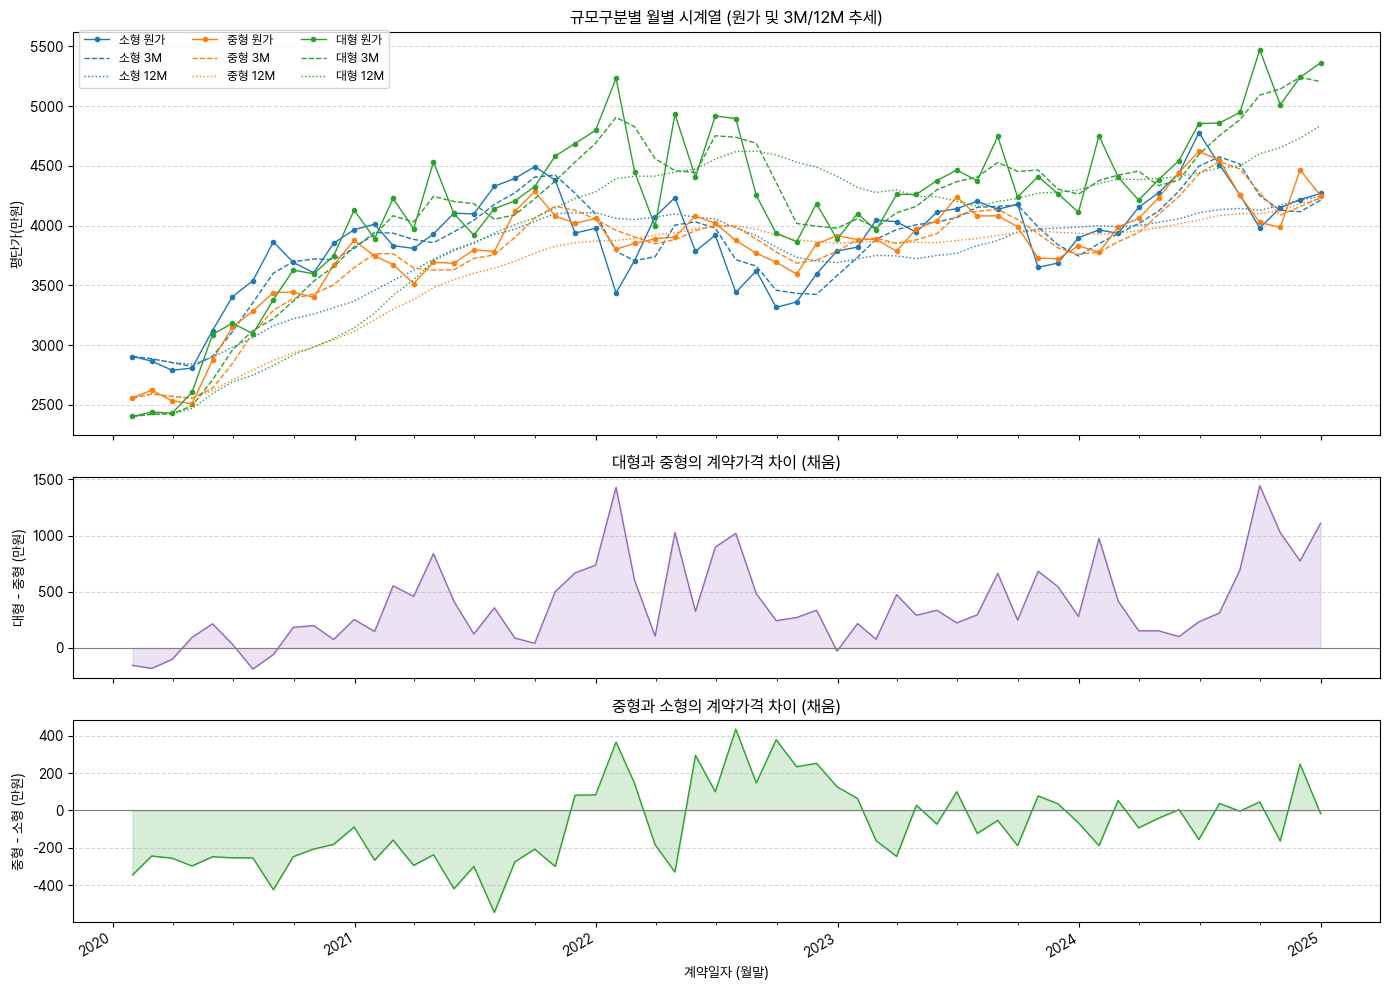

In [18]:
import matplotlib.dates as mdates

def plot_size_trends_subplots(df,
                              date_col='Í≥ÑÏïΩÏùºÏûê',
                              size_col='Í∑úÎ™®Íµ¨Î∂Ñ',
                              price_col='ÌèâÎã®Í∞Ä(ÎßåÏõê)',
                              agg_func='median'):
    """
    1) Ï†ÑÏ≤¥(ÏÜå/Ï§ë/ÎåÄ) ÏõîÎ≥Ñ ÏãúÍ≥ÑÏó¥ + 3M/12M Ï∂îÏÑ∏
    2) ÎåÄÌòï - Ï§ëÌòï Ï∞®Ïù¥ (Ï±ÑÏõÄ, Ï∂îÏÑ∏ÏÑ† ÏóÜÏùå)
    3) Ï§ëÌòï - ÏÜåÌòï Ï∞®Ïù¥ (Ï±ÑÏõÄ, Ï∂îÏÑ∏ÏÑ† ÏóÜÏùå)
    """
    dfc = df.copy()
    dfc[date_col] = pd.to_datetime(dfc[date_col])
    # ÏõîÎßê Ïù∏Îç±Ïä§
    dfc['ÎÖÑÏõî'] = dfc[date_col].dt.to_period('M').dt.to_timestamp('M')
    agg = getattr(dfc.groupby(['ÎÖÑÏõî', size_col])[price_col], agg_func)().reset_index()
    ts = agg.pivot(index='ÎÖÑÏõî', columns=size_col, values=price_col).sort_index()

    # Í∏∞ÎåÄÌïòÎäî Ïª¨ÎüºÎ™Ö Ï≤¥ÌÅ¨
    expected = ['ÏÜåÌòï','Ï§ëÌòï','ÎåÄÌòï']
    missing = [c for c in expected if c not in ts.columns]
    if missing:
        raise ValueError(f"Í∑úÎ™®Íµ¨Î∂Ñ Ïª¨ÎüºÏóê Îã§Ïùå Î†àÏù¥Î∏îÏù¥ ÌïÑÏöîÌï©ÎãàÎã§: {expected}. ÎàÑÎùΩ: {missing}")

    ma3  = ts.rolling(window=3, min_periods=1).mean()
    ma12 = ts.rolling(window=12, min_periods=1).mean()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,10), sharex=True, gridspec_kw={'height_ratios':[2,1,1]})

    cmap = plt.get_cmap('tab10')
    colors = {'ÏÜåÌòï': cmap(0), 'Ï§ëÌòï': cmap(1), 'ÎåÄÌòï': cmap(2)}

    # 1) ÏàòÏ§Ä + Ï∂îÏÑ∏
    for i, col in enumerate(['ÏÜåÌòï','Ï§ëÌòï','ÎåÄÌòï']):
        ax1.plot(ts.index, ts[col], marker='.', linewidth=1, label=f'{col} ÏõêÍ∞Ä', color=colors[col])
        ax1.plot(ma3.index, ma3[col], linestyle='--', linewidth=1, label=f'{col} 3M', color=colors[col])
        ax1.plot(ma12.index, ma12[col], linestyle=':', linewidth=1, label=f'{col} 12M', color=colors[col])
    ax1.set_ylabel(price_col)
    ax1.set_title('Í∑úÎ™®Íµ¨Î∂ÑÎ≥Ñ ÏõîÎ≥Ñ ÏãúÍ≥ÑÏó¥ (ÏõêÍ∞Ä Î∞è 3M/12M Ï∂îÏÑ∏)')
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    # Î≤îÎ°Ä Ï§ëÎ≥µ Ï†úÍ±∞
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), ncol=3, fontsize=9, loc='upper left', bbox_to_anchor=(0,1.02))

    # 2) ÎåÄÌòï - Ï§ëÌòï Ï∞®Ïù¥ (Ï±ÑÏõÄ)
    diff_lm = ts['ÎåÄÌòï'] - ts['Ï§ëÌòï']
    ax2.plot(diff_lm.index, diff_lm.values, color='tab:purple', linewidth=1)
    ax2.fill_between(diff_lm.index, 0, diff_lm.values, where=~pd.isna(diff_lm.values),
                     interpolate=True, color='tab:purple', alpha=0.18)
    ax2.axhline(0, color='gray', linewidth=0.8)
    ax2.set_ylabel('ÎåÄÌòï - Ï§ëÌòï (ÎßåÏõê)')
    ax2.set_title('ÎåÄÌòïÍ≥º Ï§ëÌòïÏùò Í≥ÑÏïΩÍ∞ÄÍ≤© Ï∞®Ïù¥ (Ï±ÑÏõÄ)')
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    # 3) Ï§ëÌòï - ÏÜåÌòï Ï∞®Ïù¥ (Ï±ÑÏõÄ)
    diff_ms = ts['Ï§ëÌòï'] - ts['ÏÜåÌòï']
    ax3.plot(diff_ms.index, diff_ms.values, color='tab:green', linewidth=1)
    ax3.fill_between(diff_ms.index, 0, diff_ms.values, where=~pd.isna(diff_ms.values),
                     interpolate=True, color='tab:green', alpha=0.18)
    ax3.axhline(0, color='gray', linewidth=0.8)
    ax3.set_ylabel('Ï§ëÌòï - ÏÜåÌòï (ÎßåÏõê)')
    ax3.set_title('Ï§ëÌòïÍ≥º ÏÜåÌòïÏùò Í≥ÑÏïΩÍ∞ÄÍ≤© Ï∞®Ïù¥ (Ï±ÑÏõÄ)')
    ax3.grid(axis='y', linestyle='--', alpha=0.5)

    # xÏ∂ï Ìè¨Îß∑ (Ïó∞ÎèÑ ÎùºÎ≤®)
    ax3.xaxis.set_major_locator(mdates.YearLocator())
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax3.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
    fig.autofmt_xdate()
    ax3.set_xlabel('Í≥ÑÏïΩÏùºÏûê (ÏõîÎßê)')

    plt.tight_layout()
    plt.show()
plot_size_trends_subplots(df_all)

ÏÉùÏï†Ï£ºÍ∏∞Î≥Ñ ÏïÑÌååÌä∏ Í∑úÎ™® Ï†ÑÎûµ Î≥¥Í≥†ÏÑú

(Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò ÏöîÏïΩ ¬∑ 2020‚Äì2024 ÏãúÍ≥ÑÏó¥ Î∂ÑÏÑù Í∏∞Ï§Ä)

---

1. ÏöîÏïΩ Í≤∞Î°†
	‚Ä¢	Í∏àÎ¶¨ ÎØºÍ∞êÎèÑ: ÎåÄÌòï > Ï§ëÌòï > ÏÜåÌòï. Í∏àÎ¶¨ ÏÉÅÏäπÍ∏∞ÏóêÎäî ÎåÄÌòïÏùò ÎÇôÌè≠Ïù¥ Í∞ÄÏû• ÌÅ¨Í≥† ÌöåÎ≥µ Ïó≠Ïãú Îπ†Î¶Ñ.
	‚Ä¢	Í∑úÎ™®Î≥Ñ ÌäπÏÑ±: ÎåÄÌòïÏùÄ Ïû•Í∏∞Ï†Å ÌîÑÎ¶¨ÎØ∏ÏóÑ Î∞è Î≥ÄÎèôÏÑ±, Ï§ëÌòïÏùÄ ÏïàÏ†ïÏ†Å ÏôÑÏ∂© Ïó≠Ìï†, ÏÜåÌòïÏùÄ Ïú†ÎèôÏÑ±¬∑ÏûÑÎåÄÏàòÏöî Í∏∞Î∞òÏùò Î∞©Ïñ¥Î†• Î≥¥Ïú†.
	‚Ä¢	Ï†ïÏ±Ö(Í∏àÎ¶¨) Ïó∞Í≥Ñ Ïù∏ÏÇ¨Ïù¥Ìä∏: 2021ÌõÑÎ∞ò~2022 Ïó∞ÏÜç Í∏àÎ¶¨ Ïù∏ÏÉÅ Íµ¨Í∞ÑÏóêÏÑú ÎåÄÌòï ÏÑ†Ìñâ ÌïòÎùΩ¬∑Í≤©Ï∞® ÏùºÏãú Ï∂ïÏÜå, 2023 Ïù¥ÌõÑ Í∏àÎ¶¨ Ï†ïÏ≤¥¬∑ÏôÑÌôî Í∏∞ÎåÄ Íµ≠Î©¥ÏóêÏÑú ÎåÄÌòï ÏÑ†Ìñâ ÌöåÎ≥µ Î∞è Í≤©Ï∞® Ïû¨ÌôïÎåÄ Í¥ÄÏ∞∞.

---

2. Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò Í¥ÄÏ∞∞ (ÌïµÏã¨ Ìè¨Ïù∏Ìä∏)
	‚Ä¢	ÏõîÎ≥Ñ ÏõêÍ∞Ä Î∞è 3M/12M Ïù¥ÎèôÌèâÍ∑† Î∂ÑÏÑù Í≤∞Í≥º:
	‚Ä¢	ÎåÄÌòï: ÌèâÍ∑† ÏàòÏ§Ä Í∞ÄÏû• ÎÜíÍ≥†, 3M MAÏùò Î≥ÄÎèôÏÑ±Ïù¥ ÌÅº. ÎåÄÌòï‚àíÏ§ëÌòï Ï∞®Ïù¥Îäî ÎåÄÏ≤¥Î°ú ÏñëÏàòÏù¥Î©∞ 2020‚Üí2024 Í∏∞Í∞ÑÏóê ÌôïÏû• Í≤ΩÌñ•.
	‚Ä¢	Ï§ëÌòï: ÏàòÏ§ÄÍ≥º ÏßÄÏàòÏóêÏÑú Ï§ëÎ¶ΩÏ†Å ÏúÑÏπò. 12M MAÍ∞Ä Îß§ÎÅÑÎü¨Ïõå Î∞©Ïñ¥Ï†Å ÏÑ±Í≤©Ïù¥ ÎöúÎ†∑Ìï®.
	‚Ä¢	ÏÜåÌòï: Ï§ëÌòï ÎåÄÎπÑ ÏÉÅÎåÄÏ†Å Í≤¨Ï°∞ ÎòêÎäî Ï¥àÍ≥º ÏàòÏöî Íµ¨Í∞Ñ Ï°¥Ïû¨. Ïú†ÎèôÏÑ±¬∑ÏûÑÎåÄ ÏàòÏöîÏóê Í∞ïÌï®.
	‚Ä¢	Ï∞®Ïù¥(ÎåÄÌòï‚àíÏ§ëÌòï, Ï§ëÌòï‚àíÏÜåÌòï) ÏãúÍ≥ÑÏó¥:
	‚Ä¢	ÎåÄÌòï ÌîÑÎ¶¨ÎØ∏ÏóÑ(ÎåÄÌòï‚àíÏ§ëÌòï)Ïù¥ ÌôïÎåÄÎêú Íµ¨Í∞ÑÏóêÏÑú Ïû•Í∏∞ ÏûêÎ≥∏ Ïù¥Îìù Í∞ÄÎä•ÏÑ± ÎÜíÏùå.
	‚Ä¢	Ï§ëÌòï‚àíÏÜåÌòï Ï∞®Ïù¥Í∞Ä ÏùåÏàòÎ°ú ÏßÄÏÜçÎêòÎäî Íµ¨Í∞ÑÏùÄ ÏÜåÌòïÏùò ÏÉÅÎåÄ Í∞ïÏÑ∏Î•º ÏùòÎØ∏.

---

3. ÏÉùÏï†Ï£ºÍ∏∞Î≥Ñ Í∂åÏû• Ï†ÑÎûµ (Ï†ïÏ±Ö¬∑Í∏àÎ¶¨ Îß•ÎùΩ Ìè¨Ìï®)

A. Ï¥àÍ∏∞(20ÎåÄ¬∑Ïã±Í∏Ä, Ïú†ÎèôÏÑ±¬∑Ïú†Ïó∞ÏÑ± Ïö∞ÏÑ†)
	‚Ä¢	Í∂åÏû• Í∑úÎ™®: ÏÜåÌòï.
	‚Ä¢	Ïù¥Ïú†: ÏûÑÎåÄ¬∑Ï†ÑÏÑ∏ ÏàòÏöîÍ∞Ä ÎÜíÏïÑ Ïú†ÎèôÏÑ± ÌôïÎ≥¥ Ïö©Ïù¥. Í∏àÎ¶¨ ÏÉÅÏäπÍ∏∞ÏóêÎèÑ ÏÉÅÎåÄÏ†Å Î∞©Ïñ¥Î†• Î≥¥Ïú†.
	‚Ä¢	Ïö¥Ïö© Ï†ÑÎûµ: Î†àÎ≤ÑÎ¶¨ÏßÄ Î≥¥ÏàòÏ†Å. ÏûÑÎåÄÏàòÏùµ(ÏõîÏÑ∏¬∑Ï†ÑÏÑ∏) Ï§ëÏã¨ Îã®Í∏∞ Î≥¥Ïú†.

B. ÏÑ±Ïû•Í∏∞(30ÎåÄ, Í≤∞Ìòº¬∑ÏûêÎÖÄÍ≥ÑÌöç, Ï§ëÍ∏∞ Í±∞Ï£º)
	‚Ä¢	Í∂åÏû• Í∑úÎ™®: Ï§ëÌòï.
	‚Ä¢	Ïù¥Ïú†: ÏÉùÌôú Í≥µÍ∞ÑÍ≥º ÏûêÏÇ∞ ÏÑ±Ïû•Ïùò Í∑†Ìòï. Í∏àÎ¶¨ Î≥ÄÎèôÏóê ÎåÄÌïú ÏôÑÏ∂© Ïó≠Ìï† Ïú†Î¶¨.
	‚Ä¢	Ïö¥Ïö© Ï†ÑÎûµ: Í±∞Ï£º Ïö∞ÏÑ†, ÌïÑÏöîÏãú ÏÜåÌòï ÏùºÎ∂ÄÎ°ú ÏûÑÎåÄÏàòÏùµ Î≥¥Í∞ï.

C. ÏÑ±ÏàôÍ∏∞(40ÎåÄ, ÏûêÏÇ∞ Ï¶ùÏãù Î™©Ìëú)
	‚Ä¢	Í∂åÏû• Í∑úÎ™®: ÎåÄÌòï ÎòêÎäî ÏûÖÏßÄ Ï¢ãÏùÄ Ï§ëÌòï.
	‚Ä¢	Ïù¥Ïú†: ÎåÄÌòïÏùò Ïû•Í∏∞ ÌîÑÎ¶¨ÎØ∏ÏóÑ¬∑ÏûêÎ≥∏Ï¶ùÏãù Ïû†Ïû¨Î†•. Í∏àÎ¶¨ ÏôÑÌôî¬∑ÏÉÅÏäπ ÏÇ¨Ïù¥ÌÅ¥ ÌôïÏù∏ ÌõÑ Ìè¨ÏßÄÏÖîÎãù Í∂åÏû•.
	‚Ä¢	Ïö¥Ïö© Ï†ÑÎûµ: Í∏àÎ¶¨ ÌïòÌñ• Ï†ÑÌôò(ÎòêÎäî 3M>12M ÍµêÏ∞® Îì± Ï∂îÏÑ∏ Ïã†Ìò∏) Ïãú ÎåÄÌòï ÎπÑÏ§ë ÌôïÎåÄ. Í∏àÎ¶¨ Í∏âÎì± Ïãú Î¶¨Ïä§ÌÅ¨ Ï∂ïÏÜå.

D. ÏùÄÌá¥Í∏∞(ÏûêÎ≥∏Î≥¥Ìò∏¬∑ÌòÑÍ∏àÌùêÎ¶Ñ Ïö∞ÏÑ†)
	‚Ä¢	Í∂åÏû• Í∑úÎ™®: ÏÜåÌòï ÌòπÏùÄ Ï§ëÌòï(Ïú†ÏßÄÎπÑ¬∑ÌòÑÍ∏àÌùêÎ¶Ñ Í≥†Î†§).
	‚Ä¢	Ïù¥Ïú†: ÌòÑÍ∏àÌôî¬∑ÏõîÏÑ∏ Ï†ÑÌôò Ïö©Ïù¥. Î≥ÄÎèôÏÑ±¬∑Í¥ÄÎ¶¨ÎπÑ ÎÇÆÏùå.
	‚Ä¢	Ïö¥Ïö© Ï†ÑÎûµ: ÌòÑÍ∏àÌùêÎ¶Ñ ÏïàÏ†ïÌôî Ï§ëÏã¨. Î†àÎ≤ÑÎ¶¨ÏßÄ ÏµúÏÜåÌôî.

---

4. Ìà¨Ïûê¬∑Îß§Îß§ Í∑úÏπô (Îç∞Ïù¥ÌÑ∞ Ïã†Ìò∏ Í∏∞Î∞ò)
	‚Ä¢	Ï∂îÏÑ∏ ÍµêÏ∞®(Îß§Ïàò/Îß§ÎèÑ Ïã†Ìò∏)
	‚Ä¢	Îß§Ïàò(ÎåÄÌòï): ÎåÄÌòïÏùò 3M MAÍ∞Ä 12M MAÎ•º ÏÉÅÌñ• ÍµêÏ∞®ÌïòÍ≥† ÎåÄÌòï ‚àí Ï§ëÌòïÏù¥ ÌôïÎåÄ Ï∂îÏÑ∏Ïùº Îïå.
	‚Ä¢	Îß§ÎèÑ(ÎåÄÌòï Í∞êÏ∂ï): 3M MAÍ∞Ä 12M MAÎ•º ÌïòÌñ• ÍµêÏ∞®ÌïòÍ±∞ÎÇò Í∏∞Ï§ÄÍ∏àÎ¶¨ Í∏âÎì±(Îã®Í∏∞) Ïã†Ìò∏ Î∞úÏÉù Ïãú.
	‚Ä¢	ÏÉÅÎåÄÍ∞ÄÏπò Î£∞
	‚Ä¢	ÎπÑÏú®(ÌïòÏúÑ/ÏÉÅÏúÑ) ÎòêÎäî gap_LM = ÎåÄÌòï ‚àí Ï§ëÌòï ÏûÑÍ≥ÑÍ∞í Í∏∞Î∞ò Î¶¨Î∞∏Îü∞Ïã±(Ïòà: gap_LM Í≥ºÍ±∞ Î∂ÑÌè¨ ÏÉÅÏúÑ 10%/ÌïòÏúÑ 10% ÏÇ¨Ïö©).
	‚Ä¢	Í∏àÎ¶¨ Ïó∞Îèô Í∑úÏπô
	‚Ä¢	Í∏∞Ï§ÄÍ∏àÎ¶¨ ÏÉÅÏäπ(Ïó∞ÏÜçÏ†Å Ïù∏ÏÉÅ) Íµ≠Î©¥: ÎåÄÌòï ÎπÑÏ§ë Í∞êÏ∂ï, Ï§ëÌòï ÎπÑÏ§ë Ïú†ÏßÄ ÎòêÎäî ÌôïÎåÄ.
	‚Ä¢	Í∏∞Ï§ÄÍ∏àÎ¶¨ ÌïòÌñ•¬∑ÏôÑÌôî Í∏∞ÎåÄ: ÎåÄÌòï ÏÑ†Ìñâ ÌöåÎ≥µ ‚Üí ÎåÄÌòï ÎπÑÏ§ë ÌôïÎåÄ Í≥†Î†§.

---

5. Î™®ÎãàÌÑ∞ÎßÅ ÏßÄÌëú(Ïö∞ÏÑ† Íµ¨Ï∂ï Í∂åÏû•)
	‚Ä¢	Í∑úÎ™®Î≥Ñ: ÏõîÎ≥Ñ median ÌèâÎã®Í∞Ä, 3M MA, 12M MA.
	‚Ä¢	Í≤©Ï∞®: gap_LM = ÎåÄÌòï ‚àí Ï§ëÌòï, gap_MS = Ï§ëÌòï ‚àí ÏÜåÌòï.
	‚Ä¢	ÎπÑÏú®: ÌïòÏúÑ/ÏÉÅÏúÑ(ÎòêÎäî ÏÜåÌòï/ÎåÄÌòï ÎåÄÎπÑÎπÑ).
	‚Ä¢	Í∏àÎ¶¨: Í∏∞Ï§ÄÍ∏àÎ¶¨(Í≥ÑÎã®Ìòï, Î≥ÄÍ≤ΩÏõî Ï¶âÏãú Î∞òÏòÅ).
	‚Ä¢	Ïã†Ìò∏: MA ÍµêÏ∞®, gap ÏûÑÍ≥Ñ(Ïòà: Í≥ºÍ±∞ 90/10 ÌçºÏÑºÌÉÄÏùº), Í∏àÎ¶¨ Î≥ÄÍ≥° ÏãúÏ†ê.

---

6. Í∏àÎ¶¨ Î≥ÄÎèôÍ≥º Ïó∞Í≥ÑÎêú ÌïµÏã¨ Ïù∏ÏÇ¨Ïù¥Ìä∏
	1.	Í∏àÎ¶¨ Ïù∏ÏÉÅÍ∏∞(Ïòà: 2021ÌõÑÎ∞ò‚Üí2022):
	‚Ä¢	ÎåÄÌòïÏù¥ ÏÑ†ÌñâÌï¥ÏÑú ÌïòÎùΩ. Î†àÎ≤ÑÎ¶¨ÏßÄ¬∑ÏûêÍ∏àÏ°∞Îã¨ ÎØºÍ∞êÎèÑÍ∞Ä ÌÅ¨Í∏∞ ÎïåÎ¨∏.
	‚Ä¢	Í≤∞Í≥ºÏ†ÅÏúºÎ°ú ÎåÄÌòï‚àíÏ§ëÌòï Í≤©Ï∞® ÏùºÏãú Ï∂ïÏÜå. Ìà¨ÏûêÏûê Í¥ÄÏ†êÏóêÏÑúÎäî ÎåÄÌòïÏùò Î¶¨Ïä§ÌÅ¨Í∞Ä Îπ†Î•¥Í≤å ÌôïÎåÄÎê®.
	2.	Í∏àÎ¶¨ Ï†ïÏ≤¥¬∑ÏôÑÌôî Í∏∞ÎåÄ(Ïòà: 2023 Ïù¥ÌõÑ~2024 ÏôÑÎßå Î∞òÎì±):
	‚Ä¢	ÎåÄÌòïÏù¥ ÏÑ†ÎèÑÏ†ÅÏúºÎ°ú ÌöåÎ≥µÌïòÎ©∞ ÌîÑÎ¶¨ÎØ∏ÏóÑ ÌôïÎåÄ. Í∏àÎ¶¨ ÏôÑÌôîÎäî Î†àÎ≤ÑÎ¶¨ÏßÄ Ìï¥ÏÜåÏôÄ ÏàòÏöî Ïû¨Ïú†ÏûÖÏùÑ Ï¥âÎ∞úÌï®.
	3.	Ïö¥Ïö© ÏãúÏÇ¨Ï†ê:
	‚Ä¢	Í∏àÎ¶¨ Î∞©Ìñ•ÏÑ±ÏùÄ Í∑úÎ™®Î≥Ñ Ìè¨ÏßÄÏÖîÎãùÏùò Ïö∞ÏÑ†Ï†Å Í≤∞Ï†ïÏöîÏù∏. Í∏àÎ¶¨ ÏÉÅÏäπ¬∑Î∂àÌôïÏã§Í∏∞ÏóêÎäî Ï§ëÌòï¬∑ÏÜåÌòï ÎπÑÏ§ë ÌôïÎåÄ. Í∏àÎ¶¨ ÏôÑÌôî Î∞è Ï∂îÏÑ∏ Ï†ÑÌôò Ïãú ÎåÄÌòï ÎπÑÏ§ë ÌôïÎåÄ Í≤ÄÌÜ†.
---

7. Ïã§Ìñâ Ï≤¥ÌÅ¨Î¶¨Ïä§Ìä∏ (Ïö∞ÏÑ†ÏàúÏúÑ)
	1.	ÏõîÎ≥Ñ ÏãúÍ≥ÑÏó¥Î°ú median ÌèâÎã®Í∞Ä, 3M/12M MA, gap_LM, gap_MS, Í∏∞Ï§ÄÍ∏àÎ¶¨ Í≥ÑÏÇ∞.
	2.	Îã®Ïàú Î£∞(Ïòà: MA ÍµêÏ∞®, gap ÏûÑÍ≥Ñ)Î°ú Î∞±ÌÖåÏä§Ìä∏(ÏÑ±Í≥º¬∑ÏµúÎåÄÎÇôÌè≠) ÏàòÌñâ.
	3.	Ïã§Ï†ú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï†ÅÏö© Ï†Ñ Í±∞ÎûòÎπÑÏö©¬∑ÏÑ∏Ï†ú ÏòÅÌñ• ÏãúÎÇòÎ¶¨Ïò§ Î∞òÏòÅ.
	4.	Ï†ïÍ∏∞ Î¶¨Ìè¨Ìä∏: ÏõîÎ≥Ñ ÏßÄÌëú¬∑Ïã†Ìò∏ ÏöîÏïΩ(ÎåÄÏãúÎ≥¥Îìú ÏûêÎèôÌôî Í∂åÏû•).

---

8. Í≤∞Î°†
	‚Ä¢	Îç∞Ïù¥ÌÑ∞Îäî ÎåÄÌòïÏùò Í≥†ÏàòÏùµ¬∑Í≥†Î¶¨Ïä§ÌÅ¨, Ï§ëÌòïÏùò ÏôÑÏ∂©, ÏÜåÌòïÏùò Ïú†ÎèôÏÑ±¬∑ÏûÑÎåÄ Ïö∞ÏúÑÎùºÎäî Î™ÖÌôïÌïú Íµ¨Ï°∞Î•º ÏßÄÏßÄÌïúÎã§.
	‚Ä¢	Ï†ïÏ±Ö¬∑Í∏àÎ¶¨ ÏÇ¨Ïù¥ÌÅ¥ÏùÑ Ïã†Ìò∏Î°ú ÏÇºÏïÑ Í∑úÎ™®Î≥Ñ ÎπÑÏ§ëÏùÑ ÌÉÑÎ†•Ï†ÅÏúºÎ°ú Ïö¥Ïö©ÌïòÎäî Í≤ÉÏù¥ Ìï©Î¶¨Ï†ÅÏù¥Îã§.
	‚Ä¢	Ï†úÏïàÌïú Î™®ÎãàÌÑ∞ÎßÅ ÏßÄÌëúÏôÄ Í∞ÑÎã®Ìïú Î£∞ÏùÑ Î®ºÏ†Ä Íµ¨ÌòÑÌïú Îí§ Î∞±ÌÖåÏä§Ìä∏Î°ú Í∑úÏπôÏùÑ Í≤ÄÏ¶ùÌïòÎ©¥ Ïã§Î¨¥ Ï†ÅÏö© Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏïÑÏßÑÎã§.

In [19]:
age_info = pd.read_csv('./info_by_age_group.csv', encoding='UTF 8')
age_info = age_info.drop(columns=['Î∂ÄÏ±ÑÎ≥¥Ïú† Ïó¨Î∂ÄÎ≥Ñ', '2024.1', '2024.2'])
# display(age_info)

# 2. 'ÏûêÏÇ∞, Î∂ÄÏ±Ñ, ÏÜåÎìù Î∂ÑÎ•òÎ≥Ñ'ÏùÑ Ïª¨ÎüºÏúºÎ°ú pivot
age_info_pivot = age_info.pivot(
    index='Í∞ÄÍµ¨Ï£º Ïó∞Î†πÍ≥ÑÏ∏µÎ≥Ñ(10ÏÑ∏)',   # Ïó∞Î†πÎåÄÎ≥ÑÎ°ú Ìñâ
    columns='ÏûêÏÇ∞, Î∂ÄÏ±Ñ, ÏÜåÎìù Î∂ÑÎ•òÎ≥Ñ', # ÏßÄÌëúÎ•º Ïó¥Î°ú
    values='2024'                   # Í∞íÏùÄ 2024 Ïó¥
).reset_index()

# Í≤∞Í≥º ÌôïÏù∏
age_info_pivot.reset_index()
age_info_pivot = age_info_pivot.drop(columns=['ÏûêÏÇ∞, Î∂ÄÏ±Ñ, ÏÜåÎìù Î∂ÑÎ•òÎ≥Ñ', 'ÏõêÎ¶¨Í∏àÏÉÅÌôòÏï°(Ï†ÑÎÖÑÎèÑ) (ÎßåÏõê)', 'ÏûêÏÇ∞, Î∂ÄÏ±Ñ, ÏÜåÎìù Î∂ÑÎ•òÎ≥Ñ', 'Í∞ÄÍµ¨Î∂ÑÌè¨ (%)', 'Í∞ÄÍµ¨ÏõêÏàò (Î™Ö)', 'Í∞ÄÍµ¨Ï£º Ïó∞Î†π (ÏÑ∏)'])
age_info_pivot = age_info_pivot.reset_index(drop=True)
age_info_pivot
# Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω
age_info_pivot = age_info_pivot.rename(columns={'Í∞ÄÍµ¨Ï£º Ïó∞Î†πÍ≥ÑÏ∏µÎ≥Ñ(10ÏÑ∏)': 'Ïó∞Î†πÎåÄ'})

exclude_vals = ['39ÏÑ∏ Ïù¥Ìïò', '65ÏÑ∏ Ïù¥ÏÉÅ', 'Í∞ÄÍµ¨Ï£º Ïó∞Î†πÍ≥ÑÏ∏µÎ≥Ñ(10ÏÑ∏)', 'Ï†ÑÏ≤¥']

# Ìï¥Îãπ Í∞í Ï†úÍ±∞
age_info_clean = age_info_pivot[~age_info_pivot['Ïó∞Î†πÎåÄ'].isin(exclude_vals)].copy()

# ÌôïÏù∏
age_info_clean['ÏûêÏÇ∞ ÎåÄÎπÑ Î∂ÄÏ±Ñ(%)'] = ((age_info_clean['Î∂ÄÏ±Ñ (ÎßåÏõê)'].astype(int) / age_info_clean['ÏûêÏÇ∞ (ÎßåÏõê)'].astype(int)) * 100).round(2)

age_info_clean


# ÏûêÏÇ∞ ÎåÄÎπÑ Î∂ÄÏ±Ñ ÎπÑÏú®(%) Ïª¨Îüº Ï∂îÍ∞Ä
# age_info_pivot['ÏûêÏÇ∞ÎåÄÎπÑÎ∂ÄÏ±ÑÎπÑÏú®(%)'] = (age_info_pivot['Î∂ÄÏ±Ñ (ÎßåÏõê)'].replace(0, np.nan).astype(int) / age_info_pivot['ÏûêÏÇ∞ (ÎßåÏõê)'].replace(0, np.nan).astype(int)) * 100

# # ÌôïÏù∏
# age_info_pivot

ÏûêÏÇ∞, Î∂ÄÏ±Ñ, ÏÜåÎìù Î∂ÑÎ•òÎ≥Ñ     Ïó∞Î†πÎåÄ Í≤ΩÏÉÅÏÜåÎìù(Ï†ÑÎÖÑÎèÑ) (ÎßåÏõê) Î∂ÄÏ±Ñ (ÎßåÏõê) ÏàúÏûêÏÇ∞Ïï° (ÎßåÏõê) ÏûêÏÇ∞ (ÎßåÏõê)  ÏûêÏÇ∞ ÎåÄÎπÑ Î∂ÄÏ±Ñ(%)
0               29ÏÑ∏ Ïù¥Ìïò           4720    4531     10386   14918        30.37
1               30~39ÏÑ∏           7199   10773     25402   36175        29.78
3               40~49ÏÑ∏           9083   13148     45064   58212        22.59
4               50~59ÏÑ∏           8891   10317     51131   61448        16.79
5               60ÏÑ∏ Ïù¥ÏÉÅ           5512    6328     51922   58251        10.86

üìä Ïó∞Î†πÎåÄÎ≥Ñ Ïû¨Î¨¥ ÌäπÏÑ± Ï†ïÎ¶¨

üü¶ 29ÏÑ∏ Ïù¥Ìïò
- ÏÜåÎìù: Í∞ÄÏû• ÎÇÆÏùå (4720Îßå Ïõê)
- ÏûêÏÇ∞: 1Ïñµ 5Ï≤úÎßå ÏõêÏúºÎ°ú Îß§Ïö∞ Ï†ÅÏùå
- Î∂ÄÏ±Ñ ÎπÑÏú®: **30%** Î°ú Í∞ÄÏû• ÎÜíÏùå
- ÌäπÏÑ±: Ï¥àÍ∏∞ ÏûêÏÇ∞ Ï∂ïÏ†ÅÍ∏∞. ÏÜåÎìù¬∑ÏûêÏÇ∞ Î™®Îëê ÎÇÆÍ≥† Î∂ÄÏ±Ñ Î∂ÄÎã¥Ïù¥ Ïª§ÏÑú Î†àÎ≤ÑÎ¶¨ÏßÄÎ•º ÌÜµÌïú Ï£ºÍ±∞ ÌôïÎ≥¥ ÏÑ±Í≤©Ïù¥ Í∞ïÌï®.
- Ï†ÑÎûµ: ÏûÑÎåÄ Ï§ëÏã¨ Í±∞Ï£º + ÏÜåÌòï Ï£ºÌÉù Ìà¨Ïûê(Ï†ÄÍ∞Ä¬∑ÌôòÍ∏àÏÑ± ÎÜíÏùÄ ÏÉÅÌíà ÏúÑÏ£º).

---

üü© 30~39ÏÑ∏
- ÏÜåÎìù: Îπ†Î•∏ Ï¶ùÍ∞ÄÏÑ∏ (7199Îßå Ïõê)
- ÏûêÏÇ∞: 3.6Ïñµ Ïõê
- Î∂ÄÏ±Ñ: 1Ïñµ Ïù¥ÏÉÅ ‚Üí Ïó¨Ï†ÑÌûà ÎÜíÏùå
- Î∂ÄÏ±Ñ ÎπÑÏú®: 30% Í∑ºÏ≤ò
- ÌäπÏÑ±: ÏÜåÎìùÏùÄ ÏÑ±Ïû•ÌïòÏßÄÎßå ÏûêÏÇ∞ ÎåÄÎπÑ Î∂ÄÏ±ÑÍ∞Ä Ïó¨Ï†ÑÌûà ÌÅ∞ Íµ¨Ï°∞. Ïã†Ìòº¬∑Ïú°ÏïÑÍ∏∞Î°ú Ï£ºÍ±∞ ÏïàÏ†ïÏÑ± ÏàòÏöî‚Üë.
- Ï†ÑÎûµ: ÍµêÌÜµ/ÌïôÍµ∞ Í≥†Î†§Ìïú Ï§ëÌòï ÏïÑÌååÌä∏ ÏßÑÏûÖ, ÎåÄÏ∂ú ÏÉÅÌôò Í≥ÑÌöçÍ≥º Î≥ëÌñâ.

---

üü® 40~49ÏÑ∏
- ÏÜåÎìù: ÏµúÍ≥† ÏàòÏ§Ä (9083Îßå Ïõê)
- ÏûêÏÇ∞: 5.8Ïñµ Ïõê
- Î∂ÄÏ±Ñ ÎπÑÏú®: **22%** Î°ú ÏïàÏ†ïÌôî
- ÌäπÏÑ±: ÏÜåÎìù ÌîºÌÅ¨ + ÏûêÏÇ∞ ÏÑ±Ïû• Î≥∏Í≤©Ìôî. Î∂ÄÏ±Ñ ÏÉÅÌôò ÏÜçÎèÑÍ∞Ä Îπ®ÎùºÏßÄÎ©¥ÏÑú ÏàúÏûêÏÇ∞Ïù¥ ÌÅ¨Í≤å ÎäòÏñ¥ÎÇ®.
- Ï†ÑÎûµ: Ï§ëÎåÄÌòï ÏïÑÌååÌä∏ ÌôïÏû•Í∏∞, ÌïôÍµ∞ ÌîÑÎ¶¨ÎØ∏ÏóÑ Í≥†Î†§ Ìà¨Ïûê Í∞ÄÎä•. Í∞àÏïÑÌÉÄÍ∏∞ Ï†ÑÎûµ ÏµúÏ†ÅÍ∏∞.

---

üüß 50~59ÏÑ∏
- ÏÜåÎìù: Ïó¨Ï†ÑÌûà ÎÜíÏùå (8891Îßå Ïõê)
- ÏûêÏÇ∞: 6.1Ïñµ Ïõê (ÏµúÍ≥†Ïπò)
- Î∂ÄÏ±Ñ ÎπÑÏú®: 16.7% (Îπ†Î•∏ ÏïàÏ†ïÌôî)
- ÌäπÏÑ±: ÏûêÏÇ∞ Ï∂ïÏ†Å Ï†ïÏ†ê. ÏÜåÎìùÎèÑ Ïú†ÏßÄÎêòÎ©∞ Î∂ÄÏ±ÑÎäî ÌÅ¨Í≤å ÎÇÆÏùå.
- Ï†ÑÎûµ: ÏïàÏ†ïÏ†Å ÏûêÏÇ∞ Ïö¥Ïö© + ÏûÑÎåÄÏàòÏùµÌòï Î∂ÄÎèôÏÇ∞ Í≥†Î†§. Ï£ºÍ±∞ ÏïàÏ†ï + ÏùÄÌá¥ Ï§ÄÎπÑ Îã®Í≥Ñ.

---

üü• 60ÏÑ∏ Ïù¥ÏÉÅ
- ÏÜåÎìù: Í∞êÏÜå (5512Îßå Ïõê)
- ÏûêÏÇ∞: 5.8Ïñµ Ïõê (Ï†ïÏ≤¥/ÏÜåÌè≠ Í∞êÏÜå)
- Î∂ÄÏ±Ñ ÎπÑÏú®: 10%ÎåÄ ‚Üí Í∞ÄÏû• ÏïàÏ†ïÏ†Å
- ÌäπÏÑ±: ÏùÄÌá¥ Ï†ÑÌõÑÎ°ú ÏÜåÎìùÏùÄ Ï§ÑÏßÄÎßå, Î∂ÄÏ±Ñ Î∂ÄÎã¥ÏùÄ Í∞ÄÏû• ÎÇÆÏùå. ÏàúÏûêÏÇ∞ ÎπÑÏ§ëÏù¥ ÌÅ¨Î©∞ Ïú†ÎèôÏÑ± ÌôïÎ≥¥Í∞Ä Í¥ÄÍ±¥.
- Ï†ÑÎûµ: Îã§Ïö¥ÏÇ¨Ïù¥Ïßï(ÎåÄÌòï‚ÜíÏ§ëÌòï/ÏÜåÌòï), ÏûÑÎåÄÏàòÏùµ¬∑ÌòÑÍ∏àÌùêÎ¶Ñ Ï§ëÏã¨ Ìà¨Ïûê.

---

üìù ÏöîÏïΩ
- 20~30ÎåÄ: ÏûêÏÇ∞ Ï∂ïÏ†Å Ï¥àÍ∏∞, Î∂ÄÏ±Ñ Î∂ÄÎã¥ ÌÅ¨ÎØÄÎ°ú Î†àÎ≤ÑÎ¶¨ÏßÄ Í¥ÄÎ¶¨ + Ï≤´ Ï£ºÍ±∞ ÏïàÏ†ïÌôî
- 40~50ÎåÄ: ÏÜåÎìù¬∑ÏûêÏÇ∞ ÌîºÌÅ¨, Ï£ºÍ±∞ ÌôïÏû• + ÌïôÍµ∞/ÏûÖÏßÄ Ìà¨Ïûê, ÏïàÏ†ïÏ†Å Ïö¥Ïö© + ÏùÄÌá¥ Ï§ÄÎπÑ
- 60ÎåÄ Ïù¥ÏÉÅ: ÏÜåÎìù Í∞êÏÜå, Îã§Ïö¥ÏÇ¨Ïù¥Ïßï + Ïú†ÎèôÏÑ± ÌôïÎ≥¥

In [20]:
rent_2020 = pd.read_csv('./apt_rent_2020.csv', encoding='EUC KR')
rent_2021 = pd.read_csv('./apt_rent_2021.csv', encoding='EUC KR')
rent_2022 = pd.read_csv('./apt_rent_2022.csv', encoding='EUC KR')
rent_2023 = pd.read_csv('./apt_rent_2023.csv', encoding='EUC KR')
rent_2024 = pd.read_csv('./apt_rent_2024.csv', encoding='EUC KR')

dfs = [rent_2020,rent_2021, rent_2022, rent_2023, rent_2024]

# ÌïòÎÇòÎ°ú Ìï©ÏπòÍ∏∞
rent = pd.concat(dfs, ignore_index=True)

# rent.info()

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/320926519.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  rent_2020 = pd.read_csv('./apt_rent_2020.csv', encoding='EUC KR')
/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/320926519.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  rent_2021 = pd.read_csv('./apt_rent_2021.csv', encoding='EUC KR')
/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/320926519.py:3: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  rent_2022 = pd.read_csv('./apt_rent_2022.csv', encoding='EUC KR')


In [21]:
# Í≥ÑÏïΩÎÖÑÏõî Ïª¨ÎüºÏùÑ Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôò ÌõÑ Ïó∞ÎèÑ Ï∂îÏ∂ú
rent['Ïó∞ÎèÑ'] = rent['Í≥ÑÏïΩÎÖÑÏõî'].astype(str).str[:4].astype(int)

# ÌòπÏãú ÏõîÎèÑ ÌïÑÏöîÌïòÎ©¥ Ïù¥Î†áÍ≤å:
rent['Ïõî'] = rent['Í≥ÑÏïΩÎÖÑÏõî'].astype(str).str[4:6].astype(int)

rent['Ïùº'] = rent['Í≥ÑÏïΩÏùº']
bins = [0, 60, 85, float('inf')]
labels = ['ÏÜåÌòï','Ï§ëÌòï','ÎåÄÌòï']
rent['Í∑úÎ™®Íµ¨Î∂Ñ'] = pd.cut(rent['Ï†ÑÏö©Î©¥Ï†Å(„é°)'], bins=bins, labels=labels, right=True, include_lowest=True)

rent['Î≥¥Ï¶ùÍ∏à(ÎßåÏõê)'] = (rent['Î≥¥Ï¶ùÍ∏à(ÎßåÏõê)'].str.replace(',', '', regex=False).astype(int))


# Ïó∞, ÏõîÏùÑ Ïù¥Ïö©Ìï¥ ym(datetime) ÏÉùÏÑ±
rent['Í≥ÑÏïΩÎÖÑÏõî'] = pd.to_datetime(rent['Ïó∞ÎèÑ'].astype(str) + '-' + rent['Ïõî'].astype(str).str.zfill(2) + '-01')

# 4) ÏãúÍµ∞Íµ¨ ‚Üí Ïãú/Íµ¨/Îèô Î∂ÑÌï¥ ÌõÑ ÏõêÎ≥∏ ÎìúÎ°≠
ext = rent['ÏãúÍµ∞Íµ¨'].str.extract(r'^(?P<Ïãú>\S+)\s+(?P<Íµ¨>\S+)\s*(?P<Îèô>.*)$')
rent[['Ïãú','Íµ¨','Îèô']] = ext[['Ïãú','Íµ¨','Îèô']]
rent.drop(columns=['ÏãúÍµ∞Íµ¨'], inplace=True)

import pandas as pd

rent = rent.drop(columns = ['NO', 'Î≤àÏßÄ', 'Î≥∏Î≤à',	'Î∂ÄÎ≤à',	'Îã®ÏßÄÎ™Ö',	'Ï∏µ', 'ÎèÑÎ°úÎ™Ö', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'Í≥ÑÏïΩÍ∏∞Í∞Ñ',	'Í∞±Ïã†ÏöîÍµ¨Í∂å ÏÇ¨Ïö©',	'Ï¢ÖÏ†ÑÍ≥ÑÏïΩ Î≥¥Ï¶ùÍ∏à(ÎßåÏõê)','Ï¢ÖÏ†ÑÍ≥ÑÏïΩ ÏõîÏÑ∏(ÎßåÏõê)', 'Í≥ÑÏïΩÏùº'])



In [22]:
rent_j = rent[rent['Ï†ÑÏõîÏÑ∏Íµ¨Î∂Ñ'] == 'Ï†ÑÏÑ∏']
rent_j = rent_j.drop(columns='ÏõîÏÑ∏Í∏à(ÎßåÏõê)')
rent_month = rent[rent['Ï†ÑÏõîÏÑ∏Íµ¨Î∂Ñ'] == 'ÏõîÏÑ∏']
rent_month = rent_month.drop(columns='Î≥¥Ï¶ùÍ∏à(ÎßåÏõê)')

rent_j.info()

rent_j


<class 'pandas.core.frame.DataFrame'>
Index: 727468 entries, 0 to 1217985
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Ï†ÑÏõîÏÑ∏Íµ¨Î∂Ñ    727468 non-null  object        
 1   Ï†ÑÏö©Î©¥Ï†Å(„é°)  727468 non-null  float64       
 2   Í≥ÑÏïΩÎÖÑÏõî     727468 non-null  datetime64[ns]
 3   Î≥¥Ï¶ùÍ∏à(ÎßåÏõê)  727468 non-null  int64         
 4   Í≥ÑÏïΩÍµ¨Î∂Ñ     727468 non-null  object        
 5   Ï£ºÌÉùÏú†Ìòï     727468 non-null  object        
 6   Ïó∞ÎèÑ       727468 non-null  int64         
 7   Ïõî        727468 non-null  int64         
 8   Ïùº        727468 non-null  int64         
 9   Í∑úÎ™®Íµ¨Î∂Ñ     727468 non-null  category      
 10  Ïãú        727468 non-null  object        
 11  Íµ¨        727468 non-null  object        
 12  Îèô        727468 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 72.8+ MB


Ï†ÑÏõîÏÑ∏Íµ¨Î∂Ñ  Ï†ÑÏö©Î©¥Ï†Å(„é°)       Í≥ÑÏïΩÎÖÑÏõî  Î≥¥Ï¶ùÍ∏à(ÎßåÏõê) Í≥ÑÏïΩÍµ¨Î∂Ñ Ï£ºÌÉùÏú†Ìòï    Ïó∞ÎèÑ   Ïõî   Ïùº Í∑úÎ™®Íµ¨Î∂Ñ  \
0          Ï†ÑÏÑ∏  84.7800 2020-12-01    63000    -  ÏïÑÌååÌä∏  2020  12  31   Ï§ëÌòï   
2          Ï†ÑÏÑ∏  59.6737 2020-12-01    87000    -  ÏïÑÌååÌä∏  2020  12  31   ÏÜåÌòï   
5          Ï†ÑÏÑ∏  13.0100 2020-12-01     8400    -  ÏïÑÌååÌä∏  2020  12  31   ÏÜåÌòï   
6          Ï†ÑÏÑ∏  37.5200 2020-12-01    20450    -  ÏïÑÌååÌä∏  2020  12  31   ÏÜåÌòï   
9          Ï†ÑÏÑ∏  59.9600 2020-12-01    58000    -  ÏïÑÌååÌä∏  2020  12  31   ÏÜåÌòï   
...       ...      ...        ...      ...  ...  ...   ...  ..  ..  ...   
1217979    Ï†ÑÏÑ∏  84.9300 2024-01-01   160000   Ïã†Í∑ú  ÏïÑÌååÌä∏  2024   1   1   Ï§ëÌòï   
1217980    Ï†ÑÏÑ∏  84.8700 2024-01-01    60000   Í∞±Ïã†  ÏïÑÌååÌä∏  2024   1   1   Ï§ëÌòï   
1217981    Ï†ÑÏÑ∏  36.8800 2024-01-01    28000   Ïã†Í∑ú  ÏïÑÌååÌä∏  2024   1   1   ÏÜåÌòï   
1217983    Ï†ÑÏÑ∏  84.6300 2024-01-01    48000   Ïã†Í∑ú  ÏïÑÌååÌä∏  2024   1   1   Ï§ëÌòï   
1217985    Ï†ÑÏÑ∏  84.6300 2024-01-01    48000    -  ÏïÑÌååÌä∏  2024   1   1   Ï§ëÌòï   

             Ïãú     Íµ¨     Îèô  
0        ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Ïö©ÏÇ∞Íµ¨   Ïù¥Ï¥åÎèô  
2        ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Ï¢ÖÎ°úÍµ¨   Î¨¥ÏïÖÎèô  
5        ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Í¥ëÏßÑÍµ¨   Ï§ëÍ≥°Îèô  
6        ÏÑúÏö∏ÌäπÎ≥ÑÏãú    Ï§ëÍµ¨   Ìô©ÌïôÎèô  
9        ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÑ±ÎèôÍµ¨   ÌñâÎãπÎèô  
...        ...   ...   ...  
1217979  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   ÏÑúÏ¥àÍµ¨   Î∞òÌè¨Îèô  
1217980  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Íµ¨Î°úÍµ¨   Íµ¨Î°úÎèô  
1217981  ÏÑúÏö∏ÌäπÎ≥ÑÏãú   Íµ¨Î°úÍµ¨   Íµ¨Î°úÎèô  
1217983  ÏÑúÏö∏ÌäπÎ≥ÑÏãú  ÏòÅÎì±Ìè¨Íµ¨  ÏòÅÎì±Ìè¨Îèô  
1217985  ÏÑúÏö∏ÌäπÎ≥ÑÏãú  ÏòÅÎì±Ìè¨Íµ¨  ÏòÅÎì±Ìè¨Îèô  

[727468 rows x 13 columns]

In [23]:
df_all.head()
monthly_apt_by_size = df_all.groupby(['Í≥ÑÏïΩÎÖÑÏõî', 'Í∑úÎ™®Íµ¨Î∂Ñ'])['Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)'].median().reset_index()
monthly_apt_by_size['Íµ¨Î∂Ñ'] = 'Îß§Îß§'
monthly_apt_rent_by_size = rent_j.groupby(['Í≥ÑÏïΩÎÖÑÏõî', 'Í∑úÎ™®Íµ¨Î∂Ñ'])['Î≥¥Ï¶ùÍ∏à(ÎßåÏõê)'].median().reset_index()
monthly_apt_rent_by_size['Íµ¨Î∂Ñ'] = 'Ï†ÑÏÑ∏'

# Ïª¨ÎüºÎ™Ö ÎßûÏ∂∞Ï£ºÍ∏∞ (Îëò Îã§ 'Ï§ëÏúÑÍ∞ÄÍ≤©' Í∞ôÏùÄ Ïù¥Î¶ÑÏúºÎ°ú)
monthly_apt_by_size = monthly_apt_by_size.rename(columns={'Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)': 'Ï§ëÏúÑÍ∞ÄÍ≤©'})
monthly_apt_rent_by_size = monthly_apt_rent_by_size.rename(columns={'Î≥¥Ï¶ùÍ∏à(ÎßåÏõê)': 'Ï§ëÏúÑÍ∞ÄÍ≤©'})

# Ìï©ÏπòÍ∏∞
df_compare = pd.concat([monthly_apt_by_size, monthly_apt_rent_by_size], ignore_index=True)

df_compare

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/156013904.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_apt_by_size = df_all.groupby(['Í≥ÑÏïΩÎÖÑÏõî', 'Í∑úÎ™®Íµ¨Î∂Ñ'])['Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)'].median().reset_index()
/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/156013904.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_apt_rent_by_size = rent_j.groupby(['Í≥ÑÏïΩÎÖÑÏõî', 'Í∑úÎ™®Íµ¨Î∂Ñ'])['Î≥¥Ï¶ùÍ∏à(ÎßåÏõê)'].median().reset_index()


Í≥ÑÏïΩÎÖÑÏõî Í∑úÎ™®Íµ¨Î∂Ñ     Ï§ëÏúÑÍ∞ÄÍ≤©  Íµ¨Î∂Ñ
0   2020-01-01   ÏÜåÌòï  45000.0  Îß§Îß§
1   2020-01-01   Ï§ëÌòï  63600.0  Îß§Îß§
2   2020-01-01   ÎåÄÌòï  85000.0  Îß§Îß§
3   2020-02-01   ÏÜåÌòï  45000.0  Îß§Îß§
4   2020-02-01   Ï§ëÌòï  65000.0  Îß§Îß§
..         ...  ...      ...  ..
355 2024-11-01   Ï§ëÌòï  61950.0  Ï†ÑÏÑ∏
356 2024-11-01   ÎåÄÌòï  85000.0  Ï†ÑÏÑ∏
357 2024-12-01   ÏÜåÌòï  40000.0  Ï†ÑÏÑ∏
358 2024-12-01   Ï§ëÌòï  63000.0  Ï†ÑÏÑ∏
359 2024-12-01   ÎåÄÌòï  90000.0  Ï†ÑÏÑ∏

[360 rows x 4 columns]

In [24]:
pivoted = df_compare.pivot_table(
    index='Í≥ÑÏïΩÎÖÑÏõî',
    columns=['Í∑úÎ™®Íµ¨Î∂Ñ','Íµ¨Î∂Ñ'],
    values='Ï§ëÏúÑÍ∞ÄÍ≤©'
).sort_index()

# Ï†ÑÏÑ∏Í∞ÄÏú® Í≥ÑÏÇ∞
# (Í∑úÎ™®Íµ¨Î∂ÑÎßàÎã§ Ï†ÑÏÑ∏/Îß§Îß§ ÎπÑÏú®)
ratio = pivoted.xs('Ï†ÑÏÑ∏', level='Íµ¨Î∂Ñ', axis=1) / pivoted.xs('Îß§Îß§', level='Íµ¨Î∂Ñ', axis=1)
ratio = ratio * 100  # ÌçºÏÑºÌä∏Ìôî

ratio = ratio.reset_index()


/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/3572092119.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted = df_compare.pivot_table(


In [25]:
import pandas as pd

# Í∏àÎ¶¨ Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
rate = pd.read_csv('interest.csv')

# Î≥ÄÍ≤ΩÏùº ÎßåÎì§Í∏∞
rate['Î≥ÄÍ≤ΩÏùº'] = pd.to_datetime(rate['Î≥ÄÍ≤ΩÎÖÑÎèÑ'].astype(str) + ' ' + rate['Î≥ÄÍ≤ΩÏõîÏùº'],
                             format='%Y %mÏõî %dÏùº')
rate = rate.sort_values('Î≥ÄÍ≤ΩÏùº')

# ÏõîÏ¥à Î¶¨ÏÉòÌîåÎßÅ: 2020-01 ~ 2024-12
full_index = pd.date_range('2020-01-01', '2024-12-01', freq='MS')
rate_monthly = (rate.set_index('Î≥ÄÍ≤ΩÏùº')['Í∏∞Ï§ÄÍ∏àÎ¶¨']
                   .astype(float)
                   .resample('MS').ffill()
                   .reindex(full_index, method='ffill'))

rate_monthly.index.name = 'ÎÖÑÏõî'
rate_monthly = rate_monthly.to_frame('Í∏∞Ï§ÄÍ∏àÎ¶¨').reset_index()

rate_monthly.head()


ÎÖÑÏõî  Í∏∞Ï§ÄÍ∏àÎ¶¨
0 2020-01-01  1.25
1 2020-02-01  1.25
2 2020-03-01  1.25
3 2020-04-01  0.75
4 2020-05-01  0.75

In [26]:
ratio['Í∏∞Ï§ÄÍ∏àÎ¶¨'] = rate_monthly['Í∏∞Ï§ÄÍ∏àÎ¶¨']

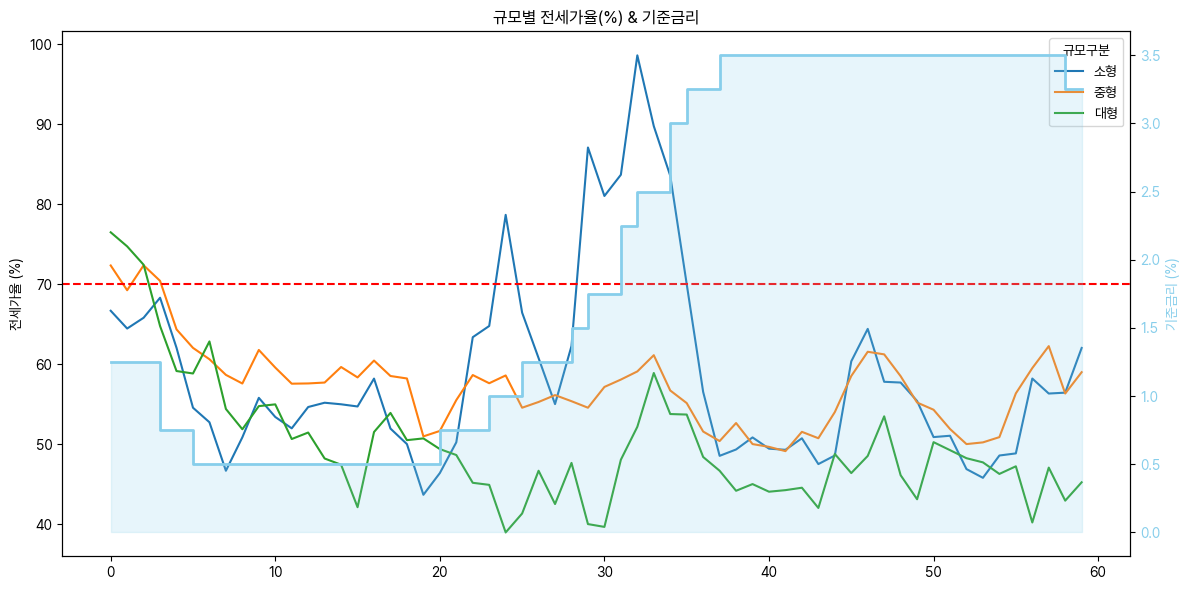

In [27]:
fig, ax = plt.subplots(figsize=(12,6))

# ÏôºÏ™Ω yÏ∂ï: ÏÜåÌòï/Ï§ëÌòï/ÎåÄÌòï Ï†ÑÏÑ∏Í∞ÄÏú®
ratio[['ÏÜåÌòï','Ï§ëÌòï','ÎåÄÌòï']].plot(ax=ax)
ax.set_ylabel('Ï†ÑÏÑ∏Í∞ÄÏú® (%)')
ax.set_title('Í∑úÎ™®Î≥Ñ Ï†ÑÏÑ∏Í∞ÄÏú®(%) & Í∏∞Ï§ÄÍ∏àÎ¶¨')
ax.legend(title='Í∑úÎ™®Íµ¨Î∂Ñ')

# Ïò§Î•∏Ï™Ω yÏ∂ï: Í∏∞Ï§ÄÍ∏àÎ¶¨ (Í≥ÑÎã®Ìòï)
ax2 = ax.twinx()
ax2.step(ratio.index, ratio['Í∏∞Ï§ÄÍ∏àÎ¶¨'], where='post', color='skyblue', linewidth=2, label='Í∏∞Ï§ÄÍ∏àÎ¶¨')
ax2.fill_between(ratio.index, 0, ratio['Í∏∞Ï§ÄÍ∏àÎ¶¨'], step='post', color='skyblue', alpha=0.2)
ax2.set_ylabel('Í∏∞Ï§ÄÍ∏àÎ¶¨ (%)', color='skyblue')
ax2.tick_params(axis='y', labelcolor='skyblue')

ax.axhline(70, color='red', linestyle='--', linewidth=1.5, label='70% Í∏∞Ï§ÄÏÑ†')

plt.tight_layout()
plt.show()

üîë ÏµúÏ¢Ö Ïù∏ÏÇ¨Ïù¥Ìä∏
1.	Í∏àÎ¶¨ Í∏âÎì±Í∏∞(2021~2022)
- Í∏àÎ¶¨ ÏÉÅÏäπ ‚Üí ÏÜåÌòï Ï†ÑÏÑ∏Í∞ÄÏú® Í∏âÎì±(ÏµúÎåÄ 90%ÎåÄ).
- Ï†ÑÏÑ∏ÏôÄ Îß§Îß§ Í∞ÄÍ≤© Ï∞®Ïù¥Í∞Ä Ï§ÑÏñ¥ Îß§Îß§ Ï†ÑÌôò Ïú†Î¶¨.
2.	Í∏àÎ¶¨ Í≥†Ï†êÍ∏∞(2023~2024)
- Í∏àÎ¶¨ ÎÜíÏßÄÎßå Î≥ÄÎèô ÏóÜÍ≥†, Ï†ÑÏÑ∏Í∞ÄÏú®ÏùÄ 40~60%Î°ú ÌïòÎùΩ.
- Îß§Îß§ ÎåÄÎπÑ Ï†ÑÏÑ∏Í∞Ä Ïã∏Ï†∏ÏÑú Ï†ÑÏÑ∏ Ïú†ÏßÄ Ïú†Î¶¨.
3.	Í∑úÎ™®Î≥Ñ Ï∞®Ïù¥
- ÏÜåÌòï: Í∏àÎ¶¨Ïóê Í∞ÄÏû• ÎØºÍ∞ê, 2030 Ï†ÑÎûµ ÌïµÏã¨.
- Ï§ëÌòï: ÏïàÏ†ïÏ†Å, Ïã§Í±∞Ï£º Î™©Ï†ÅÏù¥ÎùºÎ©¥ Ï§ëÏû•Í∏∞ Îß§Îß§ ÌåêÎã® Í∏∞Ï§Ä.
- ÎåÄÌòï: Ï†ÑÏÑ∏Í∞ÄÏú® ÎÇÆÏïÑ Îß§Îß§ Ï†ÑÌôò ÏùòÎØ∏ Ï†ÅÏùå.

‚∏ª

üëâ Í≤∞Î°†:
- Í∏âÎì±Í∏∞(Ï†ÑÏÑ∏Í∞ÄÏú® 70~80% Ïù¥ÏÉÅ) ‚Üí Îß§Îß§ Ï†ÑÌôò Í≥†Î†§.
- Í≥†Ï†êÍ∏∞(Ï†ÑÏÑ∏Í∞ÄÏú® 50~60% Ïù¥Ìïò) ‚Üí Ï†ÑÏÑ∏ Ïú†ÏßÄ, ÌòÑÍ∏àÌùêÎ¶Ñ Í¥ÄÎ¶¨.

> ## Ï¶â, Í∏àÎ¶¨Ïùò ‚ÄúÎ†àÎ≤®‚ÄùÎ≥¥Îã§ ‚ÄúÏÉÅÏäπ Ï∂îÏÑ∏‚ÄùÍ∞Ä Îß§Îß§ Ï†ÑÌôò Ïã†Ìò∏Î•º ÎßåÎì†Îã§.

### 4050

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/470633910.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_price = monthly_apt_by_size.pivot_table(


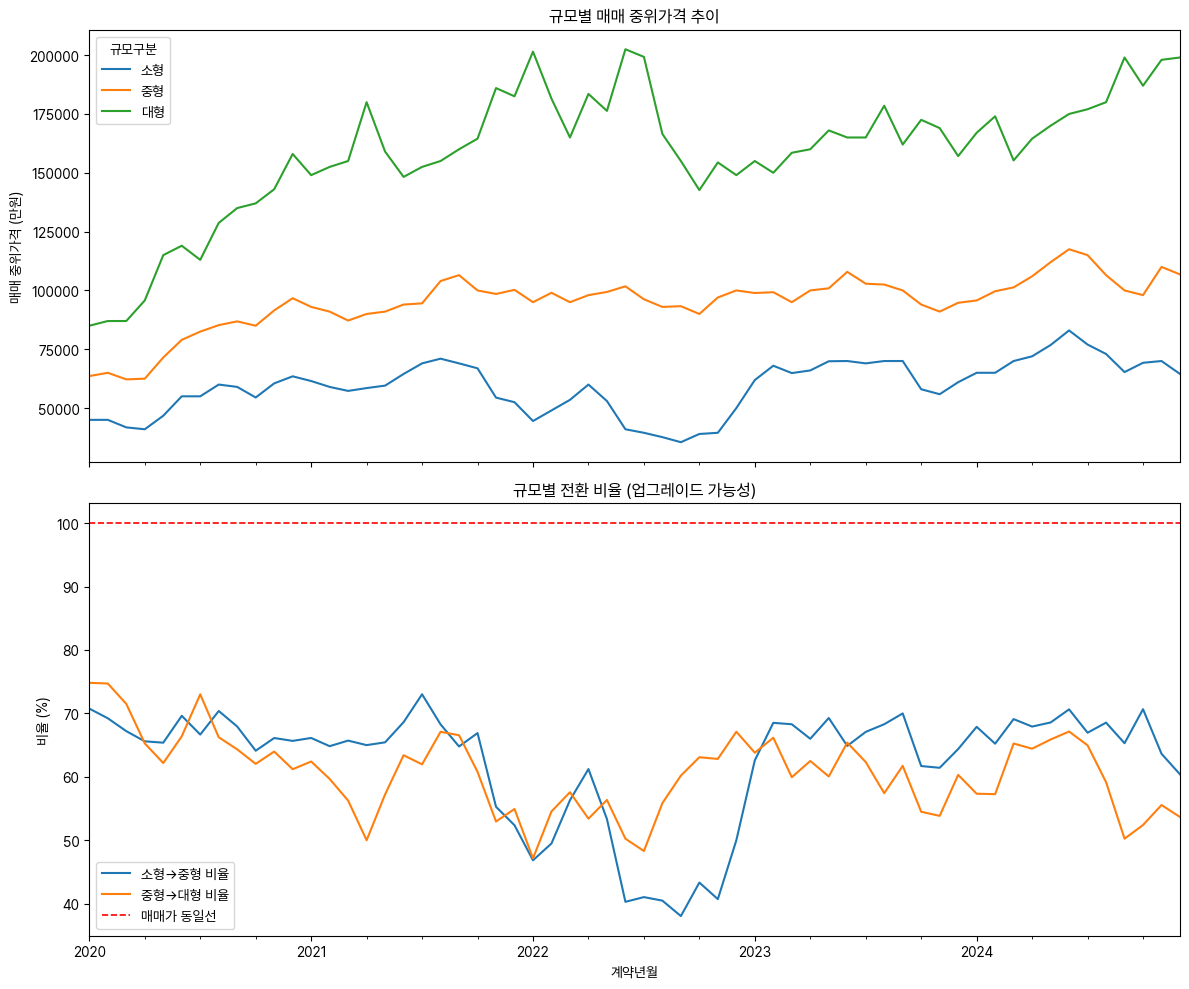

In [28]:
import matplotlib.pyplot as plt

# 1) Í∑úÎ™®Î≥Ñ Îß§Îß§Í∞Ä ÌîºÎ≤ó
pivot_price = monthly_apt_by_size.pivot_table(
    index='Í≥ÑÏïΩÎÖÑÏõî', columns='Í∑úÎ™®Íµ¨Î∂Ñ', values='Ï§ëÏúÑÍ∞ÄÍ≤©'
).sort_index()

# 2) Ï†ÑÌôòÎπÑÏú®(ÏÜå‚ÜíÏ§ë, Ï§ë‚ÜíÎåÄ)
ratio_size = pd.DataFrame({
    'ÏÜåÌòï‚ÜíÏ§ëÌòï ÎπÑÏú®': pivot_price['ÏÜåÌòï'] / pivot_price['Ï§ëÌòï'] * 100,
    'Ï§ëÌòï‚ÜíÎåÄÌòï ÎπÑÏú®': pivot_price['Ï§ëÌòï'] / pivot_price['ÎåÄÌòï'] * 100
})

# 3) 1x2 ÏÑúÎ∏åÌîåÎ°Ø
fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True)

# (1) Ï†àÎåÄ Îß§Îß§Í∞Ä ÏãúÍ≥ÑÏó¥
pivot_price.plot(ax=axes[0])
axes[0].set_title('Í∑úÎ™®Î≥Ñ Îß§Îß§ Ï§ëÏúÑÍ∞ÄÍ≤© Ï∂îÏù¥')
axes[0].set_ylabel('Îß§Îß§ Ï§ëÏúÑÍ∞ÄÍ≤© (ÎßåÏõê)')
axes[0].legend(title='Í∑úÎ™®Íµ¨Î∂Ñ')

# (2) Ï†ÑÌôòÎπÑÏú® ÏãúÍ≥ÑÏó¥
ratio_size.plot(ax=axes[1])
axes[1].axhline(100, color='red', linestyle='--', linewidth=1.2, label='Îß§Îß§Í∞Ä ÎèôÏùºÏÑ†')
axes[1].set_title('Í∑úÎ™®Î≥Ñ Ï†ÑÌôò ÎπÑÏú® (ÏóÖÍ∑∏Î†àÏù¥Îìú Í∞ÄÎä•ÏÑ±)')
axes[1].set_ylabel('ÎπÑÏú® (%)')
axes[1].legend()

plt.tight_layout()
plt.show()

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/2833804318.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_price = monthly_apt_by_size.pivot_table(


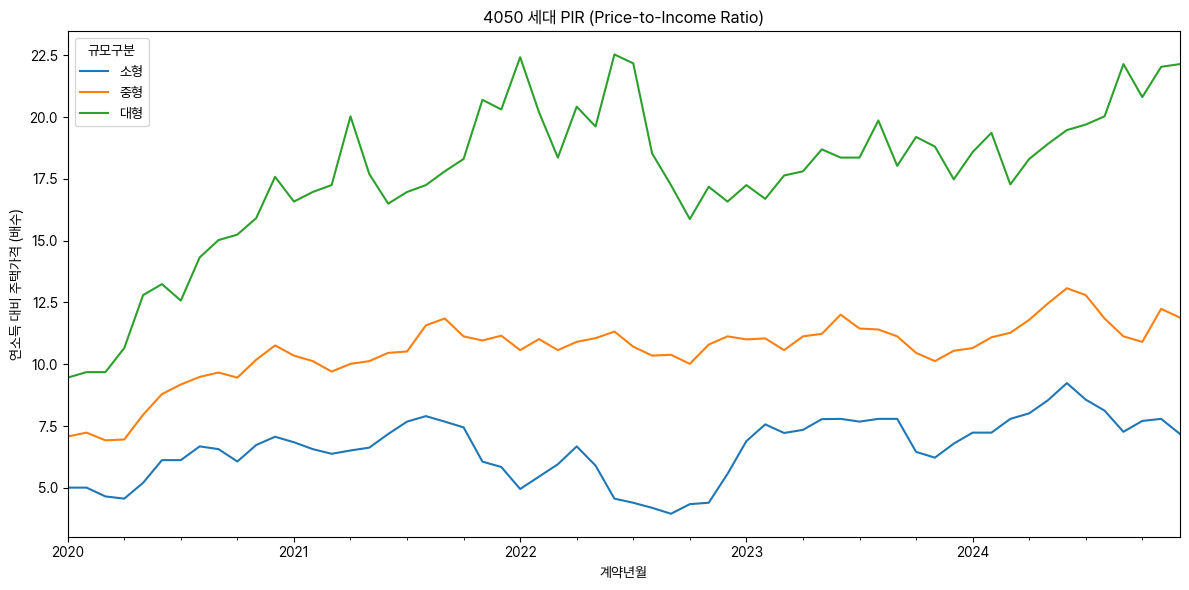

In [29]:
import matplotlib.pyplot as plt

# 4050 ÌèâÍ∑† Ïó∞ÏÜåÎìù (ÎßåÏõê)
income_4050 = 8985  

# Í∑úÎ™®Î≥Ñ Îß§Îß§Í∞Ä ÌîºÎ≤ó
pivot_price = monthly_apt_by_size.pivot_table(
    index='Í≥ÑÏïΩÎÖÑÏõî', columns='Í∑úÎ™®Íµ¨Î∂Ñ', values='Ï§ëÏúÑÍ∞ÄÍ≤©'
).sort_index()

# PIR Í≥ÑÏÇ∞
pir = pivot_price / income_4050

# ÏãúÍ∞ÅÌôî
fig, ax = plt.subplots(figsize=(12,6))
pir.plot(ax=ax)
ax.set_title('4050 ÏÑ∏ÎåÄ PIR (Price-to-Income Ratio)')
ax.set_ylabel('Ïó∞ÏÜåÎìù ÎåÄÎπÑ Ï£ºÌÉùÍ∞ÄÍ≤© (Î∞∞Ïàò)')
ax.legend(title='Í∑úÎ™®Íµ¨Î∂Ñ')
plt.tight_layout()
plt.show()

In [30]:
import pandas as pd

# CSV Î°úÎìú
df = pd.read_csv("Í∞ÄÍµ¨ Ïó∞Î†πÎ≥Ñ ÏûêÏÇ∞ Î∂ÄÏ±Ñ ÏÜåÎìù ÌòÑÌô© 2025.csv")

# ÏÇ¨Ïö©Ìï† Ïó∞ÎèÑ Ïª¨Îüº
years = ["2020","2021","2022","2023","2024"]

# 40ÎåÄ/50ÎåÄ Í≤ΩÏÉÅÏÜåÎìù(Ï†ÑÎÖÑÎèÑ) & Í∞ÄÍµ¨Î∂ÑÌè¨(%) Ï∂îÏ∂ú
inc_40 = df[(df["Í∞ÄÍµ¨Ï£º Ïó∞Î†πÍ≥ÑÏ∏µÎ≥Ñ(10ÏÑ∏)"]=="40~49ÏÑ∏") & (df["ÏûêÏÇ∞, Î∂ÄÏ±Ñ, ÏÜåÎìù Î∂ÑÎ•òÎ≥Ñ"]=="Í≤ΩÏÉÅÏÜåÎìù(Ï†ÑÎÖÑÎèÑ) (ÎßåÏõê)")][years].iloc[0].astype(float)
inc_50 = df[(df["Í∞ÄÍµ¨Ï£º Ïó∞Î†πÍ≥ÑÏ∏µÎ≥Ñ(10ÏÑ∏)"]=="50~59ÏÑ∏") & (df["ÏûêÏÇ∞, Î∂ÄÏ±Ñ, ÏÜåÎìù Î∂ÑÎ•òÎ≥Ñ"]=="Í≤ΩÏÉÅÏÜåÎìù(Ï†ÑÎÖÑÎèÑ) (ÎßåÏõê)")][years].iloc[0].astype(float)

pop_40 = df[(df["Í∞ÄÍµ¨Ï£º Ïó∞Î†πÍ≥ÑÏ∏µÎ≥Ñ(10ÏÑ∏)"]=="40~49ÏÑ∏") & (df["ÏûêÏÇ∞, Î∂ÄÏ±Ñ, ÏÜåÎìù Î∂ÑÎ•òÎ≥Ñ"]=="Í∞ÄÍµ¨Î∂ÑÌè¨ (%)")][years].iloc[0].astype(float)
pop_50 = df[(df["Í∞ÄÍµ¨Ï£º Ïó∞Î†πÍ≥ÑÏ∏µÎ≥Ñ(10ÏÑ∏)"]=="50~59ÏÑ∏") & (df["ÏûêÏÇ∞, Î∂ÄÏ±Ñ, ÏÜåÎìù Î∂ÑÎ•òÎ≥Ñ"]=="Í∞ÄÍµ¨Î∂ÑÌè¨ (%)")][years].iloc[0].astype(float)

# Í∞ÄÏ§ëÌèâÍ∑†: ((40ÎåÄÏÜåÎìù*40ÎåÄÎπÑÏ§ë)+(50ÎåÄÏÜåÎìù*50ÎåÄÎπÑÏ§ë)) / (40ÎåÄÎπÑÏ§ë+50ÎåÄÎπÑÏ§ë)
income_4050 = ((inc_40 * pop_40) + (inc_50 * pop_50)) / (pop_40 + pop_50)

# ÌÖåÏù¥Î∏îÎ°ú Ï†ïÎ¶¨
income_4050_df = income_4050.rename("4050 ÌèâÍ∑†Í≤ΩÏÉÅÏÜåÎìù(ÎßåÏõê)").to_frame()
income_4050_df.index.name = "Ïó∞ÎèÑ"

income_4050_df = income_4050_df.reset_index()
income_4050_df['Ïó∞ÎèÑ'] = income_4050_df['Ïó∞ÎèÑ'].astype(int)
income_4050_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ïó∞ÎèÑ               5 non-null      int64  
 1   4050 ÌèâÍ∑†Í≤ΩÏÉÅÏÜåÎìù(ÎßåÏõê)  5 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 212.0 bytes


In [41]:
df = monthly_apt_by_size.copy()
if not pd.api.types.is_datetime64_any_dtype(df['Í≥ÑÏïΩÎÖÑÏõî']):
    df['Í≥ÑÏïΩÎÖÑÏõî'] = pd.to_datetime(df['Í≥ÑÏïΩÎÖÑÏõî'])

df['Ïó∞ÎèÑ'] = df['Í≥ÑÏïΩÎÖÑÏõî'].dt.year

# 2020~2024 Ïó∞ÌèâÍ∑† Îß§Îß§Í∞Ä
annual_avg = (
    df[df['Ïó∞ÎèÑ'].between(2020, 2024)]
    .groupby(['Ïó∞ÎèÑ','Í∑úÎ™®Íµ¨Î∂Ñ'])['Ï§ëÏúÑÍ∞ÄÍ≤©']
    .mean()
    .round(0)
    .reset_index()
)

# Î≥¥Í∏∞ Ï¢ãÍ≤å ÌîºÎ≤ó
annual_avg_pivot = annual_avg.pivot(index='Ïó∞ÎèÑ', columns='Í∑úÎ™®Íµ¨Î∂Ñ', values='Ï§ëÏúÑÍ∞ÄÍ≤©').sort_index()
annual_avg_pivot = annual_avg_pivot.reset_index()
annual_avg_pivot

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_55449/1948829094.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Ïó∞ÎèÑ','Í∑úÎ™®Íµ¨Î∂Ñ'])['Ï§ëÏúÑÍ∞ÄÍ≤©']


Í∑úÎ™®Íµ¨Î∂Ñ    Ïó∞ÎèÑ       ÏÜåÌòï        Ï§ëÌòï        ÎåÄÌòï
0     2020  52254.0   77633.0  116954.0
1     2021  61933.0   95829.0  162021.0
2     2022  45179.0   96471.0  173092.0
3     2023  65383.0   98921.0  163383.0
4     2024  70904.0  105708.0  178812.0

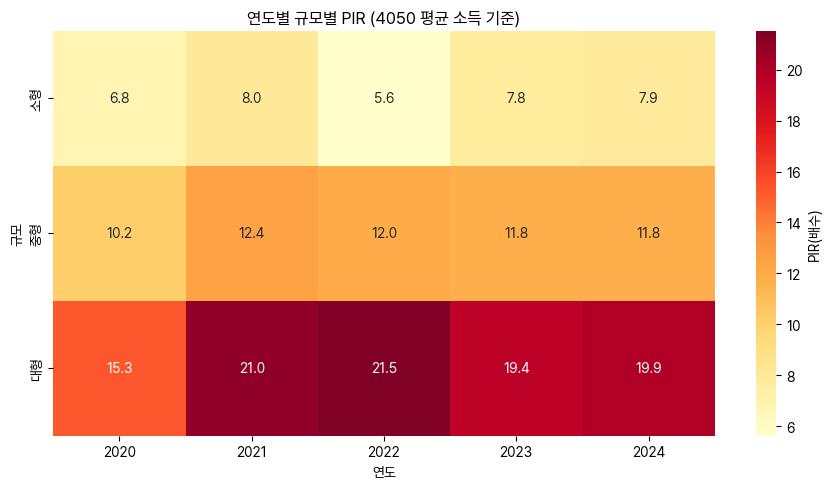

In [32]:
# 1) Î≥ëÌï©
merged = pd.merge(
    annual_avg_pivot.astype({'Ïó∞ÎèÑ': int}),
    income_4050_df.astype({'Ïó∞ÎèÑ': int}),
    on='Ïó∞ÎèÑ', how='inner'
)

# 2) PIR Í≥ÑÏÇ∞ (ÎßåÏõê Îã®ÏúÑ Í∑∏ÎåÄÎ°ú)
pir = merged.set_index('Ïó∞ÎèÑ')[['ÏÜåÌòï','Ï§ëÌòï','ÎåÄÌòï']].div(
    merged['4050 ÌèâÍ∑†Í≤ΩÏÉÅÏÜåÎìù(ÎßåÏõê)'].to_numpy(), axis=0
)

# 3) heatmapÏö© Ï†ïÎ¶¨: NA/inf Ï≤òÎ¶¨ + float64 Í∞ïÏ†ú
pir_mat = (pir.T.loc[['ÏÜåÌòï','Ï§ëÌòï','ÎåÄÌòï']]
             .replace([pd.NA, np.inf, -np.inf], np.nan)
             .astype('float64'))

# 4) ÌûàÌä∏Îßµ
plt.figure(figsize=(9,5))
sns.heatmap(pir_mat, annot=True, fmt=".1f", cmap="YlOrRd",
            cbar_kws={'label':'PIR(Î∞∞Ïàò)'}, mask=pir_mat.isna())
plt.title('Ïó∞ÎèÑÎ≥Ñ Í∑úÎ™®Î≥Ñ PIR (4050 ÌèâÍ∑† ÏÜåÎìù Í∏∞Ï§Ä)')
plt.xlabel('Ïó∞ÎèÑ'); plt.ylabel('Í∑úÎ™®')
plt.tight_layout(); plt.show()

# 4050 ÏÑ∏ÎåÄ PIR Ïù∏ÏÇ¨Ïù¥Ìä∏

## 1. Í∑úÎ™®Î≥Ñ PIR ÏàòÏ§Ä

-   **ÏÜåÌòï (6\~8Î∞∞)**: Íµ¨Îß§ Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùå. 4050 ÏÑ∏ÎåÄÏùò Ïã§ÏßàÏ†Å ÏÑ†ÌÉùÏßÄ.
-   **Ï§ëÌòï (11\~12Î∞∞)**: Í∞ÄÏû• ÏÑ†Ìò∏ÌïòÏßÄÎßå Î∂ÄÎã¥Ïù¥ ÌÅº. ÏÜåÎìù ÎåÄÎπÑ ÏßÑÏûÖ Ïû•Î≤Ω
    Ï°¥Ïû¨.
-   **ÎåÄÌòï (15\~21Î∞∞)**: ÏÇ¨Ïã§ÏÉÅ Î∂àÍ∞ÄÎä•. Ìà¨ÏûêÏûê/Í≥†ÏÜåÎìùÏ∏µ Ï§ëÏã¨ ÏãúÏû•.

## 2. Ïó∞ÎèÑÎ≥Ñ ÌùêÎ¶Ñ

-   **2021\~2022ÎÖÑ**: PIR Í∏âÎì±, 4050Ïùò Ï§ëÎåÄÌòï Ïã†Í∑ú ÏßÑÏûÖ Ï∞®Îã®.
-   **2023\~2024ÎÖÑ**: PIR ÏïàÏ†ïÌôî, Í∑∏Îü¨ÎÇò Ïó¨Ï†ÑÌûà Ï§ëÌòï Ïù¥ÏÉÅÏùÄ Î∂ÄÎã¥.

## 3. 4050 ÏÑ∏ÎåÄÏôÄ Î™©Ìëú

-   **ÌäπÏÑ±**: ÏÜåÎìù Ï†ïÏ†ê, Í∞ÄÏ°± Îã®ÏúÑ ÏÉùÌôú, ÏùÄÌá¥ Ï†Ñ ÏûêÏÇ∞ ÏïàÏ†ïÌôî ÌïÑÏöî.
-   **Î™©Ìëú**:
    -   ÏÜåÌòïÏùÄ Ï†ëÍ∑º Í∞ÄÎä•, Ï§ëÌòïÏùÄ Ï†ïÏ±ÖÏ†Å ÏßÄÏõê ÌïÑÏöî.
    -   ÎåÄÌòïÏùÄ Î¨¥Î¶¨Ìïú ÏßÑÏûÖÎ≥¥Îã§ ÏïàÏ†ïÏ†Å ÏûêÏÇ∞ Ïö¥Ïö©Ïóê ÏßëÏ§ë.


In [33]:
display(monthly_apt_by_size)
monthly_apt_by_size.info()

Í≥ÑÏïΩÎÖÑÏõî Í∑úÎ™®Íµ¨Î∂Ñ      Ï§ëÏúÑÍ∞ÄÍ≤©  Íµ¨Î∂Ñ
0   2020-01-01   ÏÜåÌòï   45000.0  Îß§Îß§
1   2020-01-01   Ï§ëÌòï   63600.0  Îß§Îß§
2   2020-01-01   ÎåÄÌòï   85000.0  Îß§Îß§
3   2020-02-01   ÏÜåÌòï   45000.0  Îß§Îß§
4   2020-02-01   Ï§ëÌòï   65000.0  Îß§Îß§
..         ...  ...       ...  ..
175 2024-11-01   Ï§ëÌòï  110000.0  Îß§Îß§
176 2024-11-01   ÎåÄÌòï  198000.0  Îß§Îß§
177 2024-12-01   ÏÜåÌòï   64500.0  Îß§Îß§
178 2024-12-01   Ï§ëÌòï  106800.0  Îß§Îß§
179 2024-12-01   ÎåÄÌòï  199000.0  Îß§Îß§

[180 rows x 4 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Í≥ÑÏïΩÎÖÑÏõî    180 non-null    datetime64[ns]
 1   Í∑úÎ™®Íµ¨Î∂Ñ    180 non-null    category      
 2   Ï§ëÏúÑÍ∞ÄÍ≤©    180 non-null    Float64       
 3   Íµ¨Î∂Ñ      180 non-null    object        
dtypes: Float64(1), category(1), datetime64[ns](1), object(1)
memory usage: 4.8+ KB


# 60ÎåÄ

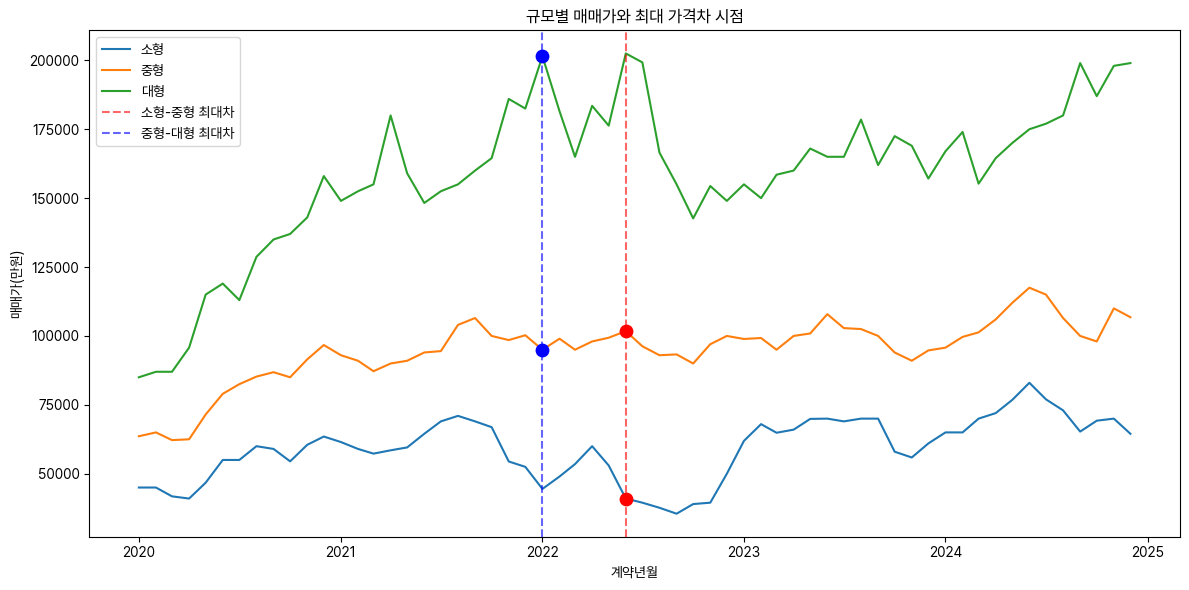

In [34]:
import matplotlib.pyplot as plt

# ÌîºÎ≤ó
piv = monthly_apt_by_size.pivot(index='Í≥ÑÏïΩÎÖÑÏõî', columns='Í∑úÎ™®Íµ¨Î∂Ñ', values='Ï§ëÏúÑÍ∞ÄÍ≤©').sort_index()

# Í∞ÄÍ≤©Ï∞®
diff_sm = piv['Ï§ëÌòï'] - piv['ÏÜåÌòï']
diff_ml = piv['ÎåÄÌòï'] - piv['Ï§ëÌòï']

# ÏµúÎåÄÏ∞® ÎÇ†Ïßú
d_sm = diff_sm.idxmax()
d_ml = diff_ml.idxmax()

fig, ax = plt.subplots(figsize=(12,6))

# Î≥∏ÏÑ†
ax.plot(piv.index, piv['ÏÜåÌòï'], label='ÏÜåÌòï')
ax.plot(piv.index, piv['Ï§ëÌòï'], label='Ï§ëÌòï')
ax.plot(piv.index, piv['ÎåÄÌòï'], label='ÎåÄÌòï')

# ÏàòÏßÅÏÑ†
ax.axvline(d_sm, color='red', linestyle='--', alpha=0.6, label='ÏÜåÌòï-Ï§ëÌòï ÏµúÎåÄÏ∞®')
ax.axvline(d_ml, color='blue', linestyle='--', alpha=0.6, label='Ï§ëÌòï-ÎåÄÌòï ÏµúÎåÄÏ∞®')

# Ìï¥Îãπ ÏãúÏ†ê Ï†ê ÌëúÏãú
ax.scatter(d_sm, piv.loc[d_sm, 'ÏÜåÌòï'], color='red', s=80, zorder=5)
ax.scatter(d_sm, piv.loc[d_sm, 'Ï§ëÌòï'], color='red', s=80, zorder=5)

ax.scatter(d_ml, piv.loc[d_ml, 'Ï§ëÌòï'], color='blue', s=80, zorder=5)
ax.scatter(d_ml, piv.loc[d_ml, 'ÎåÄÌòï'], color='blue', s=80, zorder=5)

ax.set_title('Í∑úÎ™®Î≥Ñ Îß§Îß§Í∞ÄÏôÄ ÏµúÎåÄ Í∞ÄÍ≤©Ï∞® ÏãúÏ†ê')
ax.set_ylabel('Îß§Îß§Í∞Ä(ÎßåÏõê)')
ax.set_xlabel('Í≥ÑÏïΩÎÖÑÏõî')
ax.legend()
plt.tight_layout()
plt.show()

# üìä Í∞ÄÍ≤© Ï∞®Ïù¥ÏôÄ Ï¶ùÍ∞ÄÏú® Ï∂îÏÑ∏ÏÑ† Î∂ÑÏÑù

## 1. Í∑úÎ™®Î≥Ñ Îß§Îß§Í∞Ä Î∞è Í∞ÄÍ≤© Ï∞®Ïù¥ ÏãúÏ†ê
- Ï≤´ Î≤àÏß∏ Í∑∏ÎûòÌîÑÎäî ÏÜåÌòï, Ï§ëÌòï, ÎåÄÌòï ÏïÑÌååÌä∏Ïùò Îß§Îß§Í∞ÄÎ•º ÏãúÍ≥ÑÏó¥Î°ú ÎÇòÌÉÄÎÇ¥Í≥†,  
  **ÏÜåÌòï-Ï§ëÌòï**, **Ï§ëÌòï-ÎåÄÌòï** Í∞ÑÏùò Í∞ÄÍ≤© Ï∞®Ïù¥Í∞Ä Í∞ÄÏû• ÌÅ¨Í≤å Î≤åÏñ¥ÏßÑ ÏãúÏ†êÏùÑ ÌëúÏãúÌñàÎã§.
- Ìï¥Îãπ ÏãúÏ†êÏùÄ **Ï†ÑÌôò ÌÉÄÏù¥Î∞ç**ÏùÑ Í∞ÄÎä†Ìï† Ïàò ÏûàÎäî Ï£ºÏöî ÏßÄÌëúÎ°ú ÌôúÏö© Í∞ÄÎä•ÌïòÎã§.

---


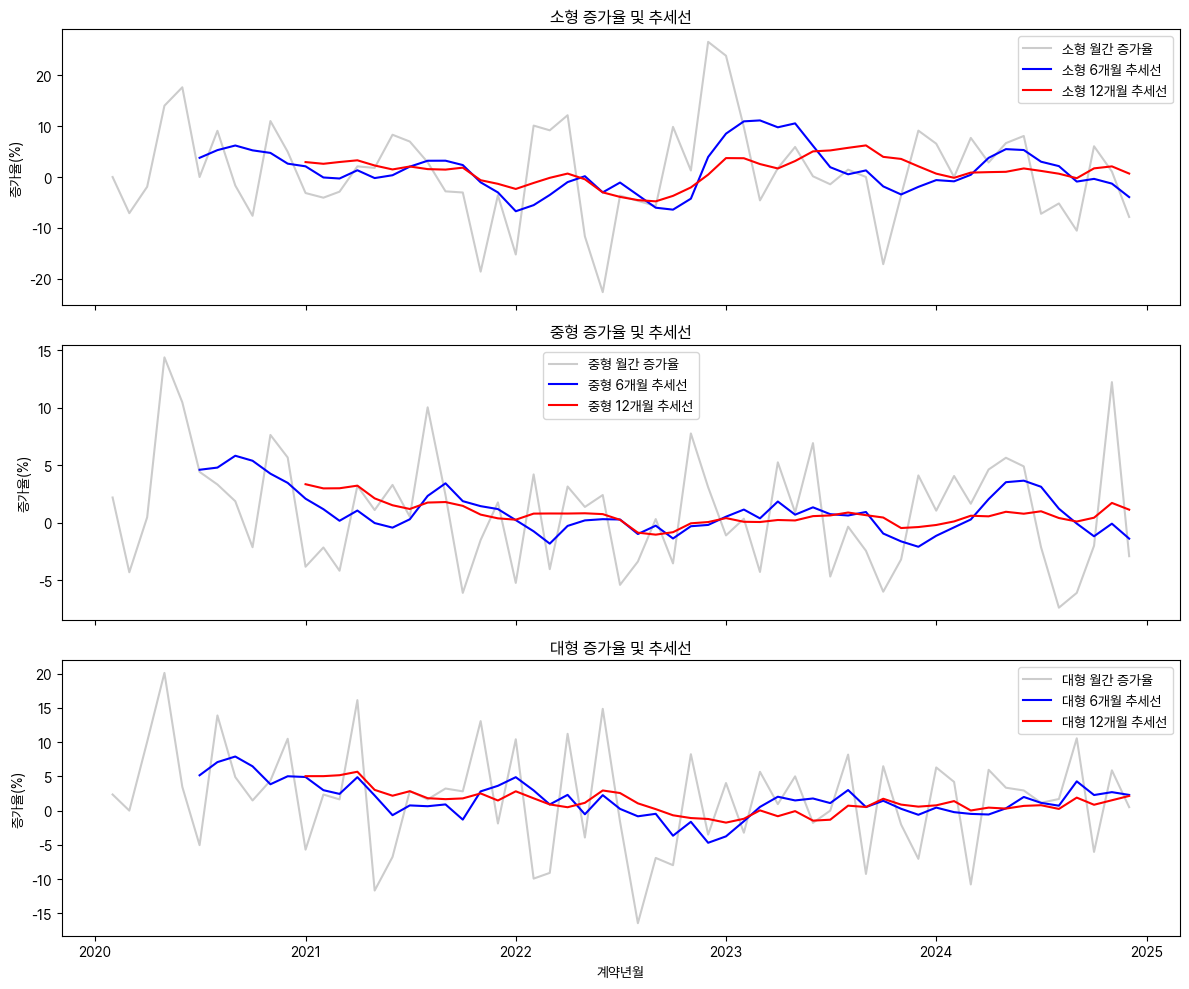

In [35]:
# 1) Ï†ÑÏõî ÎåÄÎπÑ Ï¶ùÍ∞ÄÏú® Í≥ÑÏÇ∞
growth = monthly_apt_by_size.pivot(index='Í≥ÑÏïΩÎÖÑÏõî', columns='Í∑úÎ™®Íµ¨Î∂Ñ', values='Ï§ëÏúÑÍ∞ÄÍ≤©')
growth_rate = growth.pct_change() * 100  # % Îã®ÏúÑÎ°ú Î≥ÄÌôò

# 2) Ïù¥ÎèôÌèâÍ∑† Ï∂îÏÑ∏ÏÑ† (6Í∞úÏõî, 12Í∞úÏõî)
growth_ma6 = growth_rate.rolling(6).mean()
growth_ma12 = growth_rate.rolling(12).mean()

# 3) ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(3, 1, figsize=(12,10), sharex=True)

for i, size in enumerate(growth_rate.columns):
    ax = axes[i]
    ax.plot(growth_rate.index, growth_rate[size], color='gray', alpha=0.4, label=f'{size} ÏõîÍ∞Ñ Ï¶ùÍ∞ÄÏú®')
    ax.plot(growth_ma6.index, growth_ma6[size], color='blue', label=f'{size} 6Í∞úÏõî Ï∂îÏÑ∏ÏÑ†')
    ax.plot(growth_ma12.index, growth_ma12[size], color='red', label=f'{size} 12Í∞úÏõî Ï∂îÏÑ∏ÏÑ†')
    ax.set_ylabel('Ï¶ùÍ∞ÄÏú®(%)')
    ax.set_title(f'{size} Ï¶ùÍ∞ÄÏú® Î∞è Ï∂îÏÑ∏ÏÑ†')
    ax.legend()

plt.xlabel('Í≥ÑÏïΩÎÖÑÏõî')
plt.tight_layout()
plt.show()


## 2. Ï¶ùÍ∞ÄÏú® Ï∂îÏÑ∏ÏÑ† ÌÉêÏÉâ
- Îëê Î≤àÏß∏ Í∑∏ÎûòÌîÑÎäî Í∞Å Í∑úÎ™®Î≥Ñ **ÏõîÍ∞Ñ Ï¶ùÍ∞ÄÏú®(%)**Í≥º Ìï®Íªò  
  **6Í∞úÏõî, 12Í∞úÏõî Ïù¥ÎèôÌèâÍ∑† Ï∂îÏÑ∏ÏÑ†**ÏùÑ Ï∂îÍ∞ÄÌïòÏó¨ Î≥ÄÎèôÏÑ±ÏùÑ ÌèâÌôúÌôîÌñàÎã§.
- Ïù¥Î•º ÌÜµÌï¥ Í∞ÄÍ≤©Ïùò Îã®Í∏∞/Ï§ëÍ∏∞ Ï∂îÏÑ∏Î•º ÌååÏïÖÌïòÍ≥†,  
  **Í∞ÄÍ≤© Ï∞®Ïù¥Í∞Ä ÌÅ¨Í≤å Î≤åÏñ¥ÏßÄÎäî Íµ¨Í∞ÑÏù¥ Îã®ÏàúÌïú ÏùºÏãúÏ†Å Í∏âÎì±Ïù∏ÏßÄ,  
  ÏïÑÎãàÎ©¥ ÏßÄÏÜçÏ†ÅÏù∏ ÌùêÎ¶Ñ ÏÜçÏóêÏÑú Î∞úÏÉùÌïú Í≤ÉÏù∏ÏßÄ**Î•º ÌôïÏù∏Ìï† Ïàò ÏûàÎã§.

---

## Ïù∏ÏÇ¨Ïù¥Ìä∏ Ï†ïÎ¶¨
1. **Í∞ÄÍ≤© Ï∞®Ïù¥ ÌôïÎåÄ Íµ¨Í∞Ñ**  
   - ÏÜåÌòï‚ÜîÏ§ëÌòï, Ï§ëÌòï‚ÜîÎåÄÌòï Í∞ÑÏùò Í∞ÄÍ≤© Ï∞®Ïù¥Í∞Ä Í∑πÎåÄÌôîÎêú ÏãúÏ†êÏùÄ  
     ÏãúÏû• Ï∞∏Ïó¨ÏûêÎì§ÏóêÍ≤å **Ï†ÑÌôò(ÏóÖÍ∑∏Î†àÏù¥Îìú ÌòπÏùÄ Îã§Ïö¥ÏÇ¨Ïù¥Ïßï) Ï†ÑÎûµ**ÏùÑ Í≥†Î†§Ìï† Ïàò ÏûàÎäî Î∂ÑÍ∏∞Ï†êÏù¥Îã§.

2. **Ï¶ùÍ∞ÄÏú® Ï∂îÏÑ∏ÏÑ†Ïùò Î≥¥Ï°∞Ï†Å ÌôúÏö©**  
   - Îã®Ïàú Í∞ÄÍ≤© Ï∞®Ïù¥Îßå Î≥¥Î©¥ **ÏãúÏ†êÏù¥ ÏôúÍ≥°**Îê† Ïàò ÏûàÏúºÎØÄÎ°ú,  
     Ï¶ùÍ∞ÄÏú® Ï∂îÏÑ∏ÏÑ†ÏúºÎ°ú **Î≥ÄÎèôÏÑ± ÌïÑÌÑ∞ÎßÅ**ÏùÑ Í±∞ÏπòÎ©¥ Îçî Ïã†Î¢∞ÎèÑ ÎÜíÏùÄ ÏãúÍ∑∏ÎÑêÏùÑ ÏñªÏùÑ Ïàò ÏûàÎã§.

3. **Ïã§Î¨¥Ï†Å ÏùòÏùò**  
   - Í∏àÎ¶¨ Í∞ôÏùÄ Ïô∏ÏÉù Î≥ÄÏàò ÎåÄÏã†,  
     **Í∑úÎ™®Î≥Ñ ÏÉÅÎåÄÍ∞ÄÍ≤© Î∞è Ï¶ùÍ∞ÄÏú® ÌùêÎ¶Ñ ÏûêÏ≤¥Î•º ÏßÄÌëúÌôî**ÌïòÎäî Í≤ÉÏù¥  
     Ìà¨Ïûê Ï†ÑÎûµ(Îß§Îß§ Ï†ÑÌôò, ÏóÖÍ∑∏Î†àÏù¥Îìú/Îã§Ïö¥ÏÇ¨Ïù¥Ïßï) ÏàòÎ¶ΩÏóê ÏßÅÏ†ëÏ†Å Í∑ºÍ±∞Î°ú ÏûëÎèôÌï† Ïàò ÏûàÎã§.



# üè† ÏÉùÏï†Ï£ºÍ∏∞Î≥Ñ Î∂ÄÎèôÏÇ∞ Ìà¨Ïûê Î∞è Í±∞Ï£º Ï†ÑÎûµ

| Íµ¨Î∂Ñ | 20‚Äß30ÎåÄ | 40‚Äß50ÎåÄ | 60ÎåÄ Ïù¥ÏÉÅ |
|------|----------|----------|------------|
| **ÌïµÏã¨ Î™©Ìëú** | ÏûêÏÇ∞ Ï∂ïÏ†Å Ï¥àÍ∏∞, Ï≤´ Ï£ºÍ±∞ ÏïàÏ†ïÌôî | ÏÜåÎìù¬∑ÏûêÏÇ∞ ÌîºÌÅ¨, Ï£ºÍ±∞ ÌôïÏû• + ÏïàÏ†ïÏ†Å Ìà¨Ïûê | Ïú†ÎèôÏÑ± ÌôïÎ≥¥, ÏùÄÌá¥ Ïù¥ÌõÑ ÏïàÏ†ïÏ†Å ÌòÑÍ∏àÌùêÎ¶Ñ |
| **ÌäπÏÑ±** | - ÏÜåÎìù Ï†ÅÏßÄÎßå ÏÑ±Ïû• Ïó¨Î†• ÌÅº<br>- Î∂ÄÏ±Ñ ÌôúÏö© Î∂àÍ∞ÄÌîº (Î†àÎ≤ÑÎ¶¨ÏßÄ) <br>- Ï≤´ ÎÇ¥ Ïßë ÎßàÎ†® Ï§ëÏöî | - ÏÜåÎìù¬∑ÏûêÏÇ∞ ÏµúÍ≥†Ï°∞<br>- ÍµêÏú°/ÏûêÎÖÄ ÏßÄÏ∂ú¬∑Ìà¨Ïûê ÌôïÎåÄ<br>- Ï£ºÍ±∞ ÏóÖÍ∑∏Î†àÏù¥Îìú(Ï§ëÌòï/ÎåÄÌòï) ÏàòÏöî‚Üë | - ÏÜåÎìù Í∞êÏÜå<br>- ÏàúÏûêÏÇ∞ ÎπÑÏ§ë ‚Üë, Î∂ÄÏ±Ñ Î∂ÄÎã¥ ‚Üì<br>- Ï£ºÍ±∞ Ïú†ÏßÄ ÎπÑÏö©¬∑ÌòÑÍ∏àÌùêÎ¶Ñ Ï§ëÏöî |
| **Ï†ÑÎûµ** | - ÎåÄÏ∂ú ÌôúÏö©Ìï¥ Ï£ºÌÉù ÏßÑÏûÖ<br>- ÌÅ¨Í≥† Î∂ÄÎã¥ÎêòÎäî Ìà¨Ïûê ÏßÄÏñë<br>- Ï≤´ Ï£ºÍ±∞ ÏïàÏ†ïÌôî ‚Üí Ïû•Í∏∞ Î≥¥Ïú† | - Ï£ºÍ±∞ ÌôïÏû• (Ï§ëÌòï‚ÜíÎåÄÌòï)<br>- ÌïôÍµ∞/ÏûÖÏßÄ Í∏∞Î∞ò Ìà¨Ïûê<br>- ÏïàÏ†ïÏ†Å ÏûÑÎåÄ¬∑Î∂ÑÏÇ∞Ìà¨Ïûê Î≥ëÌñâ<br>- ÏùÄÌá¥ Ï§ÄÎπÑ ÏãúÏûë | - ÎåÄÌòï ‚Üí Ï§ë/ÏÜåÌòï Îã§Ïö¥ÏÇ¨Ïù¥Ïßï<br>- Îß§Îß§ ‚Üí ÏûÑÎåÄ Ï†ÑÌôò(Ï†ÑÏÑ∏¬∑ÏõîÏÑ∏)ÏúºÎ°ú ÌòÑÍ∏àÌùêÎ¶Ñ ÌôïÎ≥¥<br>- Ï∞®Ïùµ Ïã§ÌòÑ ÌõÑ Í∏àÏúµÏûêÏÇ∞ Î∂ÑÏÇ∞ |
| **Ï§ëÏ†ê Ìè¨Ïù∏Ìä∏** | ‚úÖ Î†àÎ≤ÑÎ¶¨ÏßÄ Í¥ÄÎ¶¨<br>‚úÖ Ï≤´ Ï£ºÌÉù Îß§ÏûÖ | ‚úÖ ÏûêÏÇ∞ ÌôïÎåÄ & ÏïàÏ†ïÏ†Å Ïö¥Ïö©<br>‚úÖ ÏùÄÌá¥ ÎåÄÎπÑ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ | ‚úÖ Ïú†ÎèôÏÑ± ÌôïÎ≥¥<br>‚úÖ Í±∞Ï£º ÏïàÏ†ïÏÑ± + ÏÉùÌôúÎπÑ ÌòÑÍ∏àÌùêÎ¶Ñ |

---

üìå ÏöîÏïΩ  
- **20‚Äß30ÎåÄ**: *ÏßÑÏûÖÍ∏∞* ‚Üí ‚ÄúÏßë ÎßàÎ†® & Î†àÎ≤ÑÎ¶¨ÏßÄ Í¥ÄÎ¶¨‚Äù  
- **40‚Äß50ÎåÄ**: *ÌôïÏû•Í∏∞* ‚Üí ‚ÄúÏÜåÎìù ÌîºÌÅ¨ ÌôúÏö© + Ï£ºÍ±∞/Ìà¨Ïûê ÌôïÏû•‚Äù  
- **60ÎåÄ Ïù¥ÌõÑ**: *Ï†ÑÌôòÍ∏∞* ‚Üí ‚ÄúÎåÄÌòï Îß§Í∞Å ‚Üí Ï§ë¬∑ÏÜåÌòï/ÏûÑÎåÄ Ï†ÑÌôò + ÌòÑÍ∏àÌùêÎ¶Ñ Ïö∞ÏÑ†‚Äù  


In [36]:
# 1. ÏõîÎ≥Ñ Í±∞ÎûòÎüâ, Í∞ÄÍ≤© ÏßëÍ≥Ñ
monthly_stats = (
    df_all.groupby('Í≥ÑÏïΩÎÖÑÏõî')
    .agg(Í±∞ÎûòÎüâ=('Í±∞ÎûòÍ∏àÏï°(ÎßåÏõê)', 'count'),
         ÌèâÍ∑†ÌèâÎã®Í∞Ä=('ÌèâÎã®Í∞Ä(ÎßåÏõê)', 'mean'))
    .reset_index()
)

# 2. Í∞ÄÍ≤© Î≥ÄÎèôÎ•† (Ï†ÑÏõî ÎåÄÎπÑ %)
monthly_stats['Í∞ÄÍ≤©Î≥ÄÎèôÎ•†(%)'] = monthly_stats['ÌèâÍ∑†ÌèâÎã®Í∞Ä'].pct_change() * 100

# 3. Í∏∞Ïö∏Í∏∞(Ï∂îÏÑ∏ÏÑ†Ïö©) ‚Üí rollingÏùÑ Ïç®ÏÑú Î≥ÄÌôî ÏÜçÎèÑ Ï∂îÏ†ï Í∞ÄÎä•
monthly_stats['Í∞ÄÍ≤©Î≥ÄÎèô_3Í∞úÏõîÍ∏∞Ïö∏Í∏∞'] = monthly_stats['ÌèâÍ∑†ÌèâÎã®Í∞Ä'].diff(3) / 3
monthly_stats['Í±∞ÎûòÎüâ_3Í∞úÏõîÍ∏∞Ïö∏Í∏∞'] = monthly_stats['Í±∞ÎûòÎüâ'].diff(3) / 3

monthly_stats.head(12)  # ÏïûÎ∂ÄÎ∂Ñ ÌôïÏù∏

Í≥ÑÏïΩÎÖÑÏõî    Í±∞ÎûòÎüâ        ÌèâÍ∑†ÌèâÎã®Í∞Ä   Í∞ÄÍ≤©Î≥ÄÎèôÎ•†(%)  Í∞ÄÍ≤©Î≥ÄÎèô_3Í∞úÏõîÍ∏∞Ïö∏Í∏∞   Í±∞ÎûòÎüâ_3Í∞úÏõîÍ∏∞Ïö∏Í∏∞
0  2020-01-01   6483  2983.089864        NaN          NaN         <NA>
1  2020-02-01   8251  3095.235613   3.759382          NaN         <NA>
2  2020-03-01   4303  3023.172301  -2.328201          NaN         <NA>
3  2020-04-01   2976  3142.880820   3.959699    53.263652      -1169.0
4  2020-05-01   5434  3462.786329  10.178735   122.516905       -939.0
5  2020-06-01  15341  3692.782478   6.641939   223.203393  3679.333333
6  2020-07-01  10502  3702.972442   0.275943   186.697207  2508.666667
7  2020-08-01   4891  4002.082545   8.077568   179.765406       -181.0
8  2020-09-01   3694  4003.003246   0.023006   103.406922 -3882.333333
9  2020-10-01   4260  3952.930937  -1.250869    83.319498 -2080.666667
10 2020-11-01   6198  4211.623914   6.544333    69.847123   435.666667
11 2020-12-01   7303  4458.879908   5.870799   151.958887       1203.0

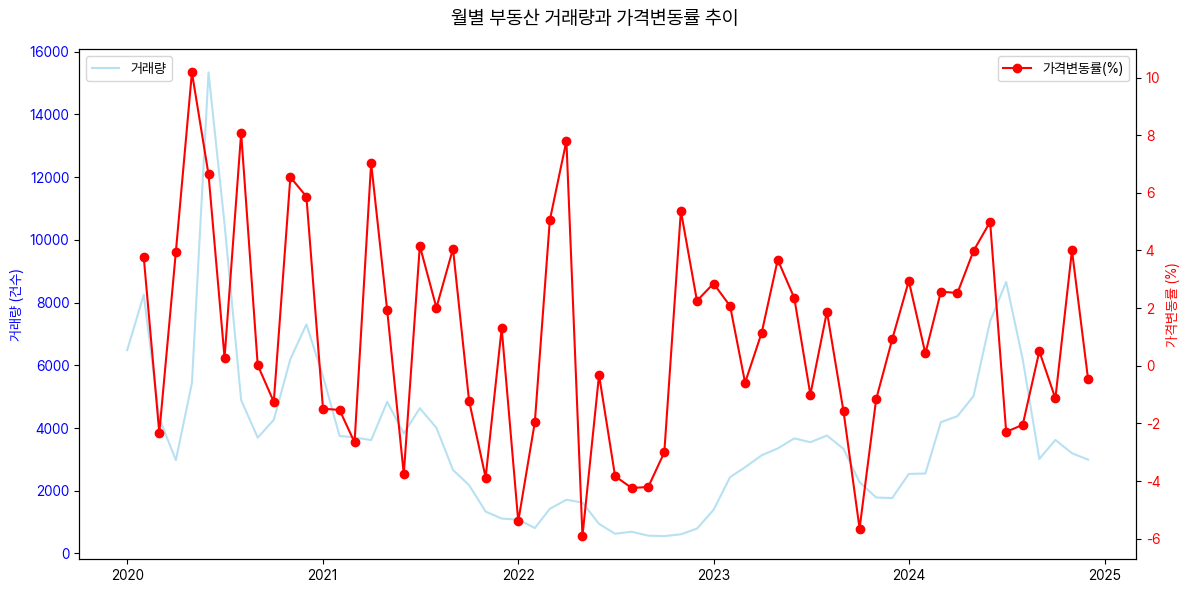

In [37]:
import matplotlib.pyplot as plt

# Í±∞ÎûòÎüâ & Í∞ÄÍ≤©Î≥ÄÎèôÎ•† ÏãúÍ∞ÅÌôî
fig, ax1 = plt.subplots(figsize=(12,6))

# Í±∞ÎûòÎüâ (ÎßâÎåÄÍ∑∏ÎûòÌîÑ, ÏôºÏ™Ω yÏ∂ï)
ax1.plot(monthly_stats['Í≥ÑÏïΩÎÖÑÏõî'], monthly_stats['Í±∞ÎûòÎüâ'], 
        color='skyblue', alpha=0.6, label='Í±∞ÎûòÎüâ')
ax1.set_ylabel('Í±∞ÎûòÎüâ (Í±¥Ïàò)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Í∞ÄÍ≤©Î≥ÄÎèôÎ•† (ÏÑ†Í∑∏ÎûòÌîÑ, Ïò§Î•∏Ï™Ω yÏ∂ï)
ax2 = ax1.twinx()
ax2.plot(monthly_stats['Í≥ÑÏïΩÎÖÑÏõî'], monthly_stats['Í∞ÄÍ≤©Î≥ÄÎèôÎ•†(%)'], 
         color='red', marker='o', label='Í∞ÄÍ≤©Î≥ÄÎèôÎ•†(%)')
ax2.set_ylabel('Í∞ÄÍ≤©Î≥ÄÎèôÎ•† (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# ÌÉÄÏù¥ÌãÄ & Î≤îÎ°Ä
fig.suptitle('ÏõîÎ≥Ñ Î∂ÄÎèôÏÇ∞ Í±∞ÎûòÎüâÍ≥º Í∞ÄÍ≤©Î≥ÄÎèôÎ•† Ï∂îÏù¥', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

[ÏÑ†ÌñâÏãúÏ∞®] lag=+10Í∞úÏõî, corr=0.256


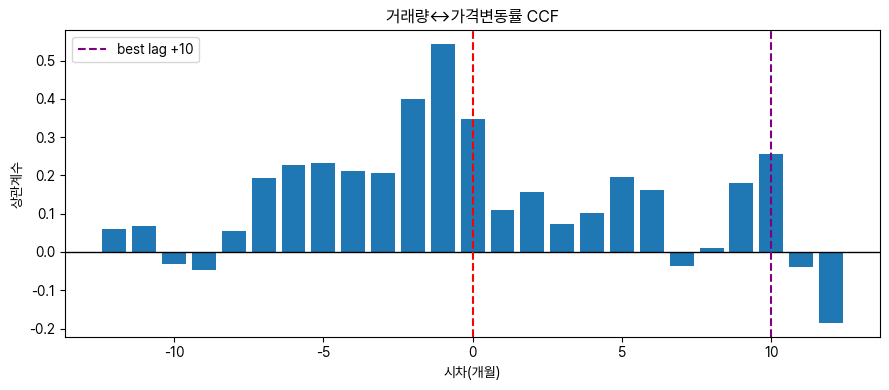

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ÏûÖÎ†•: monthly_stats[['Í≥ÑÏïΩÎÖÑÏõî','Í±∞ÎûòÎüâ','Í∞ÄÍ≤©Î≥ÄÎèôÎ•†(%)']]
ms = monthly_stats.dropna(subset=['Í±∞ÎûòÎüâ','Í∞ÄÍ≤©Î≥ÄÎèôÎ•†(%)']).copy()
vol = ms['Í±∞ÎûòÎüâ'] - ms['Í±∞ÎûòÎüâ'].mean()
ret = ms['Í∞ÄÍ≤©Î≥ÄÎèôÎ•†(%)'] - ms['Í∞ÄÍ≤©Î≥ÄÎèôÎ•†(%)'].mean()

max_lag = 12
lags = np.arange(-max_lag, max_lag+1)
ccf_vals = []
for k in lags:
    if k < 0:
        c = np.corrcoef(vol[-k:].to_numpy(), ret[:len(ret)+k].to_numpy())[0,1]
    else:
        c = np.corrcoef(vol[:len(vol)-k].to_numpy(), ret[k:].to_numpy())[0,1]
    ccf_vals.append(c)

ccf_df = pd.DataFrame({'lag': lags, 'correlation': ccf_vals})

# ÏµúÏ†Å ÏÑ†ÌñâÏãúÏ∞®(Í±∞ÎûòÎüâÏù¥ Í∞ÄÍ≤©ÏùÑ ÏÑ†Ìñâ: lag>0 Ï§ë ÏµúÎåÄ)
lead = ccf_df[ccf_df['lag']>0].sort_values('correlation', ascending=False).head(1)
best_lag = int(lead['lag'].iloc[0])
best_corr = float(lead['correlation'].iloc[0])
print(f"[ÏÑ†ÌñâÏãúÏ∞®] lag=+{best_lag}Í∞úÏõî, corr={best_corr:.3f}")

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(9,4))
plt.bar(ccf_df['lag'], ccf_df['correlation'])
plt.axhline(0, color='k', lw=1)
plt.axvline(0, color='r', ls='--')
plt.axvline(best_lag, color='purple', ls='--', label=f'best lag +{best_lag}')
plt.title('Í±∞ÎûòÎüâ‚ÜîÍ∞ÄÍ≤©Î≥ÄÎèôÎ•† CCF')
plt.xlabel('ÏãúÏ∞®(Í∞úÏõî)'); plt.ylabel('ÏÉÅÍ¥ÄÍ≥ÑÏàò')
plt.legend(); plt.tight_layout(); plt.show()

[ÏãúÍ∑∏ÎÑê ÏÑ±Îä•] ÌëúÎ≥∏ 3Í∞ú, ÌèâÍ∑† ÎØ∏ÎûòÏàòÏùµÎ•†(%) = 4.94, Ï§ëÏïôÍ∞í = 5.87


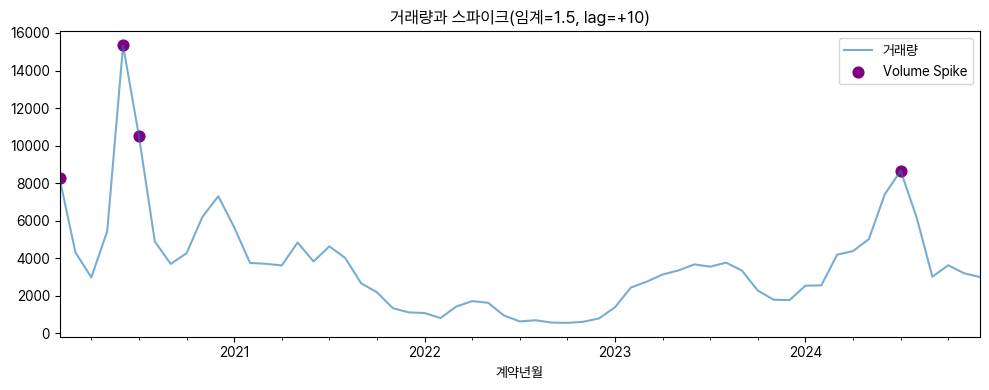

In [39]:
from scipy.stats import zscore

# Í±∞ÎûòÎüâ Ïä§ÌååÏù¥ÌÅ¨(ÌèâÍ∑†ÎåÄÎπÑ) ‚Üí best_lagÍ∞úÏõî ÌõÑ Í∞ÄÍ≤©Î≥ÄÎèô ÏòàÍ≥†
ms['vol_z'] = zscore(ms['Í±∞ÎûòÎüâ'].astype(float))
th = 1.5  # ÏûÑÍ≥ÑÏπò(Ï°∞Ï†ï Í∞ÄÎä•)
ms['signal'] = (ms['vol_z'] > th).astype(int)

# ÏòàÏ∏° ÌÉÄÍπÉ: best_lagÍ∞úÏõî Îí§Ïùò Ïã§Ï†ú Í∞ÄÍ≤©Î≥ÄÎèôÎ•†
ms = ms.set_index('Í≥ÑÏïΩÎÖÑÏõî').sort_index()
ms['ret_fwd'] = ms['Í∞ÄÍ≤©Î≥ÄÎèôÎ•†(%)'].shift(-best_lag)

# Í∞ÑÎã® ÏÑ±Îä• Ï≤¥ÌÅ¨: ÏãúÍ∑∏ÎÑê ÏãúÏ†êÏùò ÌèâÍ∑† ret_fwd
hit = ms.loc[ms['signal']==1, 'ret_fwd'].dropna()
print(f"[ÏãúÍ∑∏ÎÑê ÏÑ±Îä•] ÌëúÎ≥∏ {len(hit)}Í∞ú, ÌèâÍ∑† ÎØ∏ÎûòÏàòÏùµÎ•†(%) = {hit.mean():.2f}, Ï§ëÏïôÍ∞í = {hit.median():.2f}")

# ÏãúÍ∞Å ÌôïÏù∏(ÏÑ†ÌÉù)
ax = ms[['Í±∞ÎûòÎüâ']].plot(figsize=(10,4), alpha=0.6)
ax.scatter(ms.index[ms['signal']==1], ms.loc[ms['signal']==1,'Í±∞ÎûòÎüâ'],
           s=60, color='purple', label='Volume Spike')
ax.set_title(f'Í±∞ÎûòÎüâÍ≥º Ïä§ÌååÏù¥ÌÅ¨(ÏûÑÍ≥Ñ={th}, lag=+{best_lag})'); ax.legend(); plt.tight_layout(); plt.show()

# üìå Ïù∏ÏÇ¨Ïù¥Ìä∏ Ï†ïÎ¶¨

## 1. Í±∞ÎûòÎüâÍ≥º Í∞ÄÍ≤©Î≥ÄÎèôÎ•†Ïùò ÏÑ†ÌñâÍ¥ÄÍ≥Ñ
- **CCF Í≤∞Í≥º**Ïóê Îî∞Î•¥Î©¥ Í±∞ÎûòÎüâÍ≥º Í∞ÄÍ≤©Î≥ÄÎèôÎ•† Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàòÎäî **ÏïΩ +10Í∞úÏõî ÏãúÏ∞®**ÏóêÏÑú Í∞ÄÏû• ÎÜíÏùå.  
- Ïù¥Îäî **Í±∞ÎûòÎüâ Í∏âÏ¶ù ‚Üí ÏïΩ 10Í∞úÏõî ÌõÑ Í∞ÄÍ≤© ÏÉÅÏäπ(Î≥ÄÎèô ÌôïÎåÄ)** ÏúºÎ°ú Ïù¥Ïñ¥ÏßÄÎäî Í≤ΩÌñ•ÏùÑ Î≥¥Ïó¨Ï§å.  
- Ï¶â, Í±∞ÎûòÎüâÏù¥ **ÏãúÏû• Ï†ÑÌôòÏ†êÏùò ÏÑ†ÌñâÏßÄÌëú** Ïó≠Ìï†ÏùÑ Ìï† Ïàò ÏûàÏùåÏùÑ ÏãúÏÇ¨.

---

## 2. Í±∞ÎûòÎüâ Ïä§ÌååÏù¥ÌÅ¨ÏôÄ Í∞ÄÍ≤© ÏÇ¨Ïù¥ÌÅ¥
- Í±∞ÎûòÎüâ ÏãúÍ≥ÑÏó¥ÏóêÏÑú Ïä§ÌååÏù¥ÌÅ¨(Í∏âÏ¶ù Íµ¨Í∞Ñ)Îäî 2020~2021, 2024ÎÖÑ Ï¥àÏóê Í¥ÄÏ∞∞Îê®.  
- Ïù¥ Íµ¨Í∞ÑÎì§ÏùÄ CCF Í≤∞Í≥ºÏôÄ ÎßûÎ¨ºÎ†§ **ÏïΩ 10Í∞úÏõî ÌõÑ Í∞ÄÍ≤© ÏÉÅÏäπ Íµ¨Í∞Ñ**Í≥º Í≤πÏπ®.  
- Îî∞ÎùºÏÑú, Í±∞ÎûòÎüâ Í∏âÏ¶ù Íµ¨Í∞ÑÏùÑ Ìè¨Ï∞©ÌïòÎ©¥ Í∞ÄÍ≤©Ïùò Ï§ëÍ∏∞Ï†Å ÌùêÎ¶Ñ(ÏïΩ 1ÎÖÑ ÎÇ¥Ïô∏)ÏùÑ ÏòàÏ∏° Í∞ÄÎä•.

---

## 3. ÏãúÏû• Ï†ÑÌôòÏ†ê ÌÉêÏßÄÏùò ÏùòÎØ∏
- Í∏àÎ¶¨, Ï†ïÏ±Ö Îì± ÌõÑÌñâÏ†Å ÏöîÏù∏Í≥º Îã¨Î¶¨ **Í±∞ÎûòÎüâÏùÄ Ïã§ÏãúÍ∞ÑÏóê Í∞ÄÍπåÏö¥ Îç∞Ïù¥ÌÑ∞**ÏûÑ.  
- Îî∞ÎùºÏÑú Í±∞ÎûòÎüâ Ïä§ÌååÏù¥ÌÅ¨Î•º Î™®ÎãàÌÑ∞ÎßÅÌïòÎ©¥ **Ïã§Ï†ú Í∞ÄÍ≤© Ï†ÑÌôòÏ†êÎ≥¥Îã§ ÏïûÏÑú Í≤ΩÍ≥† Ïã†Ìò∏**Î•º Ï§Ñ Ïàò ÏûàÏùå.  
- ÌäπÌûà **ÎÖ∏ÎÖÑÏ∏µ(60ÎåÄ Ïù¥ÏÉÅ)** Ìà¨Ïûê Ï†ÑÎûµÏóêÏÑúÎäî Ïú†ÎèôÏÑ± ÌôïÎ≥¥ ÌÉÄÏù¥Î∞çÏùÑ ÌåêÎã®ÌïòÎäîÎç∞ Ïú†Ïö©ÌïòÍ≤å ÌôúÏö© Í∞ÄÎä•.

---

üëâ Ï†ïÎ¶¨ÌïòÎ©¥:  
**‚ÄúÍ±∞ÎûòÎüâ Ïä§ÌååÏù¥ÌÅ¨Îäî Í∞ÄÍ≤© Î≥ÄÎèôÏùò ÏÑ†Ìñâ Ïã†Ìò∏Ïù¥Î©∞, ÏïΩ 10Í∞úÏõî ÌõÑ Í∞ÄÍ≤© ÏõÄÏßÅÏûÑÏùÑ ÏòàÏ∏°Ìï† Ïàò ÏûàÎäî ÏßÄÌëúÎ°ú ÌôúÏö© Í∞ÄÎä•ÌïòÎã§.‚Äù**


In [97]:
# 1) ÏõîÎ≥Ñ Ï†ÑÏ≤¥ Ï§ëÏúÑ ÌèâÎã®Í∞Ä
price_month = (
    df_all.groupby('Í≥ÑÏïΩÎÖÑÏõî')['ÌèâÎã®Í∞Ä(ÎßåÏõê)']
          .median()
          .reset_index()
          .rename(columns={'ÌèâÎã®Í∞Ä(ÎßåÏõê)':'Îß§Îß§Í∞ÄÍ≤©'})
          .sort_values('Í≥ÑÏïΩÎÖÑÏõî')
)

# 2) Í∏∞Ï§ÄÍ∏àÎ¶¨ ÏõîÍ∞Ñ ÌÖåÏù¥Î∏î Ï†ïÎ†¨
rate_m = rate_monthly.rename(columns={'ÎÖÑÏõî':'Í≥ÑÏïΩÎÖÑÏõî'}).sort_values('Í≥ÑÏïΩÎÖÑÏõî')

# 3) Ïõî Îã®ÏúÑ Ìï©Î≥∏ ÌÖåÏù¥Î∏î
monthly = price_month.merge(rate_m, on='Í≥ÑÏïΩÎÖÑÏõî', how='left')

monthly['Îß§Îß§Í∞ÄÍ≤©']

0     2673.610
1     2718.290
2     2649.720
3     2675.225
4     3007.110
5     3249.790
6     3335.165
7     3570.040
8     3578.085
9     3495.880
10    3748.345
11    3962.800
12    3897.020
13    3808.290
14    3738.560
15    3951.540
16    3963.960
17    3966.600
18    4079.390
19    4252.220
20    4436.530
21    4307.100
22    4047.690
23    4088.160
24    3732.480
25    3837.945
26    4026.140
27    4217.060
28    3959.255
29    4065.710
30    3735.630
31    3656.840
32    3473.520
33    3482.960
34    3688.070
35    3813.130
36    3857.370
37    4002.950
38    3954.130
39    3988.830
40    4109.830
41    4228.340
42    4173.080
43    4171.580
44    4115.070
45    3769.760
46    3768.845
47    3891.970
48    3938.290
49    4017.585
50    4112.445
51    4273.100
52    4447.910
53    4694.780
54    4568.580
55    4328.170
56    4154.610
57    4198.280
58    4442.200
59    4357.875
Name: Îß§Îß§Í∞ÄÍ≤©, dtype: float64

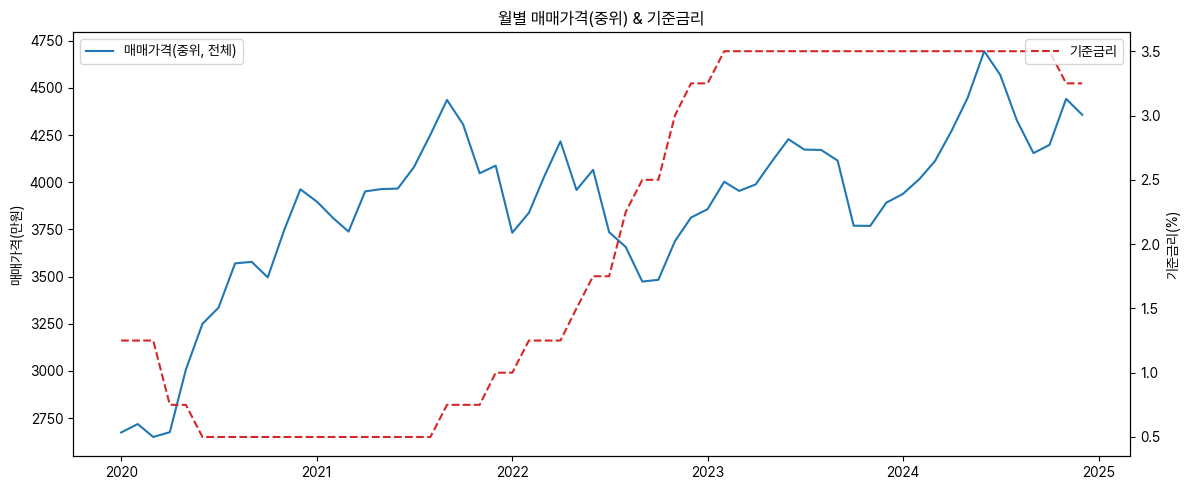

In [92]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(monthly['Í≥ÑÏïΩÎÖÑÏõî'], monthly['Îß§Îß§Í∞ÄÍ≤©'], label='Îß§Îß§Í∞ÄÍ≤©(Ï§ëÏúÑ, Ï†ÑÏ≤¥)')
ax1.set_ylabel('Îß§Îß§Í∞ÄÍ≤©(ÎßåÏõê)')
ax2 = ax1.twinx()
ax2.plot(monthly['Í≥ÑÏïΩÎÖÑÏõî'], monthly['Í∏∞Ï§ÄÍ∏àÎ¶¨'], color='tab:red', linestyle='--', label='Í∏∞Ï§ÄÍ∏àÎ¶¨')
ax2.set_ylabel('Í∏∞Ï§ÄÍ∏àÎ¶¨(%)')
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.title('ÏõîÎ≥Ñ Îß§Îß§Í∞ÄÍ≤©(Ï§ëÏúÑ) & Í∏∞Ï§ÄÍ∏àÎ¶¨')
plt.tight_layout(); plt.show()

In [98]:
# Í∏∞Ïö∏Í∏∞ Í≥ÑÏÇ∞: Ï†ÑÏõî ÎåÄÎπÑ Î≥ÄÌôîÎüâ
slope_table = monthly.copy()

# Ï£ºÏöî ÏàòÏπòÌòï Ïª¨ÎüºÏóê ÎåÄÌï¥ Í∏∞Ïö∏Í∏∞ Í≥ÑÏÇ∞
for col in ['Îß§Îß§Í∞ÄÍ≤©', 'Í∏∞Ï§ÄÍ∏àÎ¶¨', 'Í∏àÎ¶¨_6M', 'Í∏àÎ¶¨_12M']:
    slope_table[f'{col}_Í∏∞Ïö∏Í∏∞'] = slope_table[col].diff()

display(slope_table.head(10))

Í≥ÑÏïΩÎÖÑÏõî      Îß§Îß§Í∞ÄÍ≤©  Í∏∞Ï§ÄÍ∏àÎ¶¨     Í∏àÎ¶¨_6M    Í∏àÎ¶¨_12M  Îß§Îß§Í∞ÄÍ≤©_Í∏∞Ïö∏Í∏∞  Í∏∞Ï§ÄÍ∏àÎ¶¨_Í∏∞Ïö∏Í∏∞  \
0 2020-01-01  2673.610  1.25  1.250000  1.250000       NaN       NaN   
1 2020-02-01  2718.290  1.25  1.250000  1.250000    44.680      0.00   
2 2020-03-01  2649.720  1.25  1.250000  1.250000   -68.570      0.00   
3 2020-04-01  2675.225  0.75  1.125000  1.125000    25.505     -0.50   
4 2020-05-01  3007.110  0.75  1.050000  1.050000   331.885      0.00   
5 2020-06-01  3249.790  0.50  0.958333  0.958333   242.680     -0.25   
6 2020-07-01  3335.165  0.50  0.833333  0.892857    85.375      0.00   
7 2020-08-01  3570.040  0.50  0.708333  0.843750   234.875      0.00   
8 2020-09-01  3578.085  0.50  0.583333  0.805556     8.045      0.00   
9 2020-10-01  3495.880  0.50  0.541667  0.775000   -82.205      0.00   

   Í∏àÎ¶¨_6M_Í∏∞Ïö∏Í∏∞  Í∏àÎ¶¨_12M_Í∏∞Ïö∏Í∏∞  
0        NaN         NaN  
1   0.000000    0.000000  
2   0.000000    0.000000  
3  -0.125000   -0.125000  
4  -0.075000   -0.075000  
5  -0.091667   -0.091667  
6  -0.125000   -0.065476  
7  -0.125000   -0.049107  
8  -0.125000   -0.038194  
9  -0.041667   -0.030556

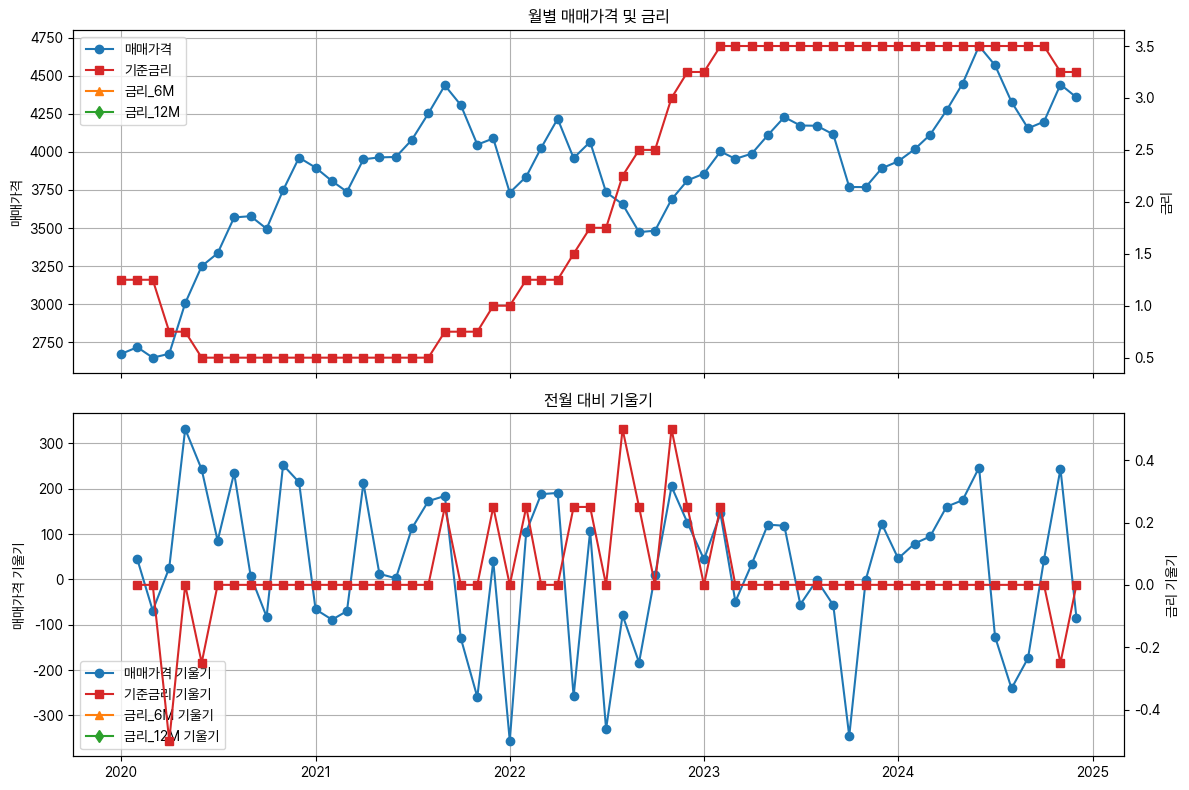

In [102]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 1. ÏõêÏãú Í∞í ÏãúÍ∞ÅÌôî (Îß§Îß§Í∞ÄÍ≤© vs Í∏àÎ¶¨)
ax1 = axes[0]
ax2 = ax1.twinx()  # Ïò§Î•∏Ï™Ω yÏ∂ï

lns1 = ax1.plot(slope_table['Í≥ÑÏïΩÎÖÑÏõî'], slope_table['Îß§Îß§Í∞ÄÍ≤©'],
                color='tab:blue', marker='o', label='Îß§Îß§Í∞ÄÍ≤©')
lns2 = ax2.plot(slope_table['Í≥ÑÏïΩÎÖÑÏõî'], slope_table['Í∏∞Ï§ÄÍ∏àÎ¶¨'],
                color='tab:red', marker='s', label='Í∏∞Ï§ÄÍ∏àÎ¶¨')

ax1.set_title('ÏõîÎ≥Ñ Îß§Îß§Í∞ÄÍ≤© Î∞è Í∏àÎ¶¨')
ax1.set_ylabel('Îß§Îß§Í∞ÄÍ≤©')
ax2.set_ylabel('Í∏àÎ¶¨')
lns = lns1 + lns2 + lns3 + lns4
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='best')
ax1.grid(True)

# 2. Í∏∞Ïö∏Í∏∞ ÏãúÍ∞ÅÌôî (Îß§Îß§Í∞ÄÍ≤© Í∏∞Ïö∏Í∏∞ vs Í∏àÎ¶¨ Í∏∞Ïö∏Í∏∞)
ax3 = axes[1]
ax4 = ax3.twinx()

lns5 = ax3.plot(slope_table['Í≥ÑÏïΩÎÖÑÏõî'], slope_table['Îß§Îß§Í∞ÄÍ≤©_Í∏∞Ïö∏Í∏∞'],
                color='tab:blue', marker='o', label='Îß§Îß§Í∞ÄÍ≤© Í∏∞Ïö∏Í∏∞')
lns6 = ax4.plot(slope_table['Í≥ÑÏïΩÎÖÑÏõî'], slope_table['Í∏∞Ï§ÄÍ∏àÎ¶¨_Í∏∞Ïö∏Í∏∞'],
                color='tab:red', marker='s', label='Í∏∞Ï§ÄÍ∏àÎ¶¨ Í∏∞Ïö∏Í∏∞')

ax3.set_title('Ï†ÑÏõî ÎåÄÎπÑ Í∏∞Ïö∏Í∏∞')
ax3.set_ylabel('Îß§Îß§Í∞ÄÍ≤© Í∏∞Ïö∏Í∏∞')
ax4.set_ylabel('Í∏àÎ¶¨ Í∏∞Ïö∏Í∏∞')
lns = lns5 + lns6 + lns7 + lns8
labels = [l.get_label() for l in lns]
ax3.legend(lns, labels, loc='best')
ax3.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()